# Problem 10.2

**Problem 10.2. Capacity and dispatch optimization in a network with a CO2 constraint.**

**We build on Problem 10.1 (d), i.e. we optimise F endogenously.**

**For (a)-(c), always calculate the following values:** 
 - **Total system costs (in bn EUR)**
 - **Average electricity price (in EUR/MWh); number/share of hours with a price below 2 EUR/MWh**
 - **Congestion rent**
 - **Utilisation of transmission lines (in % of cap.)**
 - **Total generation per technology (in TWh)**
 - **CO2 price (in EUR/tCO2)**

 **a) Set up a network as in 10.1d) and add a CO2 constraint of 2.5 MtCO2/year.**

 **b) The load distribution between Denmark and Portugal is approx. 1:1.5. Assume that both countries have national targets of 1 MtCO2/year and 1.5 MtCO2/year.**

 **c) Assume the CO2 limits from b, but that the transmission capacities is limited to 1 GW (still endougenously optimised).**

 **d) Change the global CO2 limit to 0.25, 0.5, 1, 1.5, 2 MtCO2/year, and plot the total system costs against the CO2 limit.**









In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa

Set parameter Username
Set parameter LicenseID to value 2767832
Academic license - for non-commercial use only - expires 2027-01-20


## Prerequisites: handling technology data and costs

We maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [2]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [3]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [4]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [5]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the marginal generation costs (€/MWh):

In [6]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [7]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [8]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

We can now read the capital and marginal cost of onshore wind, solar and OCGT

In [9]:
costs.at["onwind", "capital_cost"] #EUR/MW/a

np.float64(101644.12332388277)

In [10]:
costs.at["solar", "capital_cost"] #EUR/MW/a

np.float64(51346.82981964593)

In [11]:
costs.at["OCGT", "capital_cost"] #EUR/MW/a

np.float64(47718.67056370105)

In [12]:
costs.at["OCGT", "marginal_cost"] #EUR/MWh

np.float64(64.6839512195122)

## Retrieving time series data

In this example, wind data from [https://zenodo.org/record/3253876#.XSiVOEdS8l0](https://zenodo.org/record/3253876#.XSiVOEdS8l0) and solar PV data from [https://zenodo.org/record/2613651#.X0kbhDVS-uV](https://zenodo.org/record/3253876#.XSiVOEdS8l0) is used. The data is downloaded in csv format and saved in the 'data' folder.
The Pandas package is used as a convenient way of managing the datasets.

For convenience, the column including date information is converted into Datetime and set as index

In [13]:
data_solar = pd.read_csv('data/pv_optimal.csv',sep=';')
data_solar.index = pd.DatetimeIndex(data_solar['utc_time'])

data_wind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';')
data_wind.index = pd.DatetimeIndex(data_wind['utc_time'])

data_el = pd.read_csv('data/electricity_demand.csv',sep=';')
data_el.index = pd.DatetimeIndex(data_el['utc_time'])

The data format can now be analyzed using the .head() function to show the first lines of the data set

In [14]:
data_solar.head()

,utc_time,AUT,BEL,BGR,BIH,CHE,CYP,CZE,DEU,DNK,...,MLT,NLD,NOR,POL,PRT,ROU,SRB,SVK,SVN,SWE
utc_time,,,,,,,,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,1979-01-01T00:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 01:00:00+00:00,1979-01-01T01:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 02:00:00+00:00,1979-01-01T02:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 03:00:00+00:00,1979-01-01T03:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 04:00:00+00:00,1979-01-01T04:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will use timeseries for Portugal and Denmark in this excercise

In [15]:
countries = ['PRT', 'DNK']
coordinates = {'PRT': (38.74, -9.15), 'DNK': (55.67, 12.57)}

# a. Add CO2 constraint, F endogenous.

For building the model, we start again by initialising an empty network, adding the snapshots, and the electricity buses.

In [16]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

for country in countries:
    n.add("Bus",
          country,
          y = coordinates[country][0],
          x = coordinates[country][1],
          carrier="AC"
          )


In [17]:
carriers = [
    "onwind",
    "solar",
    "OCGT",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred",],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

In [18]:
# add load to the buses
for country in countries:
    n.add("Load",
        f"{country} load",
        bus=country,
        p_set=data_el[country].values,
        carrier = "AC")

In [19]:
for country in countries:
    n.add(
        "Generator",
        f"{country} OCGT",
        bus=country,
        carrier="OCGT",
        capital_cost=costs.at["OCGT", "capital_cost"],
        marginal_cost=costs.at["OCGT", "marginal_cost"],
        efficiency=costs.at["OCGT", "efficiency"],
        p_nom_extendable=True,
    )   
    CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} onwind",
        bus=country,
        carrier="onwind",
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        p_max_pu=CF_wind.values,
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )
    CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} solar",
        bus=country,
        carrier="solar",
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        p_max_pu=CF_solar.values,
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

Endogenous optimisation of AC line capacity (starting at 0 GW).

In [20]:
n.add(
    "Line",
    "PRT-DNK",
    bus0="PRT",
    bus1="DNK",
    s_nom = 0,
    x = 1,
    r = 1,
    capital_cost = costs.at["HVAC overhead", "capital_cost"] * 2477,
    s_nom_extendable = True,
)

Add global CO2 limit of 2.5 MtCO2/year.

In [21]:
n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=2500000, #2.5MtCO2
)

{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x1069317f0>},
 'branches': {'Line': <matplotlib.collections.LineCollection at 0x30699dd30>},
 'flows': {}}

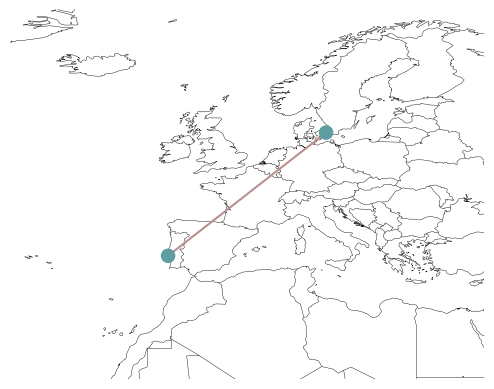

In [22]:
n.plot(bus_sizes=1, margin=1)

In [23]:
n.optimize(solver_name="gurobi")

Index(['PRT', 'DNK'], dtype='object', name='name')
Index(['PRT load', 'DNK load'], dtype='object', name='name')
Index(['PRT-DNK'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 181.79it/s]
INFO:linopy.io: Writing time: 0.29s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2767832


INFO:gurobipy:Set parameter LicenseID to value 2767832


Academic license - for non-commercial use only - expires 2027-01-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2027-01-20


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-lr9y1lmx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-lr9y1lmx.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 140168 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140168 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros (Min)


INFO:gurobipy:Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros (Min)


Model fingerprint: 0xcf8c11b5


INFO:gurobipy:Model fingerprint: 0xcf8c11b5


Model has 52567 linear objective coefficients


INFO:gurobipy:Model has 52567 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 2e+06]


INFO:gurobipy:  RHS range        [2e+03, 2e+06]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.19s


INFO:gurobipy:Presolve time: 0.19s


Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.182e+05


INFO:gurobipy: AA' NZ     : 2.182e+05


 Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


 Factor Ops : 1.008e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.008e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.26765238e+11  0.00000000e+00  3.15e+09 0.00e+00  2.37e+08     0s


INFO:gurobipy:   0   5.26765238e+11  0.00000000e+00  3.15e+09 0.00e+00  2.37e+08     0s


   1   6.10890823e+11 -9.68985986e+10  6.22e+08 2.23e+02  5.77e+07     0s


INFO:gurobipy:   1   6.10890823e+11 -9.68985986e+10  6.22e+08 2.23e+02  5.77e+07     0s


   2   4.48041353e+11 -1.16553990e+11  2.10e+07 2.18e+00  4.69e+06     0s


INFO:gurobipy:   2   4.48041353e+11 -1.16553990e+11  2.10e+07 2.18e+00  4.69e+06     0s


   3   7.65399378e+10 -4.00780552e+10  2.31e+06 2.20e-01  8.36e+05     1s


INFO:gurobipy:   3   7.65399378e+10 -4.00780552e+10  2.31e+06 2.20e-01  8.36e+05     1s


   4   4.80401967e+10 -2.02946431e+10  1.34e+06 9.60e-10  4.79e+05     1s


INFO:gurobipy:   4   4.80401967e+10 -2.02946431e+10  1.34e+06 9.60e-10  4.79e+05     1s


   5   3.30337282e+10 -1.48679559e+10  8.49e+05 6.98e-10  3.32e+05     1s


INFO:gurobipy:   5   3.30337282e+10 -1.48679559e+10  8.49e+05 6.98e-10  3.32e+05     1s


   6   2.62029598e+10 -1.03994074e+10  6.29e+05 6.11e-10  2.52e+05     1s


INFO:gurobipy:   6   2.62029598e+10 -1.03994074e+10  6.29e+05 6.11e-10  2.52e+05     1s


   7   1.86494975e+10 -4.85299148e+09  3.91e+05 2.62e-10  1.61e+05     1s


INFO:gurobipy:   7   1.86494975e+10 -4.85299148e+09  3.91e+05 2.62e-10  1.61e+05     1s


   8   1.45438364e+10 -1.29932145e+09  2.70e+05 3.06e-10  1.08e+05     1s


INFO:gurobipy:   8   1.45438364e+10 -1.29932145e+09  2.70e+05 3.06e-10  1.08e+05     1s


   9   1.38103617e+10 -7.49157545e+08  2.46e+05 4.95e-10  9.93e+04     1s


INFO:gurobipy:   9   1.38103617e+10 -7.49157545e+08  2.46e+05 4.95e-10  9.93e+04     1s


  10   1.32724454e+10  4.39294294e+08  2.26e+05 6.11e-10  8.75e+04     1s


INFO:gurobipy:  10   1.32724454e+10  4.39294294e+08  2.26e+05 6.11e-10  8.75e+04     1s


  11   1.12681179e+10  2.45514877e+09  1.63e+05 9.46e-11  6.00e+04     1s


INFO:gurobipy:  11   1.12681179e+10  2.45514877e+09  1.63e+05 9.46e-11  6.00e+04     1s


  12   1.09140516e+10  2.92356088e+09  1.52e+05 4.07e-10  5.44e+04     1s


INFO:gurobipy:  12   1.09140516e+10  2.92356088e+09  1.52e+05 4.07e-10  5.44e+04     1s


  13   1.04382174e+10  3.30912657e+09  1.37e+05 5.53e-10  4.85e+04     1s


INFO:gurobipy:  13   1.04382174e+10  3.30912657e+09  1.37e+05 5.53e-10  4.85e+04     1s


  14   1.01625762e+10  3.56596622e+09  1.26e+05 6.40e-10  4.49e+04     1s


INFO:gurobipy:  14   1.01625762e+10  3.56596622e+09  1.26e+05 6.40e-10  4.49e+04     1s


  15   9.52948858e+09  4.21270707e+09  1.03e+05 8.44e-10  3.62e+04     1s


INFO:gurobipy:  15   9.52948858e+09  4.21270707e+09  1.03e+05 8.44e-10  3.62e+04     1s


  16   9.26362538e+09  4.95394175e+09  9.05e+04 1.75e-10  2.93e+04     1s


INFO:gurobipy:  16   9.26362538e+09  4.95394175e+09  9.05e+04 1.75e-10  2.93e+04     1s


  17   9.13196092e+09  5.22918629e+09  8.45e+04 4.95e-10  2.66e+04     1s


INFO:gurobipy:  17   9.13196092e+09  5.22918629e+09  8.45e+04 4.95e-10  2.66e+04     1s


  18   8.82313808e+09  5.41896103e+09  6.89e+04 6.55e-10  2.32e+04     1s


INFO:gurobipy:  18   8.82313808e+09  5.41896103e+09  6.89e+04 6.55e-10  2.32e+04     1s


  19   8.65924562e+09  5.55432626e+09  5.89e+04 8.73e-11  2.11e+04     1s


INFO:gurobipy:  19   8.65924562e+09  5.55432626e+09  5.89e+04 8.73e-11  2.11e+04     1s


  20   8.49397810e+09  6.07105532e+09  4.90e+04 7.86e-10  1.65e+04     1s


INFO:gurobipy:  20   8.49397810e+09  6.07105532e+09  4.90e+04 7.86e-10  1.65e+04     1s


  21   8.40323974e+09  6.20150879e+09  4.40e+04 1.54e-09  1.50e+04     2s


INFO:gurobipy:  21   8.40323974e+09  6.20150879e+09  4.40e+04 1.54e-09  1.50e+04     2s


  22   8.30222493e+09  6.31498984e+09  3.84e+04 5.24e-10  1.35e+04     2s


INFO:gurobipy:  22   8.30222493e+09  6.31498984e+09  3.84e+04 5.24e-10  1.35e+04     2s


  23   8.26649916e+09  6.38087684e+09  3.49e+04 2.91e-10  1.28e+04     2s


INFO:gurobipy:  23   8.26649916e+09  6.38087684e+09  3.49e+04 2.91e-10  1.28e+04     2s


  24   8.22390988e+09  6.54457323e+09  3.22e+04 4.95e-10  1.14e+04     2s


INFO:gurobipy:  24   8.22390988e+09  6.54457323e+09  3.22e+04 4.95e-10  1.14e+04     2s


  25   8.17599646e+09  6.64143869e+09  2.89e+04 2.33e-10  1.04e+04     2s


INFO:gurobipy:  25   8.17599646e+09  6.64143869e+09  2.89e+04 2.33e-10  1.04e+04     2s


  26   8.15739438e+09  6.76253791e+09  2.77e+04 3.49e-10  9.48e+03     2s


INFO:gurobipy:  26   8.15739438e+09  6.76253791e+09  2.77e+04 3.49e-10  9.48e+03     2s


  27   8.08927947e+09  6.86831869e+09  2.29e+04 6.40e-10  8.30e+03     2s


INFO:gurobipy:  27   8.08927947e+09  6.86831869e+09  2.29e+04 6.40e-10  8.30e+03     2s


  28   8.06594186e+09  6.92560759e+09  2.11e+04 6.69e-10  7.75e+03     2s


INFO:gurobipy:  28   8.06594186e+09  6.92560759e+09  2.11e+04 6.69e-10  7.75e+03     2s


  29   8.03682206e+09  7.00890060e+09  1.87e+04 4.00e-11  6.98e+03     2s


INFO:gurobipy:  29   8.03682206e+09  7.00890060e+09  1.87e+04 4.00e-11  6.98e+03     2s


  30   8.01985692e+09  7.05543159e+09  1.64e+04 6.69e-10  6.55e+03     2s


INFO:gurobipy:  30   8.01985692e+09  7.05543159e+09  1.64e+04 6.69e-10  6.55e+03     2s


  31   7.98958400e+09  7.12347378e+09  1.28e+04 2.33e-10  5.87e+03     2s


INFO:gurobipy:  31   7.98958400e+09  7.12347378e+09  1.28e+04 2.33e-10  5.87e+03     2s


  32   7.95874226e+09  7.23703268e+09  9.59e+03 3.78e-10  4.89e+03     2s


INFO:gurobipy:  32   7.95874226e+09  7.23703268e+09  9.59e+03 3.78e-10  4.89e+03     2s


  33   7.94493370e+09  7.30566827e+09  8.53e+03 8.73e-11  4.33e+03     2s


INFO:gurobipy:  33   7.94493370e+09  7.30566827e+09  8.53e+03 8.73e-11  4.33e+03     2s


  34   7.93608045e+09  7.34715634e+09  7.90e+03 1.31e-10  3.99e+03     2s


INFO:gurobipy:  34   7.93608045e+09  7.34715634e+09  7.90e+03 1.31e-10  3.99e+03     2s


  35   7.93262336e+09  7.36521865e+09  7.62e+03 2.33e-10  3.84e+03     2s


INFO:gurobipy:  35   7.93262336e+09  7.36521865e+09  7.62e+03 2.33e-10  3.84e+03     2s


  36   7.92080197e+09  7.44399114e+09  6.61e+03 7.28e-10  3.23e+03     2s


INFO:gurobipy:  36   7.92080197e+09  7.44399114e+09  6.61e+03 7.28e-10  3.23e+03     2s


  37   7.91375483e+09  7.49836500e+09  6.02e+03 2.33e-10  2.82e+03     2s


INFO:gurobipy:  37   7.91375483e+09  7.49836500e+09  6.02e+03 2.33e-10  2.82e+03     2s


  38   7.90702839e+09  7.52027521e+09  5.44e+03 8.44e-10  2.62e+03     2s


INFO:gurobipy:  38   7.90702839e+09  7.52027521e+09  5.44e+03 8.44e-10  2.62e+03     2s


  39   7.89625971e+09  7.53904197e+09  4.37e+03 2.04e-10  2.42e+03     2s


INFO:gurobipy:  39   7.89625971e+09  7.53904197e+09  4.37e+03 2.04e-10  2.42e+03     2s


  40   7.89085593e+09  7.56984622e+09  3.79e+03 3.20e-10  2.17e+03     2s


INFO:gurobipy:  40   7.89085593e+09  7.56984622e+09  3.79e+03 3.20e-10  2.17e+03     2s


  41   7.88092023e+09  7.59964684e+09  2.72e+03 1.16e-10  1.90e+03     2s


INFO:gurobipy:  41   7.88092023e+09  7.59964684e+09  2.72e+03 1.16e-10  1.90e+03     2s


  42   7.87711253e+09  7.61843549e+09  2.40e+03 2.91e-10  1.75e+03     2s


INFO:gurobipy:  42   7.87711253e+09  7.61843549e+09  2.40e+03 2.91e-10  1.75e+03     2s


  43   7.87498033e+09  7.63676267e+09  2.15e+03 3.78e-10  1.61e+03     2s


INFO:gurobipy:  43   7.87498033e+09  7.63676267e+09  2.15e+03 3.78e-10  1.61e+03     2s


  44   7.86927998e+09  7.67163453e+09  1.70e+03 3.78e-10  1.33e+03     2s


INFO:gurobipy:  44   7.86927998e+09  7.67163453e+09  1.70e+03 3.78e-10  1.33e+03     2s


  45   7.86490384e+09  7.68662082e+09  1.23e+03 1.75e-10  1.20e+03     2s


INFO:gurobipy:  45   7.86490384e+09  7.68662082e+09  1.23e+03 1.75e-10  1.20e+03     2s


  46   7.86219547e+09  7.71679392e+09  1.00e+03 6.40e-10  9.81e+02     2s


INFO:gurobipy:  46   7.86219547e+09  7.71679392e+09  1.00e+03 6.40e-10  9.81e+02     2s


  47   7.86008375e+09  7.73031407e+09  8.45e+02 3.78e-10  8.75e+02     2s


INFO:gurobipy:  47   7.86008375e+09  7.73031407e+09  8.45e+02 3.78e-10  8.75e+02     2s


  48   7.85887615e+09  7.73397533e+09  7.59e+02 4.37e-10  8.42e+02     2s


INFO:gurobipy:  48   7.85887615e+09  7.73397533e+09  7.59e+02 4.37e-10  8.42e+02     2s


  49   7.85691075e+09  7.74654850e+09  5.99e+02 3.78e-10  7.44e+02     2s


INFO:gurobipy:  49   7.85691075e+09  7.74654850e+09  5.99e+02 3.78e-10  7.44e+02     2s


  50   7.85667993e+09  7.75186239e+09  5.81e+02 7.28e-10  7.07e+02     3s


INFO:gurobipy:  50   7.85667993e+09  7.75186239e+09  5.81e+02 7.28e-10  7.07e+02     3s


  51   7.85562967e+09  7.76259402e+09  5.07e+02 4.95e-10  6.27e+02     3s


INFO:gurobipy:  51   7.85562967e+09  7.76259402e+09  5.07e+02 4.95e-10  6.27e+02     3s


  52   7.85475612e+09  7.76992715e+09  4.47e+02 9.28e-10  5.72e+02     3s


INFO:gurobipy:  52   7.85475612e+09  7.76992715e+09  4.47e+02 9.28e-10  5.72e+02     3s


  53   7.85409753e+09  7.77270987e+09  3.97e+02 1.38e-09  5.49e+02     3s


INFO:gurobipy:  53   7.85409753e+09  7.77270987e+09  3.97e+02 1.38e-09  5.49e+02     3s


  54   7.85330524e+09  7.77657650e+09  3.38e+02 1.82e-09  5.17e+02     3s


INFO:gurobipy:  54   7.85330524e+09  7.77657650e+09  3.38e+02 1.82e-09  5.17e+02     3s


  55   7.85261938e+09  7.78129618e+09  2.92e+02 4.36e-09  4.80e+02     3s


INFO:gurobipy:  55   7.85261938e+09  7.78129618e+09  2.92e+02 4.36e-09  4.80e+02     3s


  56   7.85141038e+09  7.78812469e+09  1.94e+02 3.71e-09  4.26e+02     3s


INFO:gurobipy:  56   7.85141038e+09  7.78812469e+09  1.94e+02 3.71e-09  4.26e+02     3s


  57   7.85125030e+09  7.79393338e+09  1.82e+02 5.66e-09  3.86e+02     3s


INFO:gurobipy:  57   7.85125030e+09  7.79393338e+09  1.82e+02 5.66e-09  3.86e+02     3s


  58   7.85046873e+09  7.79784536e+09  1.43e+02 7.44e-09  3.54e+02     3s


INFO:gurobipy:  58   7.85046873e+09  7.79784536e+09  1.43e+02 7.44e-09  3.54e+02     3s


  59   7.85010575e+09  7.80210811e+09  1.24e+02 8.75e-09  3.23e+02     3s


INFO:gurobipy:  59   7.85010575e+09  7.80210811e+09  1.24e+02 8.75e-09  3.23e+02     3s


  60   7.84935326e+09  7.80621305e+09  7.91e+01 8.63e-09  2.90e+02     3s


INFO:gurobipy:  60   7.84935326e+09  7.80621305e+09  7.91e+01 8.63e-09  2.90e+02     3s


  61   7.84912298e+09  7.81141873e+09  7.26e+01 1.34e-08  2.54e+02     3s


INFO:gurobipy:  61   7.84912298e+09  7.81141873e+09  7.26e+01 1.34e-08  2.54e+02     3s


  62   7.84897276e+09  7.81829320e+09  5.81e+01 1.42e-08  2.06e+02     3s


INFO:gurobipy:  62   7.84897276e+09  7.81829320e+09  5.81e+01 1.42e-08  2.06e+02     3s


  63   7.84794091e+09  7.82103224e+09  4.92e+00 1.46e-08  1.81e+02     3s


INFO:gurobipy:  63   7.84794091e+09  7.82103224e+09  4.92e+00 1.46e-08  1.81e+02     3s


  64   7.84782990e+09  7.82235752e+09  4.08e+00 1.41e-08  1.71e+02     3s


INFO:gurobipy:  64   7.84782990e+09  7.82235752e+09  4.08e+00 1.41e-08  1.71e+02     3s


  65   7.84756191e+09  7.82624525e+09  6.60e-01 1.12e-08  1.43e+02     4s


INFO:gurobipy:  65   7.84756191e+09  7.82624525e+09  6.60e-01 1.12e-08  1.43e+02     4s


  66   7.84747160e+09  7.82787978e+09  5.39e-01 1.10e-08  1.32e+02     4s


INFO:gurobipy:  66   7.84747160e+09  7.82787978e+09  5.39e-01 1.10e-08  1.32e+02     4s


  67   7.84741751e+09  7.82872468e+09  4.72e-01 1.06e-08  1.26e+02     4s


INFO:gurobipy:  67   7.84741751e+09  7.82872468e+09  4.72e-01 1.06e-08  1.26e+02     4s


  68   7.84741248e+09  7.82932813e+09  4.39e-01 1.07e-08  1.22e+02     4s


INFO:gurobipy:  68   7.84741248e+09  7.82932813e+09  4.39e-01 1.07e-08  1.22e+02     4s


  69   7.84739946e+09  7.83122560e+09  3.81e-01 9.40e-09  1.09e+02     4s


INFO:gurobipy:  69   7.84739946e+09  7.83122560e+09  3.81e-01 9.40e-09  1.09e+02     4s


  70   7.84735700e+09  7.83188437e+09  3.45e-01 9.50e-09  1.04e+02     4s


INFO:gurobipy:  70   7.84735700e+09  7.83188437e+09  3.45e-01 9.50e-09  1.04e+02     4s


  71   7.84733047e+09  7.83470298e+09  2.75e-01 7.48e-09  8.49e+01     4s


INFO:gurobipy:  71   7.84733047e+09  7.83470298e+09  2.75e-01 7.48e-09  8.49e+01     4s


  72   7.84732820e+09  7.83927511e+09  2.08e-01 5.96e-09  5.41e+01     4s


INFO:gurobipy:  72   7.84732820e+09  7.83927511e+09  2.08e-01 5.96e-09  5.41e+01     4s


  73   7.84722252e+09  7.84004495e+09  7.40e-02 5.18e-09  4.82e+01     4s


INFO:gurobipy:  73   7.84722252e+09  7.84004495e+09  7.40e-02 5.18e-09  4.82e+01     4s


  74   7.84720150e+09  7.84365462e+09  5.92e-02 2.41e-09  2.38e+01     4s


INFO:gurobipy:  74   7.84720150e+09  7.84365462e+09  5.92e-02 2.41e-09  2.38e+01     4s


  75   7.84717043e+09  7.84399030e+09  3.26e-02 2.48e-09  2.14e+01     4s


INFO:gurobipy:  75   7.84717043e+09  7.84399030e+09  3.26e-02 2.48e-09  2.14e+01     4s


  76   7.84715457e+09  7.84462755e+09  2.50e-02 1.95e-09  1.70e+01     4s


INFO:gurobipy:  76   7.84715457e+09  7.84462755e+09  2.50e-02 1.95e-09  1.70e+01     4s


  77   7.84715302e+09  7.84512416e+09  2.43e-02 2.01e-09  1.36e+01     4s


INFO:gurobipy:  77   7.84715302e+09  7.84512416e+09  2.43e-02 2.01e-09  1.36e+01     4s


  78   7.84714586e+09  7.84550866e+09  2.10e-02 1.25e-09  1.10e+01     4s


INFO:gurobipy:  78   7.84714586e+09  7.84550866e+09  2.10e-02 1.25e-09  1.10e+01     4s


  79   7.84711442e+09  7.84581456e+09  5.00e-04 9.31e-10  8.74e+00     4s


INFO:gurobipy:  79   7.84711442e+09  7.84581456e+09  5.00e-04 9.31e-10  8.74e+00     4s


  80   7.84709546e+09  7.84706359e+09  3.13e-05 1.89e-10  2.14e-01     4s


INFO:gurobipy:  80   7.84709546e+09  7.84706359e+09  3.13e-05 1.89e-10  2.14e-01     4s


  81   7.84709147e+09  7.84709123e+09  2.78e-07 7.86e-10  1.60e-03     4s


INFO:gurobipy:  81   7.84709147e+09  7.84709123e+09  2.78e-07 7.86e-10  1.60e-03     4s


  82   7.84709142e+09  7.84709142e+09  2.19e-07 9.81e-09  6.73e-09     4s


INFO:gurobipy:  82   7.84709142e+09  7.84709142e+09  2.19e-07 9.81e-09  6.73e-09     4s


INFO:gurobipy:


Barrier solved model in 82 iterations and 4.10 seconds (2.31 work units)


INFO:gurobipy:Barrier solved model in 82 iterations and 4.10 seconds (2.31 work units)


Optimal objective 7.84709142e+09


INFO:gurobipy:Optimal objective 7.84709142e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      52 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:      52 DPushes remaining with DInf 0.0000000e+00                 4s


       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    8572 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:    8572 PPushes remaining with PInf 0.0000000e+00                 4s


       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2241642e-09      4s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2241642e-09      4s


INFO:gurobipy:


Crossover time: 0.41 seconds (1.28 work units)


INFO:gurobipy:Crossover time: 0.41 seconds (1.28 work units)


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8627    7.8470914e+09   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:    8627    7.8470914e+09   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:


Solved in 8627 iterations and 4.60 seconds (3.69 work units)


INFO:gurobipy:Solved in 8627 iterations and 4.60 seconds (3.69 work units)


Optimal objective  7.847091424e+09


INFO:gurobipy:Optimal objective  7.847091424e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140168 duals
Objective: 7.85e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper were not assigned to the network.


('ok', 'optimal')

In [24]:
# Total system costs
n.objective/1e9

7.8470914242010945

In [25]:
# Average electricity price
n.buses_t.marginal_price.mean()

name
PRT    126.774772
DNK    123.115762
dtype: float64

In [26]:
# Hours with almost zero price
n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count()

name
PRT    6803
DNK    6863
dtype: int64

In [27]:
# Share of hours with almost zero price
(n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count())/len(n.snapshots)

name
PRT    0.776598
DNK    0.783447
dtype: float64

In [28]:
# Congestion rent
((n.buses_t.marginal_price["PRT"] - n.buses_t.marginal_price["DNK"]) * n.lines_t.p0["PRT-DNK"]).sum()

np.float64(-412486852.28237)

In [29]:
# Utilisation of transmission line
n.lines_t.p0.abs().mean() / n.lines.s_nom_opt

name
PRT-DNK    0.630284
dtype: float64

In [30]:
# Total generation
n.generators_t.p.sum(axis=0).groupby([n.generators.bus, n.generators.carrier]).sum().div(1e6).round(1)

bus  carrier
DNK  OCGT        4.3
     onwind     14.5
     solar       2.0
PRT  OCGT        0.9
     onwind     46.9
     solar      13.2
dtype: float64

In [31]:
n.generators.efficiency

name
PRT OCGT      0.41
PRT onwind    1.00
PRT solar     1.00
DNK OCGT      0.41
DNK onwind    1.00
DNK solar     1.00
Name: efficiency, dtype: float64

In [32]:
# Total CO2 emissions
n.generators_t.p.sum(axis=0).groupby([n.generators.carrier]).sum()["OCGT"] * (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

np.float64(2500000.0000000084)

In [33]:
# CO2 price
n.global_constraints

,type,investment_period,bus,carrier_attribute,sense,constant,mu
name,,,,,,,
CO2Limit,primary_energy,NaN,,co2_emissions,<=,2500000.0,-981.629031


# b. National CO2 limits, F endogenous.

In [34]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

for country in countries:
    n.add("Bus",
          country,
          y = coordinates[country][0],
          x = coordinates[country][1],
          carrier="AC"
          )

carriers = [
    "onwind",
    "solar",
    "OCGT",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred",],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)
# add load to the bus
for country in countries:
    n.add("Load",
        f"{country} load",
        bus=country,
        p_set=data_el[country].values,
        carrier = "AC")
for country in countries:
    n.add(
        "Generator",
        f"{country} OCGT",
        bus=country,
        carrier="OCGT",
        capital_cost=costs.at["OCGT", "capital_cost"],
        marginal_cost=costs.at["OCGT", "marginal_cost"],
        efficiency=costs.at["OCGT", "efficiency"],
        p_nom_extendable=True,
    )   
    CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} onwind",
        bus=country,
        carrier="onwind",
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        p_max_pu=CF_wind.values,
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )
    CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} solar",
        bus=country,
        carrier="solar",
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        p_max_pu=CF_solar.values,
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )
n.add(
    "Line",
    "PRT-DNK",
    bus0="PRT",
    bus1="DNK",
    s_nom = 0,
    x = 1,
    r = 1,
    capital_cost = costs.at["HVAC overhead", "capital_cost"] * 2477,
    s_nom_extendable = True,
)

Add national CO2 limits of 1 MtCO2/year for Denmark and 1.5 MtCO2/year for Portugal. Use the hint from the problem description for the code.

In [40]:
n.optimize.create_model()

co2_emission_factor = (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

# Create emission factors for each generator (indexed by generator name)
import xarray as xr
emission_factors = xr.DataArray(
    [co2_emission_factor, 0, 0, co2_emission_factor, 0, 0],
    dims=["name"],
    coords={"name": n.generators.index}
)

# Calculate total emissions: sum over snapshots, multiply by emission factors
total_generation = n.model.variables["Generator-p"].sum("snapshot")
emissions = total_generation * emission_factors

# Group by bus and sum
emissions_per_bus = emissions.groupby(n.generators.bus.to_xarray()).sum()

# Create CO2 limits for each bus
co2_limits = xr.DataArray(
    [1000000, 1500000],
    dims=["bus"],
    coords={"bus": ["PRT", "DNK"]}
)

# Add constraint
n.model.add_constraints(
    emissions_per_bus,
    "<=",
    co2_limits,
    name="CO2Limit"
)

Index(['PRT', 'DNK'], dtype='object', name='name')
Index(['PRT load', 'DNK load'], dtype='object', name='name')
Index(['PRT-DNK'], dtype='object', name='name')
Index(['0'], dtype='object', name='name')


Constraint `CO2Limit` [bus: 2]:
-------------------------------
[DNK]: +0.4829 Generator-p[2015-01-01 00:00:00, DNK OCGT] + 0 Generator-p[2015-01-01 00:00:00, DNK onwind] + 0 Generator-p[2015-01-01 00:00:00, DNK solar] ... +0.4829 Generator-p[2015-12-31 23:00:00, DNK OCGT] + 0 Generator-p[2015-12-31 23:00:00, DNK onwind] + 0 Generator-p[2015-12-31 23:00:00, DNK solar] ≤ 1000000.0
[PRT]: +0.4829 Generator-p[2015-01-01 00:00:00, PRT OCGT] + 0 Generator-p[2015-01-01 00:00:00, PRT onwind] + 0 Generator-p[2015-01-01 00:00:00, PRT solar] ... +0.4829 Generator-p[2015-12-31 23:00:00, PRT OCGT] + 0 Generator-p[2015-12-31 23:00:00, PRT onwind] + 0 Generator-p[2015-12-31 23:00:00, PRT solar] ≤ 1500000.0

Use hint from the problem description.

In [41]:
n.optimize.solve_model(solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 333.97it/s]
INFO:linopy.io: Writing time: 0.33s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2767832


INFO:gurobipy:Set parameter LicenseID to value 2767832


Academic license - for non-commercial use only - expires 2027-01-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2027-01-20


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-5vhhpuf5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-5vhhpuf5.lp


Reading time = 0.20 seconds


INFO:gurobipy:Reading time = 0.20 seconds


obj: 140169 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140169 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140169 rows, 61327 columns and 271592 nonzeros (Min)


INFO:gurobipy:Optimize a model with 140169 rows, 61327 columns and 271592 nonzeros (Min)


Model fingerprint: 0xd765481b


INFO:gurobipy:Model fingerprint: 0xd765481b


Model has 52567 linear objective coefficients


INFO:gurobipy:Model has 52567 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 2e+06]


INFO:gurobipy:  RHS range        [2e+03, 2e+06]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.40s


INFO:gurobipy:Presolve time: 0.40s


Presolved: 70107 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70107 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.270e+05


INFO:gurobipy: AA' NZ     : 2.270e+05


 Factor NZ  : 8.885e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.885e+05 (roughly 50 MB of memory)


 Factor Ops : 1.178e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.178e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.22687050e+11  0.00000000e+00  1.26e+09 0.00e+00  1.90e+08     1s


INFO:gurobipy:   0   4.22687050e+11  0.00000000e+00  1.26e+09 0.00e+00  1.90e+08     1s


   1   4.90288192e+11 -9.52973816e+10  2.47e+08 2.23e+02  4.62e+07     1s


INFO:gurobipy:   1   4.90288192e+11 -9.52973816e+10  2.47e+08 2.23e+02  4.62e+07     1s


   2   3.68025619e+11 -1.10031293e+11  1.35e+07 1.70e+00  4.16e+06     1s


INFO:gurobipy:   2   3.68025619e+11 -1.10031293e+11  1.35e+07 1.70e+00  4.16e+06     1s


   3   6.25070764e+10 -3.55890244e+10  1.49e+06 1.78e-09  7.15e+05     1s


INFO:gurobipy:   3   6.25070764e+10 -3.55890244e+10  1.49e+06 1.78e-09  7.15e+05     1s


   4   3.94367930e+10 -1.90579737e+10  8.64e+05 2.91e-10  4.16e+05     1s


INFO:gurobipy:   4   3.94367930e+10 -1.90579737e+10  8.64e+05 2.91e-10  4.16e+05     1s


   5   2.93408898e+10 -1.42914113e+10  5.97e+05 3.49e-10  3.07e+05     1s


INFO:gurobipy:   5   2.93408898e+10 -1.42914113e+10  5.97e+05 3.49e-10  3.07e+05     1s


   6   2.35119955e+10 -9.51457735e+09  4.43e+05 2.18e-10  2.30e+05     1s


INFO:gurobipy:   6   2.35119955e+10 -9.51457735e+09  4.43e+05 2.18e-10  2.30e+05     1s


   7   1.79605788e+10 -3.31826418e+09  3.02e+05 2.04e-10  1.47e+05     1s


INFO:gurobipy:   7   1.79605788e+10 -3.31826418e+09  3.02e+05 2.04e-10  1.47e+05     1s


   8   1.38816008e+10 -9.70796908e+07  2.00e+05 2.91e-10  9.61e+04     1s


INFO:gurobipy:   8   1.38816008e+10 -9.70796908e+07  2.00e+05 2.91e-10  9.61e+04     1s


   9   1.20573576e+10  7.52858379e+08  1.53e+05 8.44e-10  7.76e+04     1s


INFO:gurobipy:   9   1.20573576e+10  7.52858379e+08  1.53e+05 8.44e-10  7.76e+04     1s


  10   1.17211670e+10  1.16006953e+09  1.43e+05 3.82e-11  7.24e+04     1s


INFO:gurobipy:  10   1.17211670e+10  1.16006953e+09  1.43e+05 3.82e-11  7.24e+04     1s


  11   1.10283102e+10  3.12477349e+09  1.25e+05 1.14e-09  5.42e+04     1s


INFO:gurobipy:  11   1.10283102e+10  3.12477349e+09  1.25e+05 1.14e-09  5.42e+04     1s


  12   1.03576993e+10  4.10629529e+09  1.06e+05 9.09e-11  4.29e+04     2s


INFO:gurobipy:  12   1.03576993e+10  4.10629529e+09  1.06e+05 9.09e-11  4.29e+04     2s


  13   9.64387635e+09  4.74351205e+09  8.41e+04 5.82e-10  3.36e+04     2s


INFO:gurobipy:  13   9.64387635e+09  4.74351205e+09  8.41e+04 5.82e-10  3.36e+04     2s


  14   9.46687735e+09  5.07032132e+09  7.87e+04 1.60e-09  3.02e+04     2s


INFO:gurobipy:  14   9.46687735e+09  5.07032132e+09  7.87e+04 1.60e-09  3.02e+04     2s


  15   9.27846728e+09  5.59116180e+09  6.85e+04 4.66e-10  2.53e+04     2s


INFO:gurobipy:  15   9.27846728e+09  5.59116180e+09  6.85e+04 4.66e-10  2.53e+04     2s


  16   8.88778551e+09  5.82291364e+09  5.28e+04 5.53e-10  2.10e+04     2s


INFO:gurobipy:  16   8.88778551e+09  5.82291364e+09  5.28e+04 5.53e-10  2.10e+04     2s


  17   8.57481178e+09  6.00150203e+09  3.90e+04 3.78e-10  1.76e+04     2s


INFO:gurobipy:  17   8.57481178e+09  6.00150203e+09  3.90e+04 3.78e-10  1.76e+04     2s


  18   8.49108031e+09  6.12319302e+09  3.52e+04 4.66e-10  1.62e+04     2s


INFO:gurobipy:  18   8.49108031e+09  6.12319302e+09  3.52e+04 4.66e-10  1.62e+04     2s


  19   8.40165307e+09  6.24855400e+09  3.08e+04 9.02e-10  1.47e+04     2s


INFO:gurobipy:  19   8.40165307e+09  6.24855400e+09  3.08e+04 9.02e-10  1.47e+04     2s


  20   8.30562001e+09  6.61654176e+09  2.58e+04 4.07e-10  1.16e+04     2s


INFO:gurobipy:  20   8.30562001e+09  6.61654176e+09  2.58e+04 4.07e-10  1.16e+04     2s


  21   8.23620308e+09  6.69051639e+09  2.20e+04 5.53e-10  1.06e+04     2s


INFO:gurobipy:  21   8.23620308e+09  6.69051639e+09  2.20e+04 5.53e-10  1.06e+04     2s


  22   8.14246062e+09  7.00230551e+09  1.72e+04 6.40e-10  7.80e+03     2s


INFO:gurobipy:  22   8.14246062e+09  7.00230551e+09  1.72e+04 6.40e-10  7.80e+03     2s


  23   8.10863664e+09  7.09088892e+09  1.56e+04 1.31e-10  6.96e+03     2s


INFO:gurobipy:  23   8.10863664e+09  7.09088892e+09  1.56e+04 1.31e-10  6.96e+03     2s


  24   8.07383512e+09  7.15995037e+09  1.39e+04 4.37e-10  6.25e+03     2s


INFO:gurobipy:  24   8.07383512e+09  7.15995037e+09  1.39e+04 4.37e-10  6.25e+03     2s


  25   8.04599284e+09  7.20276314e+09  1.24e+04 6.98e-10  5.76e+03     2s


INFO:gurobipy:  25   8.04599284e+09  7.20276314e+09  1.24e+04 6.98e-10  5.76e+03     2s


  26   8.03457672e+09  7.23105147e+09  1.18e+04 6.55e-11  5.49e+03     2s


INFO:gurobipy:  26   8.03457672e+09  7.23105147e+09  1.18e+04 6.55e-11  5.49e+03     2s


  27   8.02939494e+09  7.28075316e+09  1.15e+04 2.47e-10  5.12e+03     2s


INFO:gurobipy:  27   8.02939494e+09  7.28075316e+09  1.15e+04 2.47e-10  5.12e+03     2s


  28   7.99707169e+09  7.33866458e+09  9.22e+03 5.53e-10  4.50e+03     2s


INFO:gurobipy:  28   7.99707169e+09  7.33866458e+09  9.22e+03 5.53e-10  4.50e+03     2s


  29   7.97399394e+09  7.42076690e+09  7.96e+03 2.91e-10  3.78e+03     2s


INFO:gurobipy:  29   7.97399394e+09  7.42076690e+09  7.96e+03 2.91e-10  3.78e+03     2s


  30   7.95708928e+09  7.45365040e+09  6.97e+03 2.91e-10  3.44e+03     2s


INFO:gurobipy:  30   7.95708928e+09  7.45365040e+09  6.97e+03 2.91e-10  3.44e+03     2s


  31   7.94385375e+09  7.52495702e+09  6.15e+03 4.95e-10  2.86e+03     2s


INFO:gurobipy:  31   7.94385375e+09  7.52495702e+09  6.15e+03 4.95e-10  2.86e+03     2s


  32   7.93106549e+09  7.54303948e+09  5.38e+03 5.82e-11  2.65e+03     2s


INFO:gurobipy:  32   7.93106549e+09  7.54303948e+09  5.38e+03 5.82e-11  2.65e+03     2s


  33   7.91815204e+09  7.57406296e+09  4.57e+03 2.91e-11  2.35e+03     3s


INFO:gurobipy:  33   7.91815204e+09  7.57406296e+09  4.57e+03 2.91e-11  2.35e+03     3s


  34   7.91368145e+09  7.60416310e+09  4.20e+03 8.73e-11  2.11e+03     3s


INFO:gurobipy:  34   7.91368145e+09  7.60416310e+09  4.20e+03 8.73e-11  2.11e+03     3s


  35   7.90119741e+09  7.63082788e+09  3.31e+03 5.24e-10  1.84e+03     3s


INFO:gurobipy:  35   7.90119741e+09  7.63082788e+09  3.31e+03 5.24e-10  1.84e+03     3s


  36   7.89107282e+09  7.64918681e+09  2.71e+03 7.86e-10  1.65e+03     3s


INFO:gurobipy:  36   7.89107282e+09  7.64918681e+09  2.71e+03 7.86e-10  1.65e+03     3s


  37   7.88167031e+09  7.67136922e+09  1.99e+03 6.98e-10  1.43e+03     3s


INFO:gurobipy:  37   7.88167031e+09  7.67136922e+09  1.99e+03 6.98e-10  1.43e+03     3s


  38   7.87817052e+09  7.68664078e+09  1.75e+03 2.91e-10  1.30e+03     3s


INFO:gurobipy:  38   7.87817052e+09  7.68664078e+09  1.75e+03 2.91e-10  1.30e+03     3s


  39   7.87338555e+09  7.70242169e+09  1.45e+03 4.95e-10  1.16e+03     3s


INFO:gurobipy:  39   7.87338555e+09  7.70242169e+09  1.45e+03 4.95e-10  1.16e+03     3s


  40   7.86504712e+09  7.73880912e+09  9.20e+02 4.07e-10  8.55e+02     3s


INFO:gurobipy:  40   7.86504712e+09  7.73880912e+09  9.20e+02 4.07e-10  8.55e+02     3s


  41   7.86136531e+09  7.75410219e+09  6.88e+02 2.62e-10  7.26e+02     3s


INFO:gurobipy:  41   7.86136531e+09  7.75410219e+09  6.88e+02 2.62e-10  7.26e+02     3s


  42   7.85836264e+09  7.76340807e+09  5.30e+02 5.82e-10  6.42e+02     3s


INFO:gurobipy:  42   7.85836264e+09  7.76340807e+09  5.30e+02 5.82e-10  6.42e+02     3s


  43   7.85708183e+09  7.77159907e+09  4.63e+02 2.33e-10  5.78e+02     3s


INFO:gurobipy:  43   7.85708183e+09  7.77159907e+09  4.63e+02 2.33e-10  5.78e+02     3s


  44   7.85622019e+09  7.77935776e+09  4.16e+02 4.07e-10  5.19e+02     3s


INFO:gurobipy:  44   7.85622019e+09  7.77935776e+09  4.16e+02 4.07e-10  5.19e+02     3s


  45   7.85542784e+09  7.78406996e+09  3.74e+02 3.49e-10  4.82e+02     3s


INFO:gurobipy:  45   7.85542784e+09  7.78406996e+09  3.74e+02 3.49e-10  4.82e+02     3s


  46   7.85452898e+09  7.78735456e+09  3.26e+02 1.37e-09  4.54e+02     3s


INFO:gurobipy:  46   7.85452898e+09  7.78735456e+09  3.26e+02 1.37e-09  4.54e+02     3s


  47   7.85390984e+09  7.79230033e+09  2.95e+02 1.31e-10  4.16e+02     3s


INFO:gurobipy:  47   7.85390984e+09  7.79230033e+09  2.95e+02 1.31e-10  4.16e+02     3s


  48   7.85350250e+09  7.79583789e+09  2.74e+02 3.20e-10  3.89e+02     3s


INFO:gurobipy:  48   7.85350250e+09  7.79583789e+09  2.74e+02 3.20e-10  3.89e+02     3s


  49   7.85303881e+09  7.79739639e+09  2.50e+02 1.93e-10  3.76e+02     3s


INFO:gurobipy:  49   7.85303881e+09  7.79739639e+09  2.50e+02 1.93e-10  3.76e+02     3s


  50   7.85196053e+09  7.80237548e+09  2.00e+02 4.37e-10  3.35e+02     3s


INFO:gurobipy:  50   7.85196053e+09  7.80237548e+09  2.00e+02 4.37e-10  3.35e+02     3s


  51   7.85155258e+09  7.80670677e+09  1.80e+02 5.57e-10  3.03e+02     3s


INFO:gurobipy:  51   7.85155258e+09  7.80670677e+09  1.80e+02 5.57e-10  3.03e+02     3s


  52   7.85045868e+09  7.80930010e+09  1.36e+02 9.71e-10  2.77e+02     3s


INFO:gurobipy:  52   7.85045868e+09  7.80930010e+09  1.36e+02 9.71e-10  2.77e+02     3s


  53   7.85025540e+09  7.81062001e+09  1.26e+02 1.11e-09  2.67e+02     3s


INFO:gurobipy:  53   7.85025540e+09  7.81062001e+09  1.26e+02 1.11e-09  2.67e+02     3s


  54   7.85007534e+09  7.81442547e+09  1.19e+02 1.95e-09  2.40e+02     3s


INFO:gurobipy:  54   7.85007534e+09  7.81442547e+09  1.19e+02 1.95e-09  2.40e+02     3s


  55   7.84992684e+09  7.81741083e+09  1.12e+02 1.84e-09  2.19e+02     3s


INFO:gurobipy:  55   7.84992684e+09  7.81741083e+09  1.12e+02 1.84e-09  2.19e+02     3s


  56   7.84962031e+09  7.81780488e+09  9.97e+01 2.07e-09  2.14e+02     3s


INFO:gurobipy:  56   7.84962031e+09  7.81780488e+09  9.97e+01 2.07e-09  2.14e+02     3s


  57   7.84955526e+09  7.82416190e+09  9.61e+01 1.90e-09  1.71e+02     3s


INFO:gurobipy:  57   7.84955526e+09  7.82416190e+09  9.61e+01 1.90e-09  1.71e+02     3s


  58   7.84785763e+09  7.82521177e+09  1.14e+01 1.76e-09  1.52e+02     4s


INFO:gurobipy:  58   7.84785763e+09  7.82521177e+09  1.14e+01 1.76e-09  1.52e+02     4s


  59   7.84779737e+09  7.82641813e+09  1.05e+01 2.84e-09  1.44e+02     4s


INFO:gurobipy:  59   7.84779737e+09  7.82641813e+09  1.05e+01 2.84e-09  1.44e+02     4s


  60   7.84772831e+09  7.82809565e+09  9.63e+00 2.85e-09  1.32e+02     4s


INFO:gurobipy:  60   7.84772831e+09  7.82809565e+09  9.63e+00 2.85e-09  1.32e+02     4s


  61   7.84764588e+09  7.83061776e+09  7.77e+00 2.74e-09  1.14e+02     4s


INFO:gurobipy:  61   7.84764588e+09  7.83061776e+09  7.77e+00 2.74e-09  1.14e+02     4s


  62   7.84764013e+09  7.83110809e+09  7.67e+00 2.72e-09  1.11e+02     4s


INFO:gurobipy:  62   7.84764013e+09  7.83110809e+09  7.67e+00 2.72e-09  1.11e+02     4s


  63   7.84761760e+09  7.83158918e+09  7.33e+00 2.76e-09  1.08e+02     4s


INFO:gurobipy:  63   7.84761760e+09  7.83158918e+09  7.33e+00 2.76e-09  1.08e+02     4s


  64   7.84748641e+09  7.83205048e+09  5.88e+00 2.85e-09  1.04e+02     4s


INFO:gurobipy:  64   7.84748641e+09  7.83205048e+09  5.88e+00 2.85e-09  1.04e+02     4s


  65   7.84745232e+09  7.83446921e+09  5.19e+00 1.19e-09  8.72e+01     4s


INFO:gurobipy:  65   7.84745232e+09  7.83446921e+09  5.19e+00 1.19e-09  8.72e+01     4s


  66   7.84743621e+09  7.83666753e+09  4.63e+00 1.67e-09  7.24e+01     4s


INFO:gurobipy:  66   7.84743621e+09  7.83666753e+09  4.63e+00 1.67e-09  7.24e+01     4s


  67   7.84736526e+09  7.83768497e+09  3.45e+00 1.67e-09  6.50e+01     4s


INFO:gurobipy:  67   7.84736526e+09  7.83768497e+09  3.45e+00 1.67e-09  6.50e+01     4s


  68   7.84730967e+09  7.84176654e+09  1.88e+00 1.03e-09  3.72e+01     4s


INFO:gurobipy:  68   7.84730967e+09  7.84176654e+09  1.88e+00 1.03e-09  3.72e+01     4s


  69   7.84722873e+09  7.84423798e+09  9.01e-01 2.20e-09  2.01e+01     4s


INFO:gurobipy:  69   7.84722873e+09  7.84423798e+09  9.01e-01 2.20e-09  2.01e+01     4s


  70   7.84717271e+09  7.84482962e+09  4.31e-01 1.62e-09  1.57e+01     4s


INFO:gurobipy:  70   7.84717271e+09  7.84482962e+09  4.31e-01 1.62e-09  1.57e+01     4s


  71   7.84713967e+09  7.84496009e+09  2.37e-01 1.65e-09  1.46e+01     4s


INFO:gurobipy:  71   7.84713967e+09  7.84496009e+09  2.37e-01 1.65e-09  1.46e+01     4s


  72   7.84713282e+09  7.84566184e+09  1.99e-01 1.52e-09  9.88e+00     4s


INFO:gurobipy:  72   7.84713282e+09  7.84566184e+09  1.99e-01 1.52e-09  9.88e+00     4s


  73   7.84709368e+09  7.84696565e+09  7.06e-05 8.73e-10  8.60e-01     4s


INFO:gurobipy:  73   7.84709368e+09  7.84696565e+09  7.06e-05 8.73e-10  8.60e-01     4s


  74   7.84709161e+09  7.84709079e+09  6.40e-06 3.19e-09  5.47e-03     4s


INFO:gurobipy:  74   7.84709161e+09  7.84709079e+09  6.40e-06 3.19e-09  5.47e-03     4s


  75   7.84709142e+09  7.84709142e+09  3.37e-07 2.66e-09  8.48e-07     4s


INFO:gurobipy:  75   7.84709142e+09  7.84709142e+09  3.37e-07 2.66e-09  8.48e-07     4s


  76   7.84709142e+09  7.84709142e+09  4.47e-07 2.40e-09  2.83e-10     4s


INFO:gurobipy:  76   7.84709142e+09  7.84709142e+09  4.47e-07 2.40e-09  2.83e-10     4s


INFO:gurobipy:


Barrier solved model in 76 iterations and 4.33 seconds (2.18 work units)


INFO:gurobipy:Barrier solved model in 76 iterations and 4.33 seconds (2.18 work units)


Optimal objective 7.84709142e+09


INFO:gurobipy:Optimal objective 7.84709142e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      51 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:      51 DPushes remaining with DInf 0.0000000e+00                 4s


       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 4s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    8562 PPushes remaining with PInf 0.0000000e+00                 4s


INFO:gurobipy:    8562 PPushes remaining with PInf 0.0000000e+00                 4s


       0 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 5s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8288003e-09      5s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.8288003e-09      5s


INFO:gurobipy:


Crossover time: 0.53 seconds (1.21 work units)


INFO:gurobipy:Crossover time: 0.53 seconds (1.21 work units)


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8616    7.8470914e+09   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:    8616    7.8470914e+09   0.000000e+00   0.000000e+00      5s


INFO:gurobipy:


Solved in 8616 iterations and 4.97 seconds (3.48 work units)


INFO:gurobipy:Solved in 8616 iterations and 4.97 seconds (3.48 work units)


Optimal objective  7.847091424e+09


INFO:gurobipy:Optimal objective  7.847091424e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140169 duals
Objective: 7.85e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, CO2Limit were not assigned to the network.


('ok', 'optimal')

In [42]:
# Total system costs
n.objective/1e9

7.847091424201071

In [43]:
# Average electricity price
n.buses_t.marginal_price.mean()

name
PRT    126.774772
DNK    123.115762
dtype: float64

In [44]:
# Hours with almost zero price
n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count()

name
PRT    6803
DNK    6863
dtype: int64

In [45]:
# Share of hours with almost zero price
(n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count())/len(n.snapshots)

name
PRT    0.776598
DNK    0.783447
dtype: float64

In [46]:
# Congestion rent
((n.buses_t.marginal_price["PRT"] - n.buses_t.marginal_price["DNK"]) * n.lines_t.p0["PRT-DNK"]).sum()

np.float64(-412486852.2823695)

In [47]:
# Utilisation of transmission line
n.lines_t.p0.abs().mean() / n.lines.s_nom_opt

name
PRT-DNK    0.628202
dtype: float64

In [48]:
# Total generation
n.generators_t.p.sum(axis=0).groupby([n.generators.bus, n.generators.carrier]).sum().div(1e6).round(1)

bus  carrier
DNK  OCGT        2.1
     onwind     14.5
     solar       2.0
PRT  OCGT        3.1
     onwind     46.9
     solar      13.2
dtype: float64

In [49]:
n.generators.efficiency

name
PRT OCGT      0.41
PRT onwind    1.00
PRT solar     1.00
DNK OCGT      0.41
DNK onwind    1.00
DNK solar     1.00
Name: efficiency, dtype: float64

In [50]:
# Total CO2 emissions
n.generators_t.p.sum(axis=0).groupby([n.generators.carrier]).sum()["OCGT"] * (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

np.float64(2500000.0000000023)

Use hint from the problem description.

In [51]:
n.model.dual

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.13/site-packages/linopy/common.py:459: UserWarning:

Coordinates across variables not equal. Perform outer join.



<xarray.Dataset> Size: 3MB
Dimensions:                    (name: 9, snapshot: 8760, bus: 2)
Coordinates:
  * name                       (name) object 72B 'DNK' 'DNK OCGT' ... 'PRT-DNK'
  * snapshot                   (snapshot) datetime64[ns] 70kB 2015-01-01 ... ...
  * bus                        (bus) object 16B 'DNK' 'PRT'
Data variables:
    Generator-ext-p_nom-lower  (name) float64 72B nan 0.0 0.0 ... 0.0 0.0 nan
    Line-ext-s_nom-lower       (name) float64 72B nan nan nan ... nan nan 0.0
    Generator-ext-p-lower      (snapshot, name) float64 631kB nan 537.3 ... nan
    Generator-ext-p-upper      (snapshot, name) float64 631kB nan 0.0 ... nan
    Line-ext-s-lower           (snapshot, name) float64 631kB nan nan ... 0.0
    Line-ext-s-upper           (snapshot, name) float64 631kB nan nan ... 0.0
    Bus-nodal_balance          (name, snapshot) float64 631kB 1.429 ... nan
    CO2Limit                   (bus) float64 16B -981.6 -981.6

# c. National targets, transmission capacity limited to 1 GW, F endogenous.

In [52]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

for country in countries:
    n.add("Bus",
          country,
          y = coordinates[country][0],
          x = coordinates[country][1],
          carrier="AC"
          )

carriers = [
    "onwind",
    "solar",
    "OCGT",
]

n.add(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred",],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)
# add load to the bus
for country in countries:
    n.add("Load",
        f"{country} load",
        bus=country,
        p_set=data_el[country].values,
        carrier = "AC")
for country in countries:
    n.add(
        "Generator",
        f"{country} OCGT",
        bus=country,
        carrier="OCGT",
        capital_cost=costs.at["OCGT", "capital_cost"],
        marginal_cost=costs.at["OCGT", "marginal_cost"],
        efficiency=costs.at["OCGT", "efficiency"],
        p_nom_extendable=True,
    )   
    CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} onwind",
        bus=country,
        carrier="onwind",
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        p_max_pu=CF_wind.values,
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )
    CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} solar",
        bus=country,
        carrier="solar",
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        p_max_pu=CF_solar.values,
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )
n.add(
    "Line",
    "PRT-DNK",
    bus0="PRT",
    bus1="DNK",
    s_nom = 0,
    x = 1,
    r = 1,
    capital_cost = costs.at["HVAC overhead", "capital_cost"] * 2477,
    s_nom_max = 1000,
    s_nom_extendable = True,
)

In [54]:
n.optimize.create_model()

co2_emission_factor = (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

# Create emission factors for each generator (indexed by generator name)
emission_factors = xr.DataArray(
    [co2_emission_factor, 0, 0, co2_emission_factor, 0, 0],
    dims=["name"],
    coords={"name": n.generators.index}
)

# Calculate total emissions: sum over snapshots, multiply by emission factors
total_generation = n.model.variables["Generator-p"].sum("snapshot")
emissions = total_generation * emission_factors

# Group by bus and sum
emissions_per_bus = emissions.groupby(n.generators.bus.to_xarray()).sum()

# Create CO2 limits for each bus
co2_limits = xr.DataArray(
    [1000000, 1500000],
    dims=["bus"],
    coords={"bus": ["PRT", "DNK"]}
)

# Add constraint
n.model.add_constraints(
    emissions_per_bus,
    "<=",
    co2_limits,
    name="CO2Limit"
)

Index(['PRT', 'DNK'], dtype='object', name='name')
Index(['PRT load', 'DNK load'], dtype='object', name='name')
Index(['PRT-DNK'], dtype='object', name='name')
Index(['0'], dtype='object', name='name')


Constraint `CO2Limit` [bus: 2]:
-------------------------------
[DNK]: +0.4829 Generator-p[2015-01-01 00:00:00, DNK OCGT] + 0 Generator-p[2015-01-01 00:00:00, DNK onwind] + 0 Generator-p[2015-01-01 00:00:00, DNK solar] ... +0.4829 Generator-p[2015-12-31 23:00:00, DNK OCGT] + 0 Generator-p[2015-12-31 23:00:00, DNK onwind] + 0 Generator-p[2015-12-31 23:00:00, DNK solar] ≤ 1000000.0
[PRT]: +0.4829 Generator-p[2015-01-01 00:00:00, PRT OCGT] + 0 Generator-p[2015-01-01 00:00:00, PRT onwind] + 0 Generator-p[2015-01-01 00:00:00, PRT solar] ... +0.4829 Generator-p[2015-12-31 23:00:00, PRT OCGT] + 0 Generator-p[2015-12-31 23:00:00, PRT onwind] + 0 Generator-p[2015-12-31 23:00:00, PRT solar] ≤ 1500000.0

In [55]:
n.optimize.solve_model(solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 390.79it/s]
INFO:linopy.io: Writing time: 0.15s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2767832


INFO:gurobipy:Set parameter LicenseID to value 2767832


Academic license - for non-commercial use only - expires 2027-01-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2027-01-20


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-ahjm6_qx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-ahjm6_qx.lp


Reading time = 0.17 seconds


INFO:gurobipy:Reading time = 0.17 seconds


obj: 140170 rows, 61327 columns, 271593 nonzeros


INFO:gurobipy:obj: 140170 rows, 61327 columns, 271593 nonzeros


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140170 rows, 61327 columns and 271593 nonzeros (Min)


INFO:gurobipy:Optimize a model with 140170 rows, 61327 columns and 271593 nonzeros (Min)


Model fingerprint: 0x68f63895


INFO:gurobipy:Model fingerprint: 0x68f63895


Model has 52567 linear objective coefficients


INFO:gurobipy:Model has 52567 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+03, 2e+06]


INFO:gurobipy:  RHS range        [1e+03, 2e+06]


Presolve removed 70063 rows and 17495 columns


INFO:gurobipy:Presolve removed 70063 rows and 17495 columns


Presolve time: 0.27s


INFO:gurobipy:Presolve time: 0.27s


Presolved: 70107 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70107 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.03s


INFO:gurobipy:Ordering time: 0.03s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.270e+05


INFO:gurobipy: AA' NZ     : 2.270e+05


 Factor NZ  : 8.885e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.885e+05 (roughly 50 MB of memory)


 Factor Ops : 1.178e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.178e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.16796336e+11  3.96572113e+09  1.25e+09 3.08e+01  6.50e+08     0s


INFO:gurobipy:   0   4.16796336e+11  3.96572113e+09  1.25e+09 3.08e+01  6.50e+08     0s


   1   4.33859625e+11 -3.86300379e+11  1.07e+09 5.26e+02  3.17e+08     0s


INFO:gurobipy:   1   4.33859625e+11 -3.86300379e+11  1.07e+09 5.26e+02  3.17e+08     0s


   2   6.82459931e+11 -4.93428969e+11  9.64e+07 2.77e+01  3.40e+07     1s


INFO:gurobipy:   2   6.82459931e+11 -4.93428969e+11  9.64e+07 2.77e+01  3.40e+07     1s


   3   2.02172001e+11 -3.29667454e+11  1.45e+07 9.80e-10  6.43e+06     1s


INFO:gurobipy:   3   2.02172001e+11 -3.29667454e+11  1.45e+07 9.80e-10  6.43e+06     1s


   4   1.04938166e+11 -1.59534340e+11  6.47e+06 7.50e-09  2.70e+06     1s


INFO:gurobipy:   4   1.04938166e+11 -1.59534340e+11  6.47e+06 7.50e-09  2.70e+06     1s


   5   6.63016417e+10 -1.01908244e+11  3.63e+06 1.01e-08  1.54e+06     1s


INFO:gurobipy:   5   6.63016417e+10 -1.01908244e+11  3.63e+06 1.01e-08  1.54e+06     1s


   6   4.73562899e+10 -6.95327020e+10  2.31e+06 0.00e+00  1.00e+06     1s


INFO:gurobipy:   6   4.73562899e+10 -6.95327020e+10  2.31e+06 0.00e+00  1.00e+06     1s


   7   3.53804981e+10 -5.45341229e+10  1.49e+06 3.08e-09  7.26e+05     1s


INFO:gurobipy:   7   3.53804981e+10 -5.45341229e+10  1.49e+06 3.08e-09  7.26e+05     1s


   8   2.94478025e+10 -1.92589726e+10  1.14e+06 0.00e+00  3.87e+05     1s


INFO:gurobipy:   8   2.94478025e+10 -1.92589726e+10  1.14e+06 0.00e+00  3.87e+05     1s


   9   2.43310354e+10 -1.38359442e+10  8.72e+05 1.10e-09  2.97e+05     1s


INFO:gurobipy:   9   2.43310354e+10 -1.38359442e+10  8.72e+05 1.10e-09  2.97e+05     1s


  10   2.09459071e+10 -9.44969710e+09  6.68e+05 1.21e-09  2.32e+05     1s


INFO:gurobipy:  10   2.09459071e+10 -9.44969710e+09  6.68e+05 1.21e-09  2.32e+05     1s


  11   1.84657795e+10 -4.00446027e+09  5.20e+05 3.98e-10  1.70e+05     1s


INFO:gurobipy:  11   1.84657795e+10 -4.00446027e+09  5.20e+05 3.98e-10  1.70e+05     1s


  12   1.72643963e+10 -2.54506389e+09  4.52e+05 0.00e+00  1.49e+05     1s


INFO:gurobipy:  12   1.72643963e+10 -2.54506389e+09  4.52e+05 0.00e+00  1.49e+05     1s


  13   1.60600199e+10  1.16341321e+09  3.90e+05 2.09e-09  1.12e+05     1s


INFO:gurobipy:  13   1.60600199e+10  1.16341321e+09  3.90e+05 2.09e-09  1.12e+05     1s


  14   1.48552717e+10  2.91872678e+09  3.26e+05 2.82e-10  8.91e+04     1s


INFO:gurobipy:  14   1.48552717e+10  2.91872678e+09  3.26e+05 2.82e-10  8.91e+04     1s


  15   1.37047729e+10  4.51160288e+09  2.63e+05 0.00e+00  6.84e+04     1s


INFO:gurobipy:  15   1.37047729e+10  4.51160288e+09  2.63e+05 0.00e+00  6.84e+04     1s


  16   1.29555584e+10  5.50916522e+09  2.28e+05 0.00e+00  5.54e+04     1s


INFO:gurobipy:  16   1.29555584e+10  5.50916522e+09  2.28e+05 0.00e+00  5.54e+04     1s


  17   1.23644061e+10  6.24017524e+09  1.96e+05 0.00e+00  4.56e+04     1s


INFO:gurobipy:  17   1.23644061e+10  6.24017524e+09  1.96e+05 0.00e+00  4.56e+04     1s


  18   1.20994616e+10  6.78336543e+09  1.80e+05 0.00e+00  3.96e+04     1s


INFO:gurobipy:  18   1.20994616e+10  6.78336543e+09  1.80e+05 0.00e+00  3.96e+04     1s


  19   1.15139646e+10  7.09713423e+09  1.51e+05 1.88e-09  3.29e+04     1s


INFO:gurobipy:  19   1.15139646e+10  7.09713423e+09  1.51e+05 1.88e-09  3.29e+04     1s


  20   1.14178547e+10  7.33413150e+09  1.45e+05 0.00e+00  3.04e+04     1s


INFO:gurobipy:  20   1.14178547e+10  7.33413150e+09  1.45e+05 0.00e+00  3.04e+04     1s


  21   1.12511235e+10  7.65658400e+09  1.35e+05 0.00e+00  2.69e+04     1s


INFO:gurobipy:  21   1.12511235e+10  7.65658400e+09  1.35e+05 0.00e+00  2.69e+04     1s


  22   1.09161301e+10  7.79084464e+09  1.14e+05 0.00e+00  2.33e+04     1s


INFO:gurobipy:  22   1.09161301e+10  7.79084464e+09  1.14e+05 0.00e+00  2.33e+04     1s


  23   1.06563250e+10  7.94564584e+09  9.59e+04 1.10e-09  2.01e+04     1s


INFO:gurobipy:  23   1.06563250e+10  7.94564584e+09  9.59e+04 1.10e-09  2.01e+04     1s


  24   1.05715977e+10  8.15196507e+09  8.83e+04 6.31e-10  1.80e+04     1s


INFO:gurobipy:  24   1.05715977e+10  8.15196507e+09  8.83e+04 6.31e-10  1.80e+04     1s


  25   1.03740039e+10  8.41478937e+09  7.25e+04 0.00e+00  1.45e+04     1s


INFO:gurobipy:  25   1.03740039e+10  8.41478937e+09  7.25e+04 0.00e+00  1.45e+04     1s


  26   1.02838823e+10  8.47790654e+09  6.63e+04 1.66e-10  1.34e+04     1s


INFO:gurobipy:  26   1.02838823e+10  8.47790654e+09  6.63e+04 1.66e-10  1.34e+04     1s


  27   1.01442529e+10  8.69801447e+09  5.55e+04 0.00e+00  1.07e+04     1s


INFO:gurobipy:  27   1.01442529e+10  8.69801447e+09  5.55e+04 0.00e+00  1.07e+04     1s


  28   9.98147266e+09  8.77817300e+09  4.15e+04 0.00e+00  8.83e+03     1s


INFO:gurobipy:  28   9.98147266e+09  8.77817300e+09  4.15e+04 0.00e+00  8.83e+03     1s


  29   9.90571958e+09  8.95403293e+09  3.44e+04 1.16e-09  7.00e+03     1s


INFO:gurobipy:  29   9.90571958e+09  8.95403293e+09  3.44e+04 1.16e-09  7.00e+03     1s


  30   9.82102678e+09  9.04851816e+09  2.74e+04 0.00e+00  5.67e+03     1s


INFO:gurobipy:  30   9.82102678e+09  9.04851816e+09  2.74e+04 0.00e+00  5.67e+03     1s


  31   9.75697301e+09  9.13797882e+09  2.20e+04 0.00e+00  4.54e+03     1s


INFO:gurobipy:  31   9.75697301e+09  9.13797882e+09  2.20e+04 0.00e+00  4.54e+03     1s


  32   9.70417961e+09  9.19398498e+09  1.69e+04 1.71e-09  3.72e+03     1s


INFO:gurobipy:  32   9.70417961e+09  9.19398498e+09  1.69e+04 1.71e-09  3.72e+03     1s


  33   9.66272544e+09  9.24979489e+09  1.36e+04 3.40e-10  3.00e+03     1s


INFO:gurobipy:  33   9.66272544e+09  9.24979489e+09  1.36e+04 3.40e-10  3.00e+03     1s


  34   9.63786075e+09  9.31942351e+09  1.15e+04 2.82e-10  2.33e+03     1s


INFO:gurobipy:  34   9.63786075e+09  9.31942351e+09  1.15e+04 2.82e-10  2.33e+03     1s


  35   9.62407479e+09  9.34416929e+09  1.04e+04 6.02e-10  2.05e+03     1s


INFO:gurobipy:  35   9.62407479e+09  9.34416929e+09  1.04e+04 6.02e-10  2.05e+03     1s


  36   9.61269259e+09  9.36834780e+09  9.52e+03 6.31e-10  1.80e+03     1s


INFO:gurobipy:  36   9.61269259e+09  9.36834780e+09  9.52e+03 6.31e-10  1.80e+03     1s


  37   9.60072796e+09  9.38454386e+09  8.55e+03 0.00e+00  1.59e+03     2s


INFO:gurobipy:  37   9.60072796e+09  9.38454386e+09  8.55e+03 0.00e+00  1.59e+03     2s


  38   9.58553692e+09  9.39583960e+09  7.25e+03 0.00e+00  1.39e+03     2s


INFO:gurobipy:  38   9.58553692e+09  9.39583960e+09  7.25e+03 0.00e+00  1.39e+03     2s


  39   9.56481028e+09  9.42362323e+09  5.33e+03 0.00e+00  1.04e+03     2s


INFO:gurobipy:  39   9.56481028e+09  9.42362323e+09  5.33e+03 0.00e+00  1.04e+03     2s


  40   9.55678673e+09  9.42858187e+09  4.64e+03 0.00e+00  9.37e+02     2s


INFO:gurobipy:  40   9.55678673e+09  9.42858187e+09  4.64e+03 0.00e+00  9.37e+02     2s


  41   9.55156602e+09  9.43655904e+09  4.23e+03 0.00e+00  8.42e+02     2s


INFO:gurobipy:  41   9.55156602e+09  9.43655904e+09  4.23e+03 0.00e+00  8.42e+02     2s


  42   9.54303900e+09  9.45297674e+09  3.49e+03 1.39e-09  6.62e+02     2s


INFO:gurobipy:  42   9.54303900e+09  9.45297674e+09  3.49e+03 1.39e-09  6.62e+02     2s


  43   9.54077474e+09  9.45737313e+09  3.29e+03 0.00e+00  6.14e+02     2s


INFO:gurobipy:  43   9.54077474e+09  9.45737313e+09  3.29e+03 0.00e+00  6.14e+02     2s


  44   9.53115853e+09  9.46602498e+09  2.49e+03 0.00e+00  4.78e+02     2s


INFO:gurobipy:  44   9.53115853e+09  9.46602498e+09  2.49e+03 0.00e+00  4.78e+02     2s


  45   9.52251051e+09  9.47192417e+09  1.72e+03 8.35e-10  3.67e+02     2s


INFO:gurobipy:  45   9.52251051e+09  9.47192417e+09  1.72e+03 8.35e-10  3.67e+02     2s


  46   9.51547167e+09  9.48432118e+09  1.09e+03 0.00e+00  2.27e+02     2s


INFO:gurobipy:  46   9.51547167e+09  9.48432118e+09  1.09e+03 0.00e+00  2.27e+02     2s


  47   9.51400824e+09  9.48733442e+09  9.83e+02 1.94e-09  1.95e+02     2s


INFO:gurobipy:  47   9.51400824e+09  9.48733442e+09  9.83e+02 1.94e-09  1.95e+02     2s


  48   9.51177827e+09  9.48887616e+09  7.92e+02 0.00e+00  1.67e+02     2s


INFO:gurobipy:  48   9.51177827e+09  9.48887616e+09  7.92e+02 0.00e+00  1.67e+02     2s


  49   9.51106889e+09  9.49098806e+09  7.31e+02 0.00e+00  1.47e+02     2s


INFO:gurobipy:  49   9.51106889e+09  9.49098806e+09  7.31e+02 0.00e+00  1.47e+02     2s


  50   9.51052317e+09  9.49324136e+09  6.89e+02 0.00e+00  1.27e+02     2s


INFO:gurobipy:  50   9.51052317e+09  9.49324136e+09  6.89e+02 0.00e+00  1.27e+02     2s


  51   9.50870293e+09  9.49552830e+09  5.48e+02 0.00e+00  9.73e+01     2s


INFO:gurobipy:  51   9.50870293e+09  9.49552830e+09  5.48e+02 0.00e+00  9.73e+01     2s


  52   9.50599490e+09  9.50014593e+09  3.18e+02 0.00e+00  4.44e+01     2s


INFO:gurobipy:  52   9.50599490e+09  9.50014593e+09  3.18e+02 0.00e+00  4.44e+01     2s


  53   9.50540487e+09  9.50079354e+09  2.68e+02 0.00e+00  3.53e+01     2s


INFO:gurobipy:  53   9.50540487e+09  9.50079354e+09  2.68e+02 0.00e+00  3.53e+01     2s


  54   9.50452375e+09  9.50093377e+09  1.92e+02 0.00e+00  2.72e+01     2s


INFO:gurobipy:  54   9.50452375e+09  9.50093377e+09  1.92e+02 0.00e+00  2.72e+01     2s


  55   9.50350674e+09  9.50116064e+09  1.05e+02 0.00e+00  1.74e+01     2s


INFO:gurobipy:  55   9.50350674e+09  9.50116064e+09  1.05e+02 0.00e+00  1.74e+01     2s


  56   9.50309277e+09  9.50153836e+09  6.95e+01 0.00e+00  1.16e+01     2s


INFO:gurobipy:  56   9.50309277e+09  9.50153836e+09  6.95e+01 0.00e+00  1.16e+01     2s


  57   9.50274003e+09  9.50172460e+09  4.18e+01 0.00e+00  7.49e+00     2s


INFO:gurobipy:  57   9.50274003e+09  9.50172460e+09  4.18e+01 0.00e+00  7.49e+00     2s


  58   9.50259508e+09  9.50179427e+09  2.95e+01 0.00e+00  5.85e+00     2s


INFO:gurobipy:  58   9.50259508e+09  9.50179427e+09  2.95e+01 0.00e+00  5.85e+00     2s


  59   9.50251266e+09  9.50195261e+09  2.21e+01 0.00e+00  4.11e+00     2s


INFO:gurobipy:  59   9.50251266e+09  9.50195261e+09  2.21e+01 0.00e+00  4.11e+00     2s


  60   9.50229382e+09  9.50212040e+09  5.35e+00 0.00e+00  1.25e+00     2s


INFO:gurobipy:  60   9.50229382e+09  9.50212040e+09  5.35e+00 0.00e+00  1.25e+00     2s


  61   9.50223805e+09  9.50219375e+09  1.13e+00 0.00e+00  3.16e-01     2s


INFO:gurobipy:  61   9.50223805e+09  9.50219375e+09  1.13e+00 0.00e+00  3.16e-01     2s


  62   9.50222233e+09  9.50221981e+09  2.25e-02 7.57e-10  1.72e-02     2s


INFO:gurobipy:  62   9.50222233e+09  9.50221981e+09  2.25e-02 7.57e-10  1.72e-02     2s


  63   9.50222186e+09  9.50222184e+09  7.54e-05 4.39e-09  1.10e-04     2s


INFO:gurobipy:  63   9.50222186e+09  9.50222184e+09  7.54e-05 4.39e-09  1.10e-04     2s


  64   9.50222185e+09  9.50222185e+09  2.31e-07 4.93e-09  1.14e-10     2s


INFO:gurobipy:  64   9.50222185e+09  9.50222185e+09  2.31e-07 4.93e-09  1.14e-10     2s


INFO:gurobipy:


Barrier solved model in 64 iterations and 2.25 seconds (1.89 work units)


INFO:gurobipy:Barrier solved model in 64 iterations and 2.25 seconds (1.89 work units)


Optimal objective 9.50222185e+09


INFO:gurobipy:Optimal objective 9.50222185e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      34 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:      34 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.25


INFO:gurobipy:


    5716 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    5716 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.5827636e-09      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.5827636e-09      3s


INFO:gurobipy:


Crossover time: 0.32 seconds (0.87 work units)


INFO:gurobipy:Crossover time: 0.32 seconds (0.87 work units)


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    5753    9.5022219e+09   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:    5753    9.5022219e+09   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 5753 iterations and 2.68 seconds (2.86 work units)


INFO:gurobipy:Solved in 5753 iterations and 2.68 seconds (2.86 work units)


Optimal objective  9.502221855e+09


INFO:gurobipy:Optimal objective  9.502221855e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140170 duals
Objective: 9.50e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper, CO2Limit were not assigned to the network.


('ok', 'optimal')

In [56]:
# Total system costs
n.objective/1e9

9.502221854579842

In [57]:
# Average electricity price
n.buses_t.marginal_price.mean()

name
PRT    179.515992
DNK    209.775581
dtype: float64

In [58]:
# Hours with almost zero price
n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count()

name
PRT    7053
DNK    6799
dtype: int64

In [59]:
# Share of hours with almost zero price
(n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count())/len(n.snapshots)

name
PRT    0.805137
DNK    0.776142
dtype: float64

In [60]:
# Congestion rent
((n.buses_t.marginal_price["PRT"] - n.buses_t.marginal_price["DNK"]) * n.lines_t.p0["PRT-DNK"]).sum()

np.float64(-1884193551.7469282)

In [61]:
# Utilisation of transmission line
n.lines_t.p0.abs().mean() / n.lines.s_nom_opt

name
PRT-DNK    0.871805
dtype: float64

In [62]:
# Total generation
n.generators_t.p.sum(axis=0).groupby([n.generators.bus, n.generators.carrier]).sum().div(1e6).round(1)

bus  carrier
DNK  OCGT        2.1
     onwind     18.0
     solar       8.2
PRT  OCGT        3.1
     onwind     37.0
     solar      13.4
dtype: float64

In [63]:
n.generators.efficiency

name
PRT OCGT      0.41
PRT onwind    1.00
PRT solar     1.00
DNK OCGT      0.41
DNK onwind    1.00
DNK solar     1.00
Name: efficiency, dtype: float64

In [64]:
# Total CO2 emissions
n.generators_t.p.sum(axis=0).groupby([n.generators.carrier]).sum()["OCGT"] * (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

np.float64(2500000.000000002)

In [65]:
n.model.dual

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.13/site-packages/linopy/common.py:459: UserWarning:

Coordinates across variables not equal. Perform outer join.



<xarray.Dataset> Size: 3MB
Dimensions:                    (name: 9, snapshot: 8760, bus: 2)
Coordinates:
  * name                       (name) object 72B 'DNK' 'DNK OCGT' ... 'PRT-DNK'
  * snapshot                   (snapshot) datetime64[ns] 70kB 2015-01-01 ... ...
  * bus                        (bus) object 16B 'DNK' 'PRT'
Data variables:
    Generator-ext-p_nom-lower  (name) float64 72B nan 0.0 0.0 ... 0.0 0.0 nan
    Line-ext-s_nom-lower       (name) float64 72B nan nan nan ... nan nan 0.0
    Line-ext-s_nom-upper       (name) float64 72B nan nan nan ... nan -1.78e+06
    Generator-ext-p-lower      (snapshot, name) float64 631kB nan 910.8 ... nan
    Generator-ext-p-upper      (snapshot, name) float64 631kB nan 0.0 ... nan
    Line-ext-s-lower           (snapshot, name) float64 631kB nan nan ... 0.0
    Line-ext-s-upper           (snapshot, name) float64 631kB nan nan ... 0.0
    Bus-nodal_balance          (name, snapshot) float64 631kB 1.429 ... nan
    CO2Limit                   (bus) float64 16B -1.755e+03 -1.705e+03

# d. CO2 limits 0.25, 0.5, 1, 1.5, 2, 2.5 MtCO2/year, F endogenous

In [66]:
n1, n2, n3, n4, n5, n6 = [pypsa.Network() for _ in range(6)]
for emission, n in zip([250000, 500000, 1000000, 1500000, 2000000, 2500000], [n1,n2,n3,n4,n5,n6]):
    hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                                '2015-12-31 23:00Z',
                                freq='h')

    n.set_snapshots(hours_in_2015.values)

    for country in countries:
        n.add("Bus",
            country,
            y = coordinates[country][0],
            x = coordinates[country][1],
            carrier="AC"
            )

    carriers = [
        "onwind",
        "solar",
        "OCGT",
    ]

    n.add(
        "Carrier",
        carriers,
        color=["dodgerblue", "gold", "indianred",],
        co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
    )
    # add load to the bus
    for country in countries:
        n.add("Load",
            f"{country} load",
            bus=country,
            p_set=data_el[country].values,
            carrier = "AC")
    for country in countries:
        n.add(
            "Generator",
            f"{country} OCGT",
            bus=country,
            carrier="OCGT",
            capital_cost=costs.at["OCGT", "capital_cost"],
            marginal_cost=costs.at["OCGT", "marginal_cost"],
            efficiency=costs.at["OCGT", "efficiency"],
            p_nom_extendable=True,
        )   
        CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        n.add("Generator",
            f"{country} onwind",
            bus=country,
            carrier="onwind",
            capital_cost=costs.at["onwind", "capital_cost"],
            marginal_cost=costs.at["onwind", "marginal_cost"],
            p_max_pu=CF_wind.values,
            efficiency=costs.at["onwind", "efficiency"],
            p_nom_extendable=True,
        )
        CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        n.add("Generator",
            f"{country} solar",
            bus=country,
            carrier="solar",
            capital_cost=costs.at["solar", "capital_cost"],
            marginal_cost=costs.at["solar", "marginal_cost"],
            p_max_pu=CF_solar.values,
            efficiency=costs.at["solar", "efficiency"],
            p_nom_extendable=True,
        )
    n.add(
        "Line",
        "PRT-DNK",
        bus0="PRT",
        bus1="DNK",
        s_nom = 0,
        x = 1,
        r = 1,
        capital_cost = costs.at["HVAC overhead", "capital_cost"] * 2477,
        s_nom_extendable = True,
    )
    n.add(
        "GlobalConstraint",
        "CO2Limit",
        carrier_attribute="co2_emissions",
        sense="<=",
        constant=emission, 
    )
    n.optimize(solver_name="gurobi")


Index(['PRT', 'DNK'], dtype='object', name='name')
Index(['PRT load', 'DNK load'], dtype='object', name='name')
Index(['PRT-DNK'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 429.65it/s]
INFO:linopy.io: Writing time: 0.14s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2767832


INFO:gurobipy:Set parameter LicenseID to value 2767832


Academic license - for non-commercial use only - expires 2027-01-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2027-01-20


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-cqxa3wqa.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-cqxa3wqa.lp


Reading time = 0.19 seconds


INFO:gurobipy:Reading time = 0.19 seconds


obj: 140168 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140168 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros (Min)


INFO:gurobipy:Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros (Min)


Model fingerprint: 0xc84ef539


INFO:gurobipy:Model fingerprint: 0xc84ef539


Model has 52567 linear objective coefficients


INFO:gurobipy:Model has 52567 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 2e+05]


INFO:gurobipy:  RHS range        [2e+03, 2e+05]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.182e+05


INFO:gurobipy: AA' NZ     : 2.182e+05


 Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


 Factor Ops : 1.008e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.008e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.81179319e+11  0.00000000e+00  1.07e+09 0.00e+00  8.05e+07     0s


INFO:gurobipy:   0   1.81179319e+11  0.00000000e+00  1.07e+09 0.00e+00  8.05e+07     0s


   1   2.10986413e+11 -8.60652604e+10  1.93e+08 2.20e+02  1.92e+07     0s


INFO:gurobipy:   1   2.10986413e+11 -8.60652604e+10  1.93e+08 2.20e+02  1.92e+07     0s


   2   1.51850835e+11 -7.09714767e+10  6.92e+06 1.08e+00  1.72e+06     0s


INFO:gurobipy:   2   1.51850835e+11 -7.09714767e+10  6.92e+06 1.08e+00  1.72e+06     0s


   3   5.40297885e+10 -1.21107184e+10  1.95e+06 1.25e-09  4.81e+05     0s


INFO:gurobipy:   3   5.40297885e+10 -1.21107184e+10  1.95e+06 1.25e-09  4.81e+05     0s


   4   3.89140611e+10 -4.52566441e+09  1.32e+06 8.15e-10  3.13e+05     0s


INFO:gurobipy:   4   3.89140611e+10 -4.52566441e+09  1.32e+06 8.15e-10  3.13e+05     0s


   5   3.16419219e+10 -2.50148685e+09  1.01e+06 1.11e-09  2.45e+05     0s


INFO:gurobipy:   5   3.16419219e+10 -2.50148685e+09  1.01e+06 1.11e-09  2.45e+05     0s


   6   2.76616278e+10 -4.13884538e+08  8.28e+05 5.24e-10  2.01e+05     0s


INFO:gurobipy:   6   2.76616278e+10 -4.13884538e+08  8.28e+05 5.24e-10  2.01e+05     0s


   7   2.28844778e+10  2.29643676e+09  6.21e+05 6.40e-10  1.48e+05     0s


INFO:gurobipy:   7   2.28844778e+10  2.29643676e+09  6.21e+05 6.40e-10  1.48e+05     0s


   8   2.10493492e+10  3.57495332e+09  5.39e+05 3.49e-10  1.26e+05     1s


INFO:gurobipy:   8   2.10493492e+10  3.57495332e+09  5.39e+05 3.49e-10  1.26e+05     1s


   9   1.94595775e+10  4.88497499e+09  4.63e+05 1.05e-09  1.06e+05     1s


INFO:gurobipy:   9   1.94595775e+10  4.88497499e+09  4.63e+05 1.05e-09  1.06e+05     1s


  10   1.79167807e+10  5.76456531e+09  3.87e+05 2.62e-10  8.90e+04     1s


INFO:gurobipy:  10   1.79167807e+10  5.76456531e+09  3.87e+05 2.62e-10  8.90e+04     1s


  11   1.72539808e+10  6.32980349e+09  3.25e+05 2.33e-10  7.99e+04     1s


INFO:gurobipy:  11   1.72539808e+10  6.32980349e+09  3.25e+05 2.33e-10  7.99e+04     1s


  12   1.68423458e+10  6.83208026e+09  3.00e+05 2.91e-10  7.36e+04     1s


INFO:gurobipy:  12   1.68423458e+10  6.83208026e+09  3.00e+05 2.91e-10  7.36e+04     1s


  13   1.63886229e+10  7.57420272e+09  2.70e+05 1.75e-10  6.54e+04     1s


INFO:gurobipy:  13   1.63886229e+10  7.57420272e+09  2.70e+05 1.75e-10  6.54e+04     1s


  14   1.61519836e+10  7.87593182e+09  2.37e+05 1.46e-10  6.12e+04     1s


INFO:gurobipy:  14   1.61519836e+10  7.87593182e+09  2.37e+05 1.46e-10  6.12e+04     1s


  15   1.60159396e+10  8.35006429e+09  2.27e+05 2.91e-10  5.71e+04     1s


INFO:gurobipy:  15   1.60159396e+10  8.35006429e+09  2.27e+05 2.91e-10  5.71e+04     1s


  16   1.58231902e+10  8.85060571e+09  2.11e+05 3.78e-10  5.23e+04     1s


INFO:gurobipy:  16   1.58231902e+10  8.85060571e+09  2.11e+05 3.78e-10  5.23e+04     1s


  17   1.57071004e+10  9.03219407e+09  1.92e+05 4.66e-10  4.99e+04     1s


INFO:gurobipy:  17   1.57071004e+10  9.03219407e+09  1.92e+05 4.66e-10  4.99e+04     1s


  18   1.55959123e+10  9.78646568e+09  1.68e+05 2.62e-10  4.39e+04     1s


INFO:gurobipy:  18   1.55959123e+10  9.78646568e+09  1.68e+05 2.62e-10  4.39e+04     1s


  19   1.55682624e+10  9.91326085e+09  1.53e+05 4.07e-10  4.25e+04     1s


INFO:gurobipy:  19   1.55682624e+10  9.91326085e+09  1.53e+05 4.07e-10  4.25e+04     1s


  20   1.54407391e+10  1.09630757e+10  1.30e+05 1.31e-10  3.44e+04     1s


INFO:gurobipy:  20   1.54407391e+10  1.09630757e+10  1.30e+05 1.31e-10  3.44e+04     1s


  21   1.53324798e+10  1.16019355e+10  1.17e+05 5.53e-10  2.92e+04     1s


INFO:gurobipy:  21   1.53324798e+10  1.16019355e+10  1.17e+05 5.53e-10  2.92e+04     1s


  22   1.52711027e+10  1.19604135e+10  1.07e+05 3.49e-10  2.63e+04     1s


INFO:gurobipy:  22   1.52711027e+10  1.19604135e+10  1.07e+05 3.49e-10  2.63e+04     1s


  23   1.52376129e+10  1.21147674e+10  9.85e+04 4.07e-10  2.48e+04     1s


INFO:gurobipy:  23   1.52376129e+10  1.21147674e+10  9.85e+04 4.07e-10  2.48e+04     1s


  24   1.52710994e+10  1.24309894e+10  8.19e+04 3.49e-10  2.23e+04     1s


INFO:gurobipy:  24   1.52710994e+10  1.24309894e+10  8.19e+04 3.49e-10  2.23e+04     1s


  25   1.52858243e+10  1.25265660e+10  7.87e+04 4.37e-10  2.17e+04     1s


INFO:gurobipy:  25   1.52858243e+10  1.25265660e+10  7.87e+04 4.37e-10  2.17e+04     1s


  26   1.52610058e+10  1.28950471e+10  7.27e+04 6.98e-10  1.89e+04     1s


INFO:gurobipy:  26   1.52610058e+10  1.28950471e+10  7.27e+04 6.98e-10  1.89e+04     1s


  27   1.52284617e+10  1.30206636e+10  6.48e+04 6.98e-10  1.75e+04     1s


INFO:gurobipy:  27   1.52284617e+10  1.30206636e+10  6.48e+04 6.98e-10  1.75e+04     1s


  28   1.52415021e+10  1.31530402e+10  5.95e+04 2.33e-10  1.65e+04     1s


INFO:gurobipy:  28   1.52415021e+10  1.31530402e+10  5.95e+04 2.33e-10  1.65e+04     1s


  29   1.52233679e+10  1.32502817e+10  5.34e+04 3.78e-10  1.55e+04     1s


INFO:gurobipy:  29   1.52233679e+10  1.32502817e+10  5.34e+04 3.78e-10  1.55e+04     1s


  30   1.52204471e+10  1.33100232e+10  5.16e+04 7.28e-10  1.50e+04     1s


INFO:gurobipy:  30   1.52204471e+10  1.33100232e+10  5.16e+04 7.28e-10  1.50e+04     1s


  31   1.52291626e+10  1.35112333e+10  4.98e+04 4.95e-10  1.37e+04     1s


INFO:gurobipy:  31   1.52291626e+10  1.35112333e+10  4.98e+04 4.95e-10  1.37e+04     1s


  32   1.52201612e+10  1.36281181e+10  4.53e+04 1.16e-10  1.27e+04     1s


INFO:gurobipy:  32   1.52201612e+10  1.36281181e+10  4.53e+04 1.16e-10  1.27e+04     1s


  33   1.52297896e+10  1.38587976e+10  4.27e+04 6.91e-11  1.11e+04     1s


INFO:gurobipy:  33   1.52297896e+10  1.38587976e+10  4.27e+04 6.91e-11  1.11e+04     1s


  34   1.52388447e+10  1.39460703e+10  3.13e+04 5.82e-11  1.01e+04     1s


INFO:gurobipy:  34   1.52388447e+10  1.39460703e+10  3.13e+04 5.82e-11  1.01e+04     1s


  35   1.52412184e+10  1.40327543e+10  2.79e+04 4.73e-11  9.38e+03     1s


INFO:gurobipy:  35   1.52412184e+10  1.40327543e+10  2.79e+04 4.73e-11  9.38e+03     1s


  36   1.52468445e+10  1.41618835e+10  2.34e+04 2.33e-10  8.35e+03     1s


INFO:gurobipy:  36   1.52468445e+10  1.41618835e+10  2.34e+04 2.33e-10  8.35e+03     1s


  37   1.52480268e+10  1.42112442e+10  2.14e+04 6.40e-10  7.95e+03     2s


INFO:gurobipy:  37   1.52480268e+10  1.42112442e+10  2.14e+04 6.40e-10  7.95e+03     2s


  38   1.52489216e+10  1.42637425e+10  2.06e+04 1.75e-10  7.57e+03     2s


INFO:gurobipy:  38   1.52489216e+10  1.42637425e+10  2.06e+04 1.75e-10  7.57e+03     2s


  39   1.52513363e+10  1.43007284e+10  1.94e+04 1.89e-10  7.29e+03     2s


INFO:gurobipy:  39   1.52513363e+10  1.43007284e+10  1.94e+04 1.89e-10  7.29e+03     2s


  40   1.52507721e+10  1.44313763e+10  1.82e+04 5.82e-10  6.36e+03     2s


INFO:gurobipy:  40   1.52507721e+10  1.44313763e+10  1.82e+04 5.82e-10  6.36e+03     2s


  41   1.52508098e+10  1.44769971e+10  1.66e+04 3.49e-10  5.99e+03     2s


INFO:gurobipy:  41   1.52508098e+10  1.44769971e+10  1.66e+04 3.49e-10  5.99e+03     2s


  42   1.52592532e+10  1.45676343e+10  1.33e+04 6.11e-10  5.28e+03     2s


INFO:gurobipy:  42   1.52592532e+10  1.45676343e+10  1.33e+04 6.11e-10  5.28e+03     2s


  43   1.52642877e+10  1.45848808e+10  1.11e+04 1.02e-09  5.09e+03     2s


INFO:gurobipy:  43   1.52642877e+10  1.45848808e+10  1.11e+04 1.02e-09  5.09e+03     2s


  44   1.52704837e+10  1.46649035e+10  9.39e+03 3.49e-10  4.52e+03     2s


INFO:gurobipy:  44   1.52704837e+10  1.46649035e+10  9.39e+03 3.49e-10  4.52e+03     2s


  45   1.52732242e+10  1.48301619e+10  8.44e+03 3.24e-10  3.38e+03     2s


INFO:gurobipy:  45   1.52732242e+10  1.48301619e+10  8.44e+03 3.24e-10  3.38e+03     2s


  46   1.52786787e+10  1.48452751e+10  5.72e+03 1.15e-09  3.19e+03     2s


INFO:gurobipy:  46   1.52786787e+10  1.48452751e+10  5.72e+03 1.15e-09  3.19e+03     2s


  47   1.52806996e+10  1.49366115e+10  5.01e+03 1.78e-09  2.55e+03     2s


INFO:gurobipy:  47   1.52806996e+10  1.49366115e+10  5.01e+03 1.78e-09  2.55e+03     2s


  48   1.52850617e+10  1.50566330e+10  3.05e+03 2.68e-09  1.69e+03     2s


INFO:gurobipy:  48   1.52850617e+10  1.50566330e+10  3.05e+03 2.68e-09  1.69e+03     2s


  49   1.52865486e+10  1.50871929e+10  2.11e+03 2.72e-09  1.44e+03     2s


INFO:gurobipy:  49   1.52865486e+10  1.50871929e+10  2.11e+03 2.72e-09  1.44e+03     2s


  50   1.52873582e+10  1.52260266e+10  1.09e+03 2.22e-09  4.67e+02     2s


INFO:gurobipy:  50   1.52873582e+10  1.52260266e+10  1.09e+03 2.22e-09  4.67e+02     2s


  51   1.52864332e+10  1.52617329e+10  7.17e+02 9.39e-10  2.02e+02     2s


INFO:gurobipy:  51   1.52864332e+10  1.52617329e+10  7.17e+02 9.39e-10  2.02e+02     2s


  52   1.52845396e+10  1.52744618e+10  1.23e+02 1.28e-09  7.39e+01     2s


INFO:gurobipy:  52   1.52845396e+10  1.52744618e+10  1.23e+02 1.28e-09  7.39e+01     2s


  53   1.52841484e+10  1.52809600e+10  5.28e+01 6.69e-10  2.41e+01     2s


INFO:gurobipy:  53   1.52841484e+10  1.52809600e+10  5.28e+01 6.69e-10  2.41e+01     2s


  54   1.52838757e+10  1.52832271e+10  1.13e+01 7.28e-10  4.93e+00     2s


INFO:gurobipy:  54   1.52838757e+10  1.52832271e+10  1.13e+01 7.28e-10  4.93e+00     2s


  55   1.52838079e+10  1.52837363e+10  1.99e+00 7.57e-10  5.82e-01     2s


INFO:gurobipy:  55   1.52838079e+10  1.52837363e+10  1.99e+00 7.57e-10  5.82e-01     2s


  56   1.52837939e+10  1.52837914e+10  1.53e-01 4.95e-10  2.48e-02     2s


INFO:gurobipy:  56   1.52837939e+10  1.52837914e+10  1.53e-01 4.95e-10  2.48e-02     2s


  57   1.52837926e+10  1.52837926e+10  2.94e-05 6.82e-09  1.99e-05     2s


INFO:gurobipy:  57   1.52837926e+10  1.52837926e+10  2.94e-05 6.82e-09  1.99e-05     2s


  58   1.52837926e+10  1.52837926e+10  2.59e-08 2.15e-08  3.86e-08     2s


INFO:gurobipy:  58   1.52837926e+10  1.52837926e+10  2.59e-08 2.15e-08  3.86e-08     2s


  59   1.52837926e+10  1.52837926e+10  5.12e-08 1.69e-08  6.22e-11     2s


INFO:gurobipy:  59   1.52837926e+10  1.52837926e+10  5.12e-08 1.69e-08  6.22e-11     2s


INFO:gurobipy:


Barrier solved model in 59 iterations and 2.39 seconds (1.75 work units)


INFO:gurobipy:Barrier solved model in 59 iterations and 2.39 seconds (1.75 work units)


Optimal objective 1.52837926e+10


INFO:gurobipy:Optimal objective 1.52837926e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      27 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:      27 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


    8742 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    8742 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.6376782e-09      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.6376782e-09      3s


INFO:gurobipy:


Crossover time: 0.14 seconds (0.17 work units)


INFO:gurobipy:Crossover time: 0.14 seconds (0.17 work units)


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8772    1.5283793e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:    8772    1.5283793e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 8772 iterations and 2.65 seconds (1.96 work units)


INFO:gurobipy:Solved in 8772 iterations and 2.65 seconds (1.96 work units)


Optimal objective  1.528379259e+10


INFO:gurobipy:Optimal objective  1.528379259e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140168 duals
Objective: 1.53e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper were not assigned to the network.
Index(['PRT', 'DNK'], dtype='object', name='name')
Index(['PRT load', 'DNK load'], dtype='object', name='name')
Index(['PRT-DNK'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 415.32it/s]
INFO:linopy.io: Writing time: 0.14s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2767832


INFO:gurobipy:Set parameter LicenseID to value 2767832


Academic license - for non-commercial use only - expires 2027-01-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2027-01-20


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-dxhma27m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-dxhma27m.lp


Reading time = 0.14 seconds


INFO:gurobipy:Reading time = 0.14 seconds


obj: 140168 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140168 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros (Min)


INFO:gurobipy:Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros (Min)


Model fingerprint: 0x046e0b75


INFO:gurobipy:Model fingerprint: 0x046e0b75


Model has 52567 linear objective coefficients


INFO:gurobipy:Model has 52567 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 5e+05]


INFO:gurobipy:  RHS range        [2e+03, 5e+05]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.32s


INFO:gurobipy:Presolve time: 0.32s


Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.182e+05


INFO:gurobipy: AA' NZ     : 2.182e+05


 Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


 Factor Ops : 1.008e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.008e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.52804117e+11  0.00000000e+00  1.50e+09 0.00e+00  1.13e+08     0s


INFO:gurobipy:   0   2.52804117e+11  0.00000000e+00  1.50e+09 0.00e+00  1.13e+08     0s


   1   2.93802075e+11 -9.01086111e+10  2.82e+08 2.21e+02  2.71e+07     1s


INFO:gurobipy:   1   2.93802075e+11 -9.01086111e+10  2.82e+08 2.21e+02  2.71e+07     1s


   2   2.11894628e+11 -8.73218685e+10  1.13e+07 1.66e+00  2.41e+06     1s


INFO:gurobipy:   2   2.11894628e+11 -8.73218685e+10  1.13e+07 1.66e+00  2.41e+06     1s


   3   5.91579593e+10 -1.50671637e+10  2.30e+06 9.60e-10  5.43e+05     1s


INFO:gurobipy:   3   5.91579593e+10 -1.50671637e+10  2.30e+06 9.60e-10  5.43e+05     1s


   4   4.35885622e+10 -1.19762945e+10  1.60e+06 9.90e-10  4.02e+05     1s


INFO:gurobipy:   4   4.35885622e+10 -1.19762945e+10  1.60e+06 9.90e-10  4.02e+05     1s


   5   3.73338795e+10 -8.53132089e+09  1.32e+06 2.62e-10  3.30e+05     1s


INFO:gurobipy:   5   3.73338795e+10 -8.53132089e+09  1.32e+06 2.62e-10  3.30e+05     1s


   6   3.28662366e+10 -5.21363458e+09  1.12e+06 4.66e-10  2.72e+05     1s


INFO:gurobipy:   6   3.28662366e+10 -5.21363458e+09  1.12e+06 4.66e-10  2.72e+05     1s


   7   2.69587102e+10 -1.50128930e+09  8.66e+05 9.90e-10  2.03e+05     1s


INFO:gurobipy:   7   2.69587102e+10 -1.50128930e+09  8.66e+05 9.90e-10  2.03e+05     1s


   8   2.16391077e+10  1.13540429e+09  6.18e+05 3.35e-10  1.46e+05     1s


INFO:gurobipy:   8   2.16391077e+10  1.13540429e+09  6.18e+05 3.35e-10  1.46e+05     1s


   9   1.87291512e+10  1.87186884e+09  4.79e+05 3.64e-10  1.19e+05     1s


INFO:gurobipy:   9   1.87291512e+10  1.87186884e+09  4.79e+05 3.64e-10  1.19e+05     1s


  10   1.78193616e+10  2.62402717e+09  4.29e+05 2.91e-10  1.08e+05     1s


INFO:gurobipy:  10   1.78193616e+10  2.62402717e+09  4.29e+05 2.91e-10  1.08e+05     1s


  11   1.66746820e+10  4.26528899e+09  3.73e+05 3.78e-10  8.85e+04     1s


INFO:gurobipy:  11   1.66746820e+10  4.26528899e+09  3.73e+05 3.78e-10  8.85e+04     1s


  12   1.57459814e+10  4.83791031e+09  3.23e+05 2.91e-10  7.78e+04     1s


INFO:gurobipy:  12   1.57459814e+10  4.83791031e+09  3.23e+05 2.91e-10  7.78e+04     1s


  13   1.53301001e+10  5.43521735e+09  2.99e+05 9.02e-10  7.08e+04     1s


INFO:gurobipy:  13   1.53301001e+10  5.43521735e+09  2.99e+05 9.02e-10  7.08e+04     1s


  14   1.49019594e+10  5.85792692e+09  2.69e+05 9.31e-10  6.48e+04     1s


INFO:gurobipy:  14   1.49019594e+10  5.85792692e+09  2.69e+05 9.31e-10  6.48e+04     1s


  15   1.45578580e+10  6.91825158e+09  2.44e+05 4.66e-10  5.53e+04     1s


INFO:gurobipy:  15   1.45578580e+10  6.91825158e+09  2.44e+05 4.66e-10  5.53e+04     1s


  16   1.40963985e+10  7.11403180e+09  2.14e+05 2.33e-10  5.04e+04     1s


INFO:gurobipy:  16   1.40963985e+10  7.11403180e+09  2.14e+05 2.33e-10  5.04e+04     1s


  17   1.39300945e+10  7.42667365e+09  2.03e+05 5.53e-10  4.71e+04     1s


INFO:gurobipy:  17   1.39300945e+10  7.42667365e+09  2.03e+05 5.53e-10  4.71e+04     1s


  18   1.37795329e+10  7.58492844e+09  1.91e+05 3.49e-10  4.49e+04     1s


INFO:gurobipy:  18   1.37795329e+10  7.58492844e+09  1.91e+05 3.49e-10  4.49e+04     1s


  19   1.36650379e+10  7.82615603e+09  1.80e+05 4.37e-10  4.23e+04     1s


INFO:gurobipy:  19   1.36650379e+10  7.82615603e+09  1.80e+05 4.37e-10  4.23e+04     1s


  20   1.35788001e+10  7.99253889e+09  1.73e+05 2.47e-10  4.05e+04     1s


INFO:gurobipy:  20   1.35788001e+10  7.99253889e+09  1.73e+05 2.47e-10  4.05e+04     1s


  21   1.35155931e+10  8.12940465e+09  1.67e+05 4.66e-10  3.91e+04     1s


INFO:gurobipy:  21   1.35155931e+10  8.12940465e+09  1.67e+05 4.66e-10  3.91e+04     1s


  22   1.33878452e+10  8.38281970e+09  1.56e+05 1.02e-10  3.65e+04     1s


INFO:gurobipy:  22   1.33878452e+10  8.38281970e+09  1.56e+05 1.02e-10  3.65e+04     1s


  23   1.33751823e+10  8.53131938e+09  1.55e+05 6.11e-10  3.54e+04     1s


INFO:gurobipy:  23   1.33751823e+10  8.53131938e+09  1.55e+05 6.11e-10  3.54e+04     1s


  24   1.33016947e+10  8.61998054e+09  1.47e+05 4.07e-10  3.42e+04     1s


INFO:gurobipy:  24   1.33016947e+10  8.61998054e+09  1.47e+05 4.07e-10  3.42e+04     1s


  25   1.31282318e+10  8.79589138e+09  1.31e+05 5.24e-10  3.16e+04     1s


INFO:gurobipy:  25   1.31282318e+10  8.79589138e+09  1.31e+05 5.24e-10  3.16e+04     1s


  26   1.30879159e+10  9.03792620e+09  1.23e+05 5.24e-10  2.96e+04     1s


INFO:gurobipy:  26   1.30879159e+10  9.03792620e+09  1.23e+05 5.24e-10  2.96e+04     1s


  27   1.30012950e+10  9.31079862e+09  1.12e+05 2.91e-10  2.70e+04     2s


INFO:gurobipy:  27   1.30012950e+10  9.31079862e+09  1.12e+05 2.91e-10  2.70e+04     2s


  28   1.29725577e+10  9.42520317e+09  1.04e+05 4.95e-10  2.59e+04     2s


INFO:gurobipy:  28   1.29725577e+10  9.42520317e+09  1.04e+05 4.95e-10  2.59e+04     2s


  29   1.29733223e+10  9.60307788e+09  9.62e+04 1.16e-10  2.46e+04     2s


INFO:gurobipy:  29   1.29733223e+10  9.60307788e+09  9.62e+04 1.16e-10  2.46e+04     2s


  30   1.29393598e+10  9.91099428e+09  8.82e+04 6.69e-10  2.21e+04     2s


INFO:gurobipy:  30   1.29393598e+10  9.91099428e+09  8.82e+04 6.69e-10  2.21e+04     2s


  31   1.29109338e+10  1.00569710e+10  8.11e+04 4.66e-10  2.08e+04     2s


INFO:gurobipy:  31   1.29109338e+10  1.00569710e+10  8.11e+04 4.66e-10  2.08e+04     2s


  32   1.28771193e+10  1.02594868e+10  7.23e+04 2.62e-10  1.91e+04     2s


INFO:gurobipy:  32   1.28771193e+10  1.02594868e+10  7.23e+04 2.62e-10  1.91e+04     2s


  33   1.28725112e+10  1.03795458e+10  6.52e+04 2.62e-10  1.81e+04     2s


INFO:gurobipy:  33   1.28725112e+10  1.03795458e+10  6.52e+04 2.62e-10  1.81e+04     2s


  34   1.28668288e+10  1.04709808e+10  6.32e+04 7.86e-10  1.74e+04     2s


INFO:gurobipy:  34   1.28668288e+10  1.04709808e+10  6.32e+04 7.86e-10  1.74e+04     2s


  35   1.28780494e+10  1.05906499e+10  6.02e+04 4.95e-10  1.66e+04     2s


INFO:gurobipy:  35   1.28780494e+10  1.05906499e+10  6.02e+04 4.95e-10  1.66e+04     2s


  36   1.28752101e+10  1.07154699e+10  5.33e+04 7.86e-10  1.56e+04     2s


INFO:gurobipy:  36   1.28752101e+10  1.07154699e+10  5.33e+04 7.86e-10  1.56e+04     2s


  37   1.28395305e+10  1.09193464e+10  4.43e+04 5.24e-10  1.39e+04     2s


INFO:gurobipy:  37   1.28395305e+10  1.09193464e+10  4.43e+04 5.24e-10  1.39e+04     2s


  38   1.28326668e+10  1.11098415e+10  4.20e+04 1.46e-10  1.25e+04     2s


INFO:gurobipy:  38   1.28326668e+10  1.11098415e+10  4.20e+04 1.46e-10  1.25e+04     2s


  39   1.28163744e+10  1.11587939e+10  3.86e+04 7.28e-11  1.20e+04     2s


INFO:gurobipy:  39   1.28163744e+10  1.11587939e+10  3.86e+04 7.28e-11  1.20e+04     2s


  40   1.28139604e+10  1.13153349e+10  3.28e+04 2.33e-10  1.08e+04     2s


INFO:gurobipy:  40   1.28139604e+10  1.13153349e+10  3.28e+04 2.33e-10  1.08e+04     2s


  41   1.28048745e+10  1.14691978e+10  3.02e+04 8.15e-10  9.66e+03     2s


INFO:gurobipy:  41   1.28048745e+10  1.14691978e+10  3.02e+04 8.15e-10  9.66e+03     2s


  42   1.27884773e+10  1.15981418e+10  2.73e+04 4.66e-10  8.62e+03     2s


INFO:gurobipy:  42   1.27884773e+10  1.15981418e+10  2.73e+04 4.66e-10  8.62e+03     2s


  43   1.27948884e+10  1.16771735e+10  2.59e+04 4.37e-11  8.10e+03     2s


INFO:gurobipy:  43   1.27948884e+10  1.16771735e+10  2.59e+04 4.37e-11  8.10e+03     2s


  44   1.27842182e+10  1.17672943e+10  2.19e+04 5.82e-11  7.34e+03     2s


INFO:gurobipy:  44   1.27842182e+10  1.17672943e+10  2.19e+04 5.82e-11  7.34e+03     2s


  45   1.27787646e+10  1.18006088e+10  1.95e+04 3.49e-10  7.02e+03     2s


INFO:gurobipy:  45   1.27787646e+10  1.18006088e+10  1.95e+04 3.49e-10  7.02e+03     2s


  46   1.27749705e+10  1.19075930e+10  1.78e+04 2.91e-10  6.24e+03     2s


INFO:gurobipy:  46   1.27749705e+10  1.19075930e+10  1.78e+04 2.91e-10  6.24e+03     2s


  47   1.27741264e+10  1.19380085e+10  1.40e+04 3.78e-10  5.94e+03     2s


INFO:gurobipy:  47   1.27741264e+10  1.19380085e+10  1.40e+04 3.78e-10  5.94e+03     2s


  48   1.27739584e+10  1.20193153e+10  1.35e+04 2.36e-10  5.38e+03     2s


INFO:gurobipy:  48   1.27739584e+10  1.20193153e+10  1.35e+04 2.36e-10  5.38e+03     2s


  49   1.27758206e+10  1.20765943e+10  1.17e+04 4.33e-10  4.97e+03     2s


INFO:gurobipy:  49   1.27758206e+10  1.20765943e+10  1.17e+04 4.33e-10  4.97e+03     2s


  50   1.27767054e+10  1.21766778e+10  8.77e+03 4.95e-10  4.24e+03     2s


INFO:gurobipy:  50   1.27767054e+10  1.21766778e+10  8.77e+03 4.95e-10  4.24e+03     2s


  51   1.27776157e+10  1.22165644e+10  8.20e+03 9.50e-10  3.96e+03     2s


INFO:gurobipy:  51   1.27776157e+10  1.22165644e+10  8.20e+03 9.50e-10  3.96e+03     2s


  52   1.27771340e+10  1.23010475e+10  7.07e+03 1.10e-09  3.37e+03     2s


INFO:gurobipy:  52   1.27771340e+10  1.23010475e+10  7.07e+03 1.10e-09  3.37e+03     2s


  53   1.27676079e+10  1.23126818e+10  3.17e+03 3.77e-09  3.13e+03     2s


INFO:gurobipy:  53   1.27676079e+10  1.23126818e+10  3.17e+03 3.77e-09  3.13e+03     2s


  54   1.27668489e+10  1.24365769e+10  2.82e+03 2.30e-08  2.29e+03     2s


INFO:gurobipy:  54   1.27668489e+10  1.24365769e+10  2.82e+03 2.30e-08  2.29e+03     2s


  55   1.27638306e+10  1.24805972e+10  7.81e+02 2.17e-08  1.92e+03     2s


INFO:gurobipy:  55   1.27638306e+10  1.24805972e+10  7.81e+02 2.17e-08  1.92e+03     2s


  56   1.27630431e+10  1.25102569e+10  7.00e+02 3.79e-08  1.72e+03     2s


INFO:gurobipy:  56   1.27630431e+10  1.25102569e+10  7.00e+02 3.79e-08  1.72e+03     2s


  57   1.27598853e+10  1.25259154e+10  4.64e+02 3.97e-08  1.58e+03     2s


INFO:gurobipy:  57   1.27598853e+10  1.25259154e+10  4.64e+02 3.97e-08  1.58e+03     2s


  58   1.27580907e+10  1.25601373e+10  2.40e+02 3.43e-08  1.34e+03     2s


INFO:gurobipy:  58   1.27580907e+10  1.25601373e+10  2.40e+02 3.43e-08  1.34e+03     2s


  59   1.27559913e+10  1.25684112e+10  1.44e+02 3.55e-08  1.26e+03     2s


INFO:gurobipy:  59   1.27559913e+10  1.25684112e+10  1.44e+02 3.55e-08  1.26e+03     2s


  60   1.27552043e+10  1.25951791e+10  9.95e+01 3.10e-08  1.08e+03     2s


INFO:gurobipy:  60   1.27552043e+10  1.25951791e+10  9.95e+01 3.10e-08  1.08e+03     2s


  61   1.27549711e+10  1.25980639e+10  9.33e+01 3.04e-08  1.06e+03     2s


INFO:gurobipy:  61   1.27549711e+10  1.25980639e+10  9.33e+01 3.04e-08  1.06e+03     2s


  62   1.27546960e+10  1.26002296e+10  8.71e+01 3.11e-08  1.04e+03     2s


INFO:gurobipy:  62   1.27546960e+10  1.26002296e+10  8.71e+01 3.11e-08  1.04e+03     2s


  63   1.27545353e+10  1.26141125e+10  8.39e+01 3.09e-08  9.46e+02     2s


INFO:gurobipy:  63   1.27545353e+10  1.26141125e+10  8.39e+01 3.09e-08  9.46e+02     2s


  64   1.27541231e+10  1.26408040e+10  6.93e+01 3.31e-08  7.64e+02     3s


INFO:gurobipy:  64   1.27541231e+10  1.26408040e+10  6.93e+01 3.31e-08  7.64e+02     3s


  65   1.27536728e+10  1.26493455e+10  6.31e+01 2.88e-08  7.03e+02     3s


INFO:gurobipy:  65   1.27536728e+10  1.26493455e+10  6.31e+01 2.88e-08  7.03e+02     3s


  66   1.27532454e+10  1.26665210e+10  5.47e+01 3.22e-08  5.85e+02     3s


INFO:gurobipy:  66   1.27532454e+10  1.26665210e+10  5.47e+01 3.22e-08  5.85e+02     3s


  67   1.27532182e+10  1.26739257e+10  5.07e+01 2.96e-08  5.34e+02     3s


INFO:gurobipy:  67   1.27532182e+10  1.26739257e+10  5.07e+01 2.96e-08  5.34e+02     3s


  68   1.27526991e+10  1.26747676e+10  4.43e+01 2.92e-08  5.25e+02     3s


INFO:gurobipy:  68   1.27526991e+10  1.26747676e+10  4.43e+01 2.92e-08  5.25e+02     3s


  69   1.27526705e+10  1.26801463e+10  4.29e+01 2.70e-08  4.89e+02     3s


INFO:gurobipy:  69   1.27526705e+10  1.26801463e+10  4.29e+01 2.70e-08  4.89e+02     3s


  70   1.27521443e+10  1.26889429e+10  3.14e+01 2.41e-08  4.26e+02     3s


INFO:gurobipy:  70   1.27521443e+10  1.26889429e+10  3.14e+01 2.41e-08  4.26e+02     3s


  71   1.27515666e+10  1.26982335e+10  1.99e+01 2.08e-08  3.59e+02     3s


INFO:gurobipy:  71   1.27515666e+10  1.26982335e+10  1.99e+01 2.08e-08  3.59e+02     3s


  72   1.27513693e+10  1.27202237e+10  1.67e+01 1.21e-08  2.10e+02     3s


INFO:gurobipy:  72   1.27513693e+10  1.27202237e+10  1.67e+01 1.21e-08  2.10e+02     3s


  73   1.27503688e+10  1.27433617e+10  1.33e+00 2.68e-09  4.72e+01     3s


INFO:gurobipy:  73   1.27503688e+10  1.27433617e+10  1.33e+00 2.68e-09  4.72e+01     3s


  74   1.27502103e+10  1.27442628e+10  6.67e-01 2.19e-09  4.00e+01     3s


INFO:gurobipy:  74   1.27502103e+10  1.27442628e+10  6.67e-01 2.19e-09  4.00e+01     3s


  75   1.27500586e+10  1.27489507e+10  1.03e-01 8.66e-10  7.45e+00     3s


INFO:gurobipy:  75   1.27500586e+10  1.27489507e+10  1.03e-01 8.66e-10  7.45e+00     3s


  76   1.27500104e+10  1.27498702e+10  1.50e-02 8.44e-10  9.43e-01     3s


INFO:gurobipy:  76   1.27500104e+10  1.27498702e+10  1.50e-02 8.44e-10  9.43e-01     3s


  77   1.27500008e+10  1.27499872e+10  2.95e-04 1.11e-09  9.17e-02     3s


INFO:gurobipy:  77   1.27500008e+10  1.27499872e+10  2.95e-04 1.11e-09  9.17e-02     3s


  78   1.27500004e+10  1.27500004e+10  8.01e-07 1.22e-09  2.62e-05     3s


INFO:gurobipy:  78   1.27500004e+10  1.27500004e+10  8.01e-07 1.22e-09  2.62e-05     3s


  79   1.27500004e+10  1.27500004e+10  3.06e-07 2.01e-09  1.87e-10     3s


INFO:gurobipy:  79   1.27500004e+10  1.27500004e+10  3.06e-07 2.01e-09  1.87e-10     3s


INFO:gurobipy:


Barrier solved model in 79 iterations and 2.97 seconds (2.23 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 2.97 seconds (2.23 work units)


Optimal objective 1.27500004e+10


INFO:gurobipy:Optimal objective 1.27500004e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      37 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:      37 DPushes remaining with DInf 0.0000000e+00                 3s


       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 3s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.25


INFO:gurobipy:


    8727 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:    8727 PPushes remaining with PInf 0.0000000e+00                 3s


       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 3s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3406661e-09      3s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3406661e-09      3s


INFO:gurobipy:


Crossover time: 0.24 seconds (0.27 work units)


INFO:gurobipy:Crossover time: 0.24 seconds (0.27 work units)


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8767    1.2750000e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:    8767    1.2750000e+10   0.000000e+00   0.000000e+00      3s


INFO:gurobipy:


Solved in 8767 iterations and 3.31 seconds (2.54 work units)


INFO:gurobipy:Solved in 8767 iterations and 3.31 seconds (2.54 work units)


Optimal objective  1.275000036e+10


INFO:gurobipy:Optimal objective  1.275000036e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140168 duals
Objective: 1.28e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper were not assigned to the network.
Index(['PRT', 'DNK'], dtype='object', name='name')
Index(['PRT load', 'DNK load'], dtype='object', name='name')
Index(['PRT-DNK'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 422.53it/s]
INFO:linopy.io: Writing time: 0.13s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2767832


INFO:gurobipy:Set parameter LicenseID to value 2767832


Academic license - for non-commercial use only - expires 2027-01-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2027-01-20


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-9p91t8es.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-9p91t8es.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 140168 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140168 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros (Min)


INFO:gurobipy:Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros (Min)


Model fingerprint: 0x018ce841


INFO:gurobipy:Model fingerprint: 0x018ce841


Model has 52567 linear objective coefficients


INFO:gurobipy:Model has 52567 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+06]


INFO:gurobipy:  RHS range        [2e+03, 1e+06]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.182e+05


INFO:gurobipy: AA' NZ     : 2.182e+05


 Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


 Factor Ops : 1.008e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.008e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.50708435e+11  0.00000000e+00  2.09e+09 0.00e+00  1.57e+08     0s


INFO:gurobipy:   0   3.50708435e+11  0.00000000e+00  2.09e+09 0.00e+00  1.57e+08     0s


   1   4.07043306e+11 -9.33032559e+10  4.03e+08 2.22e+02  3.80e+07     0s


INFO:gurobipy:   1   4.07043306e+11 -9.33032559e+10  4.03e+08 2.22e+02  3.80e+07     0s


   2   2.99386027e+11 -1.01221685e+11  3.54e+07 1.73e+00  3.82e+06     0s


INFO:gurobipy:   2   2.99386027e+11 -1.01221685e+11  3.54e+07 1.73e+00  3.82e+06     0s


   3   5.92104792e+10 -2.89317892e+10  4.86e+06 6.11e-10  6.84e+05     0s


INFO:gurobipy:   3   5.92104792e+10 -2.89317892e+10  4.86e+06 6.11e-10  6.84e+05     0s


   4   4.41014312e+10 -1.64330203e+10  3.46e+06 2.76e-10  4.60e+05     0s


INFO:gurobipy:   4   4.41014312e+10 -1.64330203e+10  3.46e+06 2.76e-10  4.60e+05     0s


   5   3.42571357e+10 -1.26675316e+10  2.54e+06 5.53e-10  3.51e+05     0s


INFO:gurobipy:   5   3.42571357e+10 -1.26675316e+10  2.54e+06 5.53e-10  3.51e+05     0s


   6   2.85278566e+10 -9.37358328e+09  1.99e+06 1.16e-10  2.81e+05     0s


INFO:gurobipy:   6   2.85278566e+10 -9.37358328e+09  1.99e+06 1.16e-10  2.81e+05     0s


   7   2.30804507e+10 -3.26236792e+09  1.52e+06 1.20e-10  1.93e+05     0s


INFO:gurobipy:   7   2.30804507e+10 -3.26236792e+09  1.52e+06 1.20e-10  1.93e+05     0s


   8   1.83868456e+10 -2.17774306e+08  1.07e+06 3.09e-11  1.36e+05     0s


INFO:gurobipy:   8   1.83868456e+10 -2.17774306e+08  1.07e+06 3.09e-11  1.36e+05     0s


   9   1.55917572e+10  2.64601414e+09  8.04e+05 3.20e-10  9.45e+04     0s


INFO:gurobipy:   9   1.55917572e+10  2.64601414e+09  8.04e+05 3.20e-10  9.45e+04     0s


  10   1.43825154e+10  3.34151270e+09  6.79e+05 2.62e-10  8.05e+04     0s


INFO:gurobipy:  10   1.43825154e+10  3.34151270e+09  6.79e+05 2.62e-10  8.05e+04     0s


  11   1.36626539e+10  3.81080814e+09  5.82e+05 1.75e-10  7.16e+04     0s


INFO:gurobipy:  11   1.36626539e+10  3.81080814e+09  5.82e+05 1.75e-10  7.16e+04     0s


  12   1.32676379e+10  4.81591115e+09  5.41e+05 4.95e-10  6.18e+04     0s


INFO:gurobipy:  12   1.32676379e+10  4.81591115e+09  5.41e+05 4.95e-10  6.18e+04     0s


  13   1.27308208e+10  5.16330208e+09  4.81e+05 2.33e-10  5.53e+04     0s


INFO:gurobipy:  13   1.27308208e+10  5.16330208e+09  4.81e+05 2.33e-10  5.53e+04     0s


  14   1.23773675e+10  5.45268075e+09  4.29e+05 4.66e-10  5.06e+04     0s


INFO:gurobipy:  14   1.23773675e+10  5.45268075e+09  4.29e+05 4.66e-10  5.06e+04     0s


  15   1.19706944e+10  6.05637507e+09  3.81e+05 4.95e-10  4.34e+04     0s


INFO:gurobipy:  15   1.19706944e+10  6.05637507e+09  3.81e+05 4.95e-10  4.34e+04     0s


  16   1.17802952e+10  6.26626808e+09  3.56e+05 4.00e-11  4.04e+04     0s


INFO:gurobipy:  16   1.17802952e+10  6.26626808e+09  3.56e+05 4.00e-11  4.04e+04     0s


  17   1.15219337e+10  6.50096115e+09  3.19e+05 5.24e-10  3.68e+04     0s


INFO:gurobipy:  17   1.15219337e+10  6.50096115e+09  3.19e+05 5.24e-10  3.68e+04     0s


  18   1.14138671e+10  6.67901926e+09  2.95e+05 4.22e-10  3.47e+04     1s


INFO:gurobipy:  18   1.14138671e+10  6.67901926e+09  2.95e+05 4.22e-10  3.47e+04     1s


  19   1.13081349e+10  6.93841806e+09  2.78e+05 2.47e-10  3.21e+04     1s


INFO:gurobipy:  19   1.13081349e+10  6.93841806e+09  2.78e+05 2.47e-10  3.21e+04     1s


  20   1.11683145e+10  7.22367414e+09  2.52e+05 2.91e-10  2.90e+04     1s


INFO:gurobipy:  20   1.11683145e+10  7.22367414e+09  2.52e+05 2.91e-10  2.90e+04     1s


  21   1.10456207e+10  7.44410096e+09  2.26e+05 2.91e-10  2.64e+04     1s


INFO:gurobipy:  21   1.10456207e+10  7.44410096e+09  2.26e+05 2.91e-10  2.64e+04     1s


  22   1.10153051e+10  7.57630915e+09  2.15e+05 1.89e-10  2.52e+04     1s


INFO:gurobipy:  22   1.10153051e+10  7.57630915e+09  2.15e+05 1.89e-10  2.52e+04     1s


  23   1.09119121e+10  7.82389419e+09  1.91e+05 1.11e-09  2.27e+04     1s


INFO:gurobipy:  23   1.09119121e+10  7.82389419e+09  1.91e+05 1.11e-09  2.27e+04     1s


  24   1.08440067e+10  7.99115321e+09  1.74e+05 3.49e-10  2.09e+04     1s


INFO:gurobipy:  24   1.08440067e+10  7.99115321e+09  1.74e+05 3.49e-10  2.09e+04     1s


  25   1.08112314e+10  8.12926248e+09  1.58e+05 7.57e-10  1.96e+04     1s


INFO:gurobipy:  25   1.08112314e+10  8.12926248e+09  1.58e+05 7.57e-10  1.96e+04     1s


  26   1.07898020e+10  8.27208295e+09  1.43e+05 5.24e-10  1.84e+04     1s


INFO:gurobipy:  26   1.07898020e+10  8.27208295e+09  1.43e+05 5.24e-10  1.84e+04     1s


  27   1.07074459e+10  8.73634402e+09  1.12e+05 1.05e-09  1.44e+04     1s


INFO:gurobipy:  27   1.07074459e+10  8.73634402e+09  1.12e+05 1.05e-09  1.44e+04     1s


  28   1.06612913e+10  8.85557958e+09  9.96e+04 1.02e-10  1.32e+04     1s


INFO:gurobipy:  28   1.06612913e+10  8.85557958e+09  9.96e+04 1.02e-10  1.32e+04     1s


  29   1.06249292e+10  8.94215573e+09  9.09e+04 1.46e-10  1.23e+04     1s


INFO:gurobipy:  29   1.06249292e+10  8.94215573e+09  9.09e+04 1.46e-10  1.23e+04     1s


  30   1.05975879e+10  9.10759787e+09  8.36e+04 8.73e-10  1.09e+04     1s


INFO:gurobipy:  30   1.05975879e+10  9.10759787e+09  8.36e+04 8.73e-10  1.09e+04     1s


  31   1.05683069e+10  9.19165447e+09  7.49e+04 6.98e-10  1.00e+04     1s


INFO:gurobipy:  31   1.05683069e+10  9.19165447e+09  7.49e+04 6.98e-10  1.00e+04     1s


  32   1.05382689e+10  9.24958371e+09  6.56e+04 2.62e-10  9.36e+03     1s


INFO:gurobipy:  32   1.05382689e+10  9.24958371e+09  6.56e+04 2.62e-10  9.36e+03     1s


  33   1.05415617e+10  9.28427283e+09  6.17e+04 6.11e-10  9.10e+03     1s


INFO:gurobipy:  33   1.05415617e+10  9.28427283e+09  6.17e+04 6.11e-10  9.10e+03     1s


  34   1.05203940e+10  9.42002127e+09  5.38e+04 5.75e-10  7.97e+03     1s


INFO:gurobipy:  34   1.05203940e+10  9.42002127e+09  5.38e+04 5.75e-10  7.97e+03     1s


  35   1.05041585e+10  9.52732807e+09  4.82e+04 4.26e-10  7.08e+03     1s


INFO:gurobipy:  35   1.05041585e+10  9.52732807e+09  4.82e+04 4.26e-10  7.08e+03     1s


  36   1.04927204e+10  9.56557349e+09  4.37e+04 1.22e-09  6.70e+03     1s


INFO:gurobipy:  36   1.04927204e+10  9.56557349e+09  4.37e+04 1.22e-09  6.70e+03     1s


  37   1.04837237e+10  9.61319174e+09  3.87e+04 2.47e-10  6.27e+03     1s


INFO:gurobipy:  37   1.04837237e+10  9.61319174e+09  3.87e+04 2.47e-10  6.27e+03     1s


  38   1.04738540e+10  9.71846355e+09  3.26e+04 1.75e-09  5.43e+03     1s


INFO:gurobipy:  38   1.04738540e+10  9.71846355e+09  3.26e+04 1.75e-09  5.43e+03     1s


  39   1.04657783e+10  9.75752289e+09  2.97e+04 1.53e-09  5.08e+03     1s


INFO:gurobipy:  39   1.04657783e+10  9.75752289e+09  2.97e+04 1.53e-09  5.08e+03     1s


  40   1.04596821e+10  9.78916272e+09  2.78e+04 8.84e-10  4.81e+03     1s


INFO:gurobipy:  40   1.04596821e+10  9.78916272e+09  2.78e+04 8.84e-10  4.81e+03     1s


  41   1.04616258e+10  9.81666469e+09  2.44e+04 1.11e-09  4.60e+03     1s


INFO:gurobipy:  41   1.04616258e+10  9.81666469e+09  2.44e+04 1.11e-09  4.60e+03     1s


  42   1.04526980e+10  9.89728303e+09  2.06e+04 1.23e-09  3.96e+03     1s


INFO:gurobipy:  42   1.04526980e+10  9.89728303e+09  2.06e+04 1.23e-09  3.96e+03     1s


  43   1.04485024e+10  9.90550635e+09  1.90e+04 9.28e-10  3.86e+03     1s


INFO:gurobipy:  43   1.04485024e+10  9.90550635e+09  1.90e+04 9.28e-10  3.86e+03     1s


  44   1.04463647e+10  9.98420995e+09  1.63e+04 7.68e-10  3.28e+03     1s


INFO:gurobipy:  44   1.04463647e+10  9.98420995e+09  1.63e+04 7.68e-10  3.28e+03     1s


  45   1.04364431e+10  1.00111314e+10  1.32e+04 1.15e-09  3.00e+03     1s


INFO:gurobipy:  45   1.04364431e+10  1.00111314e+10  1.32e+04 1.15e-09  3.00e+03     1s


  46   1.04326379e+10  1.00238692e+10  1.19e+04 1.34e-09  2.88e+03     1s


INFO:gurobipy:  46   1.04326379e+10  1.00238692e+10  1.19e+04 1.34e-09  2.88e+03     1s


  47   1.04312042e+10  1.00669791e+10  9.68e+03 3.03e-09  2.55e+03     1s


INFO:gurobipy:  47   1.04312042e+10  1.00669791e+10  9.68e+03 3.03e-09  2.55e+03     1s


  48   1.04262315e+10  1.00969640e+10  8.28e+03 5.70e-08  2.30e+03     1s


INFO:gurobipy:  48   1.04262315e+10  1.00969640e+10  8.28e+03 5.70e-08  2.30e+03     1s


  49   1.04205881e+10  1.01583767e+10  6.53e+03 1.07e-07  1.83e+03     1s


INFO:gurobipy:  49   1.04205881e+10  1.01583767e+10  6.53e+03 1.07e-07  1.83e+03     1s


  50   1.04178333e+10  1.01972262e+10  5.01e+03 1.10e-07  1.54e+03     1s


INFO:gurobipy:  50   1.04178333e+10  1.01972262e+10  5.01e+03 1.10e-07  1.54e+03     1s


  51   1.04138718e+10  1.02062456e+10  4.23e+03 1.21e-07  1.44e+03     1s


INFO:gurobipy:  51   1.04138718e+10  1.02062456e+10  4.23e+03 1.21e-07  1.44e+03     1s


  52   1.04132624e+10  1.02449418e+10  4.05e+03 1.27e-07  1.18e+03     1s


INFO:gurobipy:  52   1.04132624e+10  1.02449418e+10  4.05e+03 1.27e-07  1.18e+03     1s


  53   1.04091774e+10  1.02576949e+10  2.66e+03 1.31e-07  1.05e+03     1s


INFO:gurobipy:  53   1.04091774e+10  1.02576949e+10  2.66e+03 1.31e-07  1.05e+03     1s


  54   1.04080459e+10  1.02668121e+10  2.45e+03 1.37e-07  9.77e+02     1s


INFO:gurobipy:  54   1.04080459e+10  1.02668121e+10  2.45e+03 1.37e-07  9.77e+02     1s


  55   1.04068890e+10  1.02713919e+10  2.24e+03 1.41e-07  9.36e+02     1s


INFO:gurobipy:  55   1.04068890e+10  1.02713919e+10  2.24e+03 1.41e-07  9.36e+02     1s


  56   1.04047215e+10  1.02831038e+10  1.87e+03 1.45e-07  8.38e+02     1s


INFO:gurobipy:  56   1.04047215e+10  1.02831038e+10  1.87e+03 1.45e-07  8.38e+02     1s


  57   1.04045403e+10  1.02983510e+10  1.69e+03 1.22e-07  7.33e+02     1s


INFO:gurobipy:  57   1.04045403e+10  1.02983510e+10  1.69e+03 1.22e-07  7.33e+02     1s


  58   1.04021333e+10  1.03028306e+10  1.10e+03 1.18e-07  6.80e+02     1s


INFO:gurobipy:  58   1.04021333e+10  1.03028306e+10  1.10e+03 1.18e-07  6.80e+02     1s


  59   1.04016609e+10  1.03165743e+10  1.04e+03 1.16e-07  5.83e+02     1s


INFO:gurobipy:  59   1.04016609e+10  1.03165743e+10  1.04e+03 1.16e-07  5.83e+02     1s


  60   1.04006028e+10  1.03280057e+10  8.43e+02 1.01e-07  4.97e+02     1s


INFO:gurobipy:  60   1.04006028e+10  1.03280057e+10  8.43e+02 1.01e-07  4.97e+02     1s


  61   1.04003845e+10  1.03390887e+10  7.93e+02 8.46e-08  4.21e+02     1s


INFO:gurobipy:  61   1.04003845e+10  1.03390887e+10  7.93e+02 8.46e-08  4.21e+02     1s


  62   1.03998864e+10  1.03413529e+10  6.91e+02 8.31e-08  4.01e+02     1s


INFO:gurobipy:  62   1.03998864e+10  1.03413529e+10  6.91e+02 8.31e-08  4.01e+02     1s


  63   1.03991326e+10  1.03457039e+10  5.76e+02 7.74e-08  3.65e+02     1s


INFO:gurobipy:  63   1.03991326e+10  1.03457039e+10  5.76e+02 7.74e-08  3.65e+02     1s


  64   1.03988793e+10  1.03497782e+10  5.30e+02 7.11e-08  3.36e+02     1s


INFO:gurobipy:  64   1.03988793e+10  1.03497782e+10  5.30e+02 7.11e-08  3.36e+02     1s


  65   1.03984990e+10  1.03513956e+10  4.71e+02 6.87e-08  3.22e+02     1s


INFO:gurobipy:  65   1.03984990e+10  1.03513956e+10  4.71e+02 6.87e-08  3.22e+02     1s


  66   1.03984498e+10  1.03549836e+10  4.43e+02 6.17e-08  2.97e+02     1s


INFO:gurobipy:  66   1.03984498e+10  1.03549836e+10  4.43e+02 6.17e-08  2.97e+02     1s


  67   1.03983183e+10  1.03577072e+10  4.13e+02 5.87e-08  2.78e+02     1s


INFO:gurobipy:  67   1.03983183e+10  1.03577072e+10  4.13e+02 5.87e-08  2.78e+02     1s


  68   1.03979297e+10  1.03623798e+10  3.38e+02 5.32e-08  2.43e+02     1s


INFO:gurobipy:  68   1.03979297e+10  1.03623798e+10  3.38e+02 5.32e-08  2.43e+02     1s


  69   1.03968430e+10  1.03727682e+10  1.25e+02 3.53e-08  1.63e+02     1s


INFO:gurobipy:  69   1.03968430e+10  1.03727682e+10  1.25e+02 3.53e-08  1.63e+02     1s


  70   1.03965779e+10  1.03902555e+10  1.01e+02 8.26e-09  4.36e+01     1s


INFO:gurobipy:  70   1.03965779e+10  1.03902555e+10  1.01e+02 8.26e-09  4.36e+01     1s


  71   1.03960805e+10  1.03929226e+10  5.16e+01 5.61e-09  2.18e+01     1s


INFO:gurobipy:  71   1.03960805e+10  1.03929226e+10  5.16e+01 5.61e-09  2.18e+01     1s


  72   1.03956986e+10  1.03947963e+10  1.72e+01 2.37e-09  6.26e+00     1s


INFO:gurobipy:  72   1.03956986e+10  1.03947963e+10  1.72e+01 2.37e-09  6.26e+00     1s


  73   1.03956043e+10  1.03953694e+10  9.48e+00 1.13e-09  1.69e+00     1s


INFO:gurobipy:  73   1.03956043e+10  1.03953694e+10  9.48e+00 1.13e-09  1.69e+00     1s


  74   1.03954985e+10  1.03954126e+10  1.11e+00 6.18e-10  5.89e-01     1s


INFO:gurobipy:  74   1.03954985e+10  1.03954126e+10  1.11e+00 6.18e-10  5.89e-01     1s


  75   1.03954864e+10  1.03954627e+10  1.83e-01 2.58e-08  1.61e-01     1s


INFO:gurobipy:  75   1.03954864e+10  1.03954627e+10  1.83e-01 2.58e-08  1.61e-01     1s


  76   1.03954835e+10  1.03954817e+10  1.90e-03 1.46e-08  1.23e-02     1s


INFO:gurobipy:  76   1.03954835e+10  1.03954817e+10  1.90e-03 1.46e-08  1.23e-02     1s


  77   1.03954834e+10  1.03954834e+10  6.78e-07 0.00e+00  6.60e-05     1s


INFO:gurobipy:  77   1.03954834e+10  1.03954834e+10  6.78e-07 0.00e+00  6.60e-05     1s


  78   1.03954834e+10  1.03954834e+10  5.38e-07 1.25e-09  1.51e-10     1s


INFO:gurobipy:  78   1.03954834e+10  1.03954834e+10  5.38e-07 1.25e-09  1.51e-10     1s


INFO:gurobipy:


Barrier solved model in 78 iterations and 1.41 seconds (2.19 work units)


INFO:gurobipy:Barrier solved model in 78 iterations and 1.41 seconds (2.19 work units)


Optimal objective 1.03954834e+10


INFO:gurobipy:Optimal objective 1.03954834e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      51 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:      51 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    8693 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    8693 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3532234e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.3532234e-09      2s


INFO:gurobipy:


Crossover time: 0.13 seconds (0.46 work units)


INFO:gurobipy:Crossover time: 0.13 seconds (0.46 work units)


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8747    1.0395483e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    8747    1.0395483e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 8747 iterations and 1.57 seconds (2.71 work units)


INFO:gurobipy:Solved in 8747 iterations and 1.57 seconds (2.71 work units)


Optimal objective  1.039548341e+10


INFO:gurobipy:Optimal objective  1.039548341e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140168 duals
Objective: 1.04e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper were not assigned to the network.
Index(['PRT', 'DNK'], dtype='object', name='name')
Index(['PRT load', 'DNK load'], dtype='object', name='name')
Index(['PRT-DNK'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 491.15it/s]
INFO:linopy.io: Writing time: 0.13s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2767832


INFO:gurobipy:Set parameter LicenseID to value 2767832


Academic license - for non-commercial use only - expires 2027-01-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2027-01-20


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-7iiqwigh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-7iiqwigh.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 140168 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140168 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros (Min)


INFO:gurobipy:Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros (Min)


Model fingerprint: 0x0c1c6aa6


INFO:gurobipy:Model fingerprint: 0x0c1c6aa6


Model has 52567 linear objective coefficients


INFO:gurobipy:Model has 52567 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 2e+06]


INFO:gurobipy:  RHS range        [2e+03, 2e+06]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.182e+05


INFO:gurobipy: AA' NZ     : 2.182e+05


 Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


 Factor Ops : 1.008e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.008e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.22179212e+11  0.00000000e+00  2.52e+09 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   4.22179212e+11  0.00000000e+00  2.52e+09 0.00e+00  1.89e+08     0s


   1   4.89752024e+11 -9.49274621e+10  4.92e+08 2.22e+02  4.60e+07     0s


INFO:gurobipy:   1   4.89752024e+11 -9.49274621e+10  4.92e+08 2.22e+02  4.60e+07     0s


   2   3.68451266e+11 -1.08374085e+11  3.36e+07 1.81e+00  4.35e+06     0s


INFO:gurobipy:   2   3.68451266e+11 -1.08374085e+11  3.36e+07 1.81e+00  4.35e+06     0s


   3   6.87293074e+10 -3.77406728e+10  3.59e+06 4.15e-02  7.91e+05     0s


INFO:gurobipy:   3   6.87293074e+10 -3.77406728e+10  3.59e+06 4.15e-02  7.91e+05     0s


   4   4.28243545e+10 -1.90123493e+10  2.08e+06 1.25e-09  4.47e+05     0s


INFO:gurobipy:   4   4.28243545e+10 -1.90123493e+10  2.08e+06 1.25e-09  4.47e+05     0s


   5   3.30103082e+10 -1.31404206e+10  1.50e+06 2.07e-09  3.29e+05     0s


INFO:gurobipy:   5   3.30103082e+10 -1.31404206e+10  1.50e+06 2.07e-09  3.29e+05     0s


   6   2.73838707e+10 -8.49879025e+09  1.17e+06 1.31e-09  2.54e+05     0s


INFO:gurobipy:   6   2.73838707e+10 -8.49879025e+09  1.17e+06 1.31e-09  2.54e+05     0s


   7   2.09502659e+10 -3.25076392e+09  7.99e+05 3.49e-10  1.69e+05     0s


INFO:gurobipy:   7   2.09502659e+10 -3.25076392e+09  7.99e+05 3.49e-10  1.69e+05     0s


   8   1.59435254e+10 -9.47053265e+08  5.07e+05 1.16e-10  1.17e+05     0s


INFO:gurobipy:   8   1.59435254e+10 -9.47053265e+08  5.07e+05 1.16e-10  1.17e+05     0s


   9   1.41574253e+10  1.63207841e+09  4.07e+05 7.28e-10  8.70e+04     0s


INFO:gurobipy:   9   1.41574253e+10  1.63207841e+09  4.07e+05 7.28e-10  8.70e+04     0s


  10   1.29235530e+10  2.44705989e+09  3.38e+05 1.08e-09  7.27e+04     0s


INFO:gurobipy:  10   1.29235530e+10  2.44705989e+09  3.38e+05 1.08e-09  7.27e+04     0s


  11   1.21702066e+10  2.97857892e+09  2.90e+05 5.82e-10  6.37e+04     0s


INFO:gurobipy:  11   1.21702066e+10  2.97857892e+09  2.90e+05 5.82e-10  6.37e+04     0s


  12   1.19102659e+10  3.22293291e+09  2.70e+05 6.40e-10  6.02e+04     0s


INFO:gurobipy:  12   1.19102659e+10  3.22293291e+09  2.70e+05 6.40e-10  6.02e+04     0s


  13   1.12543533e+10  4.63308398e+09  2.28e+05 1.16e-10  4.60e+04     0s


INFO:gurobipy:  13   1.12543533e+10  4.63308398e+09  2.28e+05 1.16e-10  4.60e+04     0s


  14   1.10854714e+10  4.79987223e+09  2.14e+05 2.18e-10  4.37e+04     0s


INFO:gurobipy:  14   1.10854714e+10  4.79987223e+09  2.14e+05 2.18e-10  4.37e+04     0s


  15   1.09019403e+10  5.11529135e+09  2.02e+05 7.86e-10  4.02e+04     0s


INFO:gurobipy:  15   1.09019403e+10  5.11529135e+09  2.02e+05 7.86e-10  4.02e+04     0s


  16   1.04781491e+10  5.37417034e+09  1.71e+05 5.82e-10  3.54e+04     0s


INFO:gurobipy:  16   1.04781491e+10  5.37417034e+09  1.71e+05 5.82e-10  3.54e+04     0s


  17   1.02110054e+10  5.64570859e+09  1.48e+05 9.02e-10  3.17e+04     1s


INFO:gurobipy:  17   1.02110054e+10  5.64570859e+09  1.48e+05 9.02e-10  3.17e+04     1s


  18   1.01837926e+10  5.97932535e+09  1.45e+05 7.28e-10  2.92e+04     1s


INFO:gurobipy:  18   1.01837926e+10  5.97932535e+09  1.45e+05 7.28e-10  2.92e+04     1s


  19   1.00091614e+10  6.29934114e+09  1.27e+05 6.69e-10  2.58e+04     1s


INFO:gurobipy:  19   1.00091614e+10  6.29934114e+09  1.27e+05 6.69e-10  2.58e+04     1s


  20   9.85781927e+09  6.46669279e+09  1.10e+05 9.02e-10  2.35e+04     1s


INFO:gurobipy:  20   9.85781927e+09  6.46669279e+09  1.10e+05 9.02e-10  2.35e+04     1s


  21   9.78624928e+09  6.65665480e+09  1.02e+05 9.31e-10  2.17e+04     1s


INFO:gurobipy:  21   9.78624928e+09  6.65665480e+09  1.02e+05 9.31e-10  2.17e+04     1s


  22   9.71142016e+09  6.77953897e+09  9.22e+04 7.57e-10  2.03e+04     1s


INFO:gurobipy:  22   9.71142016e+09  6.77953897e+09  9.22e+04 7.57e-10  2.03e+04     1s


  23   9.64648165e+09  6.91910853e+09  8.31e+04 6.69e-10  1.89e+04     1s


INFO:gurobipy:  23   9.64648165e+09  6.91910853e+09  8.31e+04 6.69e-10  1.89e+04     1s


  24   9.59477560e+09  7.07112257e+09  7.01e+04 2.91e-10  1.74e+04     1s


INFO:gurobipy:  24   9.59477560e+09  7.07112257e+09  7.01e+04 2.91e-10  1.74e+04     1s


  25   9.54664797e+09  7.42722121e+09  6.42e+04 9.60e-10  1.47e+04     1s


INFO:gurobipy:  25   9.54664797e+09  7.42722121e+09  6.42e+04 9.60e-10  1.47e+04     1s


  26   9.50335625e+09  7.56212654e+09  5.84e+04 6.18e-11  1.34e+04     1s


INFO:gurobipy:  26   9.50335625e+09  7.56212654e+09  5.84e+04 6.18e-11  1.34e+04     1s


  27   9.46514596e+09  7.62381171e+09  5.30e+04 4.95e-10  1.27e+04     1s


INFO:gurobipy:  27   9.46514596e+09  7.62381171e+09  5.30e+04 4.95e-10  1.27e+04     1s


  28   9.45767048e+09  7.68959098e+09  4.77e+04 8.44e-10  1.22e+04     1s


INFO:gurobipy:  28   9.45767048e+09  7.68959098e+09  4.77e+04 8.44e-10  1.22e+04     1s


  29   9.39430393e+09  7.84134342e+09  3.82e+04 2.04e-10  1.07e+04     1s


INFO:gurobipy:  29   9.39430393e+09  7.84134342e+09  3.82e+04 2.04e-10  1.07e+04     1s


  30   9.39897214e+09  7.90348532e+09  3.46e+04 2.33e-10  1.03e+04     1s


INFO:gurobipy:  30   9.39897214e+09  7.90348532e+09  3.46e+04 2.33e-10  1.03e+04     1s


  31   9.35759369e+09  7.99868961e+09  2.94e+04 8.44e-10  9.33e+03     1s


INFO:gurobipy:  31   9.35759369e+09  7.99868961e+09  2.94e+04 8.44e-10  9.33e+03     1s


  32   9.32925927e+09  8.10817156e+09  2.58e+04 1.46e-10  8.38e+03     1s


INFO:gurobipy:  32   9.32925927e+09  8.10817156e+09  2.58e+04 1.46e-10  8.38e+03     1s


  33   9.31514832e+09  8.19628006e+09  2.38e+04 4.95e-10  7.68e+03     1s


INFO:gurobipy:  33   9.31514832e+09  8.19628006e+09  2.38e+04 4.95e-10  7.68e+03     1s


  34   9.30794775e+09  8.23520164e+09  2.27e+04 1.75e-10  7.36e+03     1s


INFO:gurobipy:  34   9.30794775e+09  8.23520164e+09  2.27e+04 1.75e-10  7.36e+03     1s


  35   9.28713841e+09  8.27444053e+09  1.93e+04 9.31e-10  6.93e+03     1s


INFO:gurobipy:  35   9.28713841e+09  8.27444053e+09  1.93e+04 9.31e-10  6.93e+03     1s


  36   9.28288131e+09  8.30915484e+09  1.59e+04 1.11e-09  6.65e+03     1s


INFO:gurobipy:  36   9.28288131e+09  8.30915484e+09  1.59e+04 1.11e-09  6.65e+03     1s


  37   9.26500394e+09  8.44857172e+09  1.38e+04 2.33e-10  5.58e+03     1s


INFO:gurobipy:  37   9.26500394e+09  8.44857172e+09  1.38e+04 2.33e-10  5.58e+03     1s


  38   9.25610754e+09  8.51205586e+09  1.25e+04 6.11e-10  5.08e+03     1s


INFO:gurobipy:  38   9.25610754e+09  8.51205586e+09  1.25e+04 6.11e-10  5.08e+03     1s


  39   9.24572531e+09  8.53956773e+09  1.06e+04 4.66e-10  4.82e+03     1s


INFO:gurobipy:  39   9.24572531e+09  8.53956773e+09  1.06e+04 4.66e-10  4.82e+03     1s


  40   9.24070099e+09  8.59176391e+09  9.43e+03 5.82e-10  4.42e+03     1s


INFO:gurobipy:  40   9.24070099e+09  8.59176391e+09  9.43e+03 5.82e-10  4.42e+03     1s


  41   9.23071901e+09  8.64375195e+09  8.21e+03 2.33e-10  4.00e+03     1s


INFO:gurobipy:  41   9.23071901e+09  8.64375195e+09  8.21e+03 2.33e-10  4.00e+03     1s


  42   9.22745509e+09  8.67087528e+09  7.68e+03 9.02e-10  3.79e+03     1s


INFO:gurobipy:  42   9.22745509e+09  8.67087528e+09  7.68e+03 9.02e-10  3.79e+03     1s


  43   9.22316399e+09  8.71766068e+09  7.11e+03 2.91e-10  3.44e+03     1s


INFO:gurobipy:  43   9.22316399e+09  8.71766068e+09  7.11e+03 2.91e-10  3.44e+03     1s


  44   9.21729614e+09  8.73749308e+09  5.77e+03 3.20e-10  3.26e+03     1s


INFO:gurobipy:  44   9.21729614e+09  8.73749308e+09  5.77e+03 3.20e-10  3.26e+03     1s


  45   9.21266113e+09  8.75883745e+09  4.94e+03 4.66e-10  3.08e+03     1s


INFO:gurobipy:  45   9.21266113e+09  8.75883745e+09  4.94e+03 4.66e-10  3.08e+03     1s


  46   9.20810666e+09  8.77695546e+09  3.97e+03 0.00e+00  2.92e+03     1s


INFO:gurobipy:  46   9.20810666e+09  8.77695546e+09  3.97e+03 0.00e+00  2.92e+03     1s


  47   9.20672207e+09  8.78560535e+09  3.70e+03 1.75e-10  2.85e+03     1s


INFO:gurobipy:  47   9.20672207e+09  8.78560535e+09  3.70e+03 1.75e-10  2.85e+03     1s


  48   9.20552770e+09  8.81338806e+09  3.40e+03 7.28e-11  2.66e+03     1s


INFO:gurobipy:  48   9.20552770e+09  8.81338806e+09  3.40e+03 7.28e-11  2.66e+03     1s


  49   9.20529152e+09  8.83436150e+09  3.22e+03 3.78e-10  2.51e+03     1s


INFO:gurobipy:  49   9.20529152e+09  8.83436150e+09  3.22e+03 3.78e-10  2.51e+03     1s


  50   9.20173713e+09  8.87392583e+09  2.79e+03 6.55e-11  2.22e+03     1s


INFO:gurobipy:  50   9.20173713e+09  8.87392583e+09  2.79e+03 6.55e-11  2.22e+03     1s


  51   9.19900962e+09  8.89306376e+09  2.50e+03 5.24e-10  2.07e+03     1s


INFO:gurobipy:  51   9.19900962e+09  8.89306376e+09  2.50e+03 5.24e-10  2.07e+03     1s


  52   9.19663434e+09  8.92294386e+09  2.13e+03 2.91e-10  1.85e+03     1s


INFO:gurobipy:  52   9.19663434e+09  8.92294386e+09  2.13e+03 2.91e-10  1.85e+03     1s


  53   9.19452868e+09  8.94969725e+09  1.85e+03 6.40e-10  1.66e+03     1s


INFO:gurobipy:  53   9.19452868e+09  8.94969725e+09  1.85e+03 6.40e-10  1.66e+03     1s


  54   9.19345094e+09  8.95958377e+09  1.71e+03 6.11e-10  1.58e+03     1s


INFO:gurobipy:  54   9.19345094e+09  8.95958377e+09  1.71e+03 6.11e-10  1.58e+03     1s


  55   9.19181438e+09  8.97883044e+09  1.51e+03 1.63e-09  1.44e+03     1s


INFO:gurobipy:  55   9.19181438e+09  8.97883044e+09  1.51e+03 1.63e-09  1.44e+03     1s


  56   9.19116010e+09  8.98732798e+09  1.43e+03 1.94e-09  1.38e+03     1s


INFO:gurobipy:  56   9.19116010e+09  8.98732798e+09  1.43e+03 1.94e-09  1.38e+03     1s


  57   9.19039580e+09  8.99046109e+09  1.34e+03 1.86e-09  1.35e+03     1s


INFO:gurobipy:  57   9.19039580e+09  8.99046109e+09  1.34e+03 1.86e-09  1.35e+03     1s


  58   9.18892341e+09  9.02498209e+09  1.14e+03 4.52e-09  1.11e+03     1s


INFO:gurobipy:  58   9.18892341e+09  9.02498209e+09  1.14e+03 4.52e-09  1.11e+03     1s


  59   9.18787723e+09  9.03417285e+09  1.01e+03 4.58e-09  1.04e+03     1s


INFO:gurobipy:  59   9.18787723e+09  9.03417285e+09  1.01e+03 4.58e-09  1.04e+03     1s


  60   9.18713931e+09  9.04469926e+09  9.19e+02 4.75e-09  9.63e+02     1s


INFO:gurobipy:  60   9.18713931e+09  9.04469926e+09  9.19e+02 4.75e-09  9.63e+02     1s


  61   9.18678897e+09  9.05833227e+09  8.79e+02 5.48e-09  8.69e+02     1s


INFO:gurobipy:  61   9.18678897e+09  9.05833227e+09  8.79e+02 5.48e-09  8.69e+02     1s


  62   9.18599576e+09  9.06631804e+09  7.76e+02 5.08e-09  8.09e+02     1s


INFO:gurobipy:  62   9.18599576e+09  9.06631804e+09  7.76e+02 5.08e-09  8.09e+02     1s


  63   9.18524767e+09  9.07061096e+09  6.84e+02 5.54e-09  7.75e+02     1s


INFO:gurobipy:  63   9.18524767e+09  9.07061096e+09  6.84e+02 5.54e-09  7.75e+02     1s


  64   9.18421936e+09  9.08085484e+09  5.81e+02 6.69e-09  6.98e+02     1s


INFO:gurobipy:  64   9.18421936e+09  9.08085484e+09  5.81e+02 6.69e-09  6.98e+02     1s


  65   9.18399900e+09  9.08112838e+09  5.58e+02 7.24e-09  6.95e+02     1s


INFO:gurobipy:  65   9.18399900e+09  9.08112838e+09  5.58e+02 7.24e-09  6.95e+02     1s


  66   9.18323737e+09  9.09957766e+09  4.81e+02 9.40e-09  5.65e+02     1s


INFO:gurobipy:  66   9.18323737e+09  9.09957766e+09  4.81e+02 9.40e-09  5.65e+02     1s


  67   9.18304990e+09  9.10191504e+09  4.59e+02 9.66e-09  5.48e+02     1s


INFO:gurobipy:  67   9.18304990e+09  9.10191504e+09  4.59e+02 9.66e-09  5.48e+02     1s


  68   9.18279199e+09  9.10336357e+09  4.32e+02 9.98e-09  5.36e+02     1s


INFO:gurobipy:  68   9.18279199e+09  9.10336357e+09  4.32e+02 9.98e-09  5.36e+02     1s


  69   9.18245263e+09  9.10792309e+09  4.00e+02 9.94e-09  5.03e+02     1s


INFO:gurobipy:  69   9.18245263e+09  9.10792309e+09  4.00e+02 9.94e-09  5.03e+02     1s


  70   9.18220300e+09  9.11273425e+09  3.78e+02 1.02e-08  4.69e+02     1s


INFO:gurobipy:  70   9.18220300e+09  9.11273425e+09  3.78e+02 1.02e-08  4.69e+02     1s


  71   9.18178095e+09  9.12172977e+09  3.30e+02 9.99e-09  4.05e+02     1s


INFO:gurobipy:  71   9.18178095e+09  9.12172977e+09  3.30e+02 9.99e-09  4.05e+02     1s


  72   9.18114989e+09  9.12403922e+09  2.82e+02 9.88e-09  3.85e+02     1s


INFO:gurobipy:  72   9.18114989e+09  9.12403922e+09  2.82e+02 9.88e-09  3.85e+02     1s


  73   9.18109114e+09  9.12687778e+09  2.72e+02 1.02e-08  3.66e+02     1s


INFO:gurobipy:  73   9.18109114e+09  9.12687778e+09  2.72e+02 1.02e-08  3.66e+02     1s


  74   9.18043284e+09  9.13087165e+09  2.16e+02 9.58e-09  3.34e+02     1s


INFO:gurobipy:  74   9.18043284e+09  9.13087165e+09  2.16e+02 9.58e-09  3.34e+02     1s


  75   9.18021622e+09  9.14247451e+09  1.87e+02 7.31e-09  2.55e+02     1s


INFO:gurobipy:  75   9.18021622e+09  9.14247451e+09  1.87e+02 7.31e-09  2.55e+02     1s


  76   9.17835117e+09  9.15027518e+09  1.87e+01 5.75e-09  1.89e+02     2s


INFO:gurobipy:  76   9.17835117e+09  9.15027518e+09  1.87e+01 5.75e-09  1.89e+02     2s


  77   9.17805574e+09  9.15810771e+09  1.00e+01 4.99e-09  1.34e+02     2s


INFO:gurobipy:  77   9.17805574e+09  9.15810771e+09  1.00e+01 4.99e-09  1.34e+02     2s


  78   9.17793478e+09  9.15904070e+09  6.82e+00 4.82e-09  1.27e+02     2s


INFO:gurobipy:  78   9.17793478e+09  9.15904070e+09  6.82e+00 4.82e-09  1.27e+02     2s


  79   9.17787727e+09  9.16474806e+09  4.95e+00 3.15e-09  8.82e+01     2s


INFO:gurobipy:  79   9.17787727e+09  9.16474806e+09  4.95e+00 3.15e-09  8.82e+01     2s


  80   9.17774389e+09  9.16942359e+09  1.71e+00 2.14e-09  5.59e+01     2s


INFO:gurobipy:  80   9.17774389e+09  9.16942359e+09  1.71e+00 2.14e-09  5.59e+01     2s


  81   9.17765768e+09  9.17127885e+09  7.97e-01 1.80e-09  4.28e+01     2s


INFO:gurobipy:  81   9.17765768e+09  9.17127885e+09  7.97e-01 1.80e-09  4.28e+01     2s


  82   9.17764595e+09  9.17340389e+09  6.99e-01 8.62e-10  2.85e+01     2s


INFO:gurobipy:  82   9.17764595e+09  9.17340389e+09  6.99e-01 8.62e-10  2.85e+01     2s


  83   9.17759090e+09  9.17616248e+09  2.80e-01 1.21e-09  9.59e+00     2s


INFO:gurobipy:  83   9.17759090e+09  9.17616248e+09  2.80e-01 1.21e-09  9.59e+00     2s


  84   9.17751880e+09  9.17729945e+09  9.75e-03 4.37e-10  1.47e+00     2s


INFO:gurobipy:  84   9.17751880e+09  9.17729945e+09  9.75e-03 4.37e-10  1.47e+00     2s


  85   9.17751091e+09  9.17748577e+09  7.48e-04 2.91e-10  1.69e-01     2s


INFO:gurobipy:  85   9.17751091e+09  9.17748577e+09  7.48e-04 2.91e-10  1.69e-01     2s


  86   9.17750988e+09  9.17750983e+09  1.90e-05 6.91e-11  3.45e-04     2s


INFO:gurobipy:  86   9.17750988e+09  9.17750983e+09  1.90e-05 6.91e-11  3.45e-04     2s


  87   9.17750988e+09  9.17750988e+09  3.41e-08 1.51e-09  5.04e-10     2s


INFO:gurobipy:  87   9.17750988e+09  9.17750988e+09  3.41e-08 1.51e-09  5.04e-10     2s


INFO:gurobipy:


Barrier solved model in 87 iterations and 1.69 seconds (2.40 work units)


INFO:gurobipy:Barrier solved model in 87 iterations and 1.69 seconds (2.40 work units)


Optimal objective 9.17750988e+09


INFO:gurobipy:Optimal objective 9.17750988e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      51 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:      51 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    8648 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    8648 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5196581e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.5196581e-09      2s


INFO:gurobipy:


Crossover time: 0.19 seconds (0.75 work units)


INFO:gurobipy:Crossover time: 0.19 seconds (0.75 work units)


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8702    9.1775099e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    8702    9.1775099e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 8702 iterations and 1.92 seconds (3.22 work units)


INFO:gurobipy:Solved in 8702 iterations and 1.92 seconds (3.22 work units)


Optimal objective  9.177509876e+09


INFO:gurobipy:Optimal objective  9.177509876e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140168 duals
Objective: 9.18e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper were not assigned to the network.
Index(['PRT', 'DNK'], dtype='object', name='name')
Index(['PRT load', 'DNK load'], dtype='object', name='name')
Index(['PRT-DNK'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 472.32it/s]
INFO:linopy.io: Writing time: 0.13s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2767832


INFO:gurobipy:Set parameter LicenseID to value 2767832


Academic license - for non-commercial use only - expires 2027-01-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2027-01-20


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-ybd16j7v.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-ybd16j7v.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 140168 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140168 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros (Min)


INFO:gurobipy:Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros (Min)


Model fingerprint: 0x971c7167


INFO:gurobipy:Model fingerprint: 0x971c7167


Model has 52567 linear objective coefficients


INFO:gurobipy:Model has 52567 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 2e+06]


INFO:gurobipy:  RHS range        [2e+03, 2e+06]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.182e+05


INFO:gurobipy: AA' NZ     : 2.182e+05


 Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


 Factor Ops : 1.008e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.008e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.79289564e+11  0.00000000e+00  2.87e+09 0.00e+00  2.15e+08     0s


INFO:gurobipy:   0   4.79289564e+11  0.00000000e+00  2.87e+09 0.00e+00  2.15e+08     0s


   1   5.55880715e+11 -9.60342820e+10  5.63e+08 2.22e+02  5.23e+07     0s


INFO:gurobipy:   1   5.55880715e+11 -9.60342820e+10  5.63e+08 2.22e+02  5.23e+07     0s


   2   4.16146785e+11 -1.13081126e+11  2.79e+07 2.01e+00  4.60e+06     0s


INFO:gurobipy:   2   4.16146785e+11 -1.13081126e+11  2.79e+07 2.01e+00  4.60e+06     0s


   3   7.32220671e+10 -3.73037490e+10  3.02e+06 5.93e-02  8.05e+05     0s


INFO:gurobipy:   3   7.32220671e+10 -3.73037490e+10  3.02e+06 5.93e-02  8.05e+05     0s


   4   4.67808481e+10 -2.19477626e+10  1.80e+06 1.72e-09  4.89e+05     0s


INFO:gurobipy:   4   4.67808481e+10 -2.19477626e+10  1.80e+06 1.72e-09  4.89e+05     0s


   5   3.49912389e+10 -1.55687457e+10  1.26e+06 1.66e-09  3.56e+05     0s


INFO:gurobipy:   5   3.49912389e+10 -1.55687457e+10  1.26e+06 1.66e-09  3.56e+05     0s


   6   2.72746493e+10 -1.07945360e+10  9.16e+05 2.76e-10  2.65e+05     0s


INFO:gurobipy:   6   2.72746493e+10 -1.07945360e+10  9.16e+05 2.76e-10  2.65e+05     0s


   7   2.07818241e+10 -6.07610889e+09  6.31e+05 6.11e-10  1.86e+05     0s


INFO:gurobipy:   7   2.07818241e+10 -6.07610889e+09  6.31e+05 6.11e-10  1.86e+05     0s


   8   1.56388253e+10 -2.89829517e+09  4.02e+05 4.07e-10  1.28e+05     0s


INFO:gurobipy:   8   1.56388253e+10 -2.89829517e+09  4.02e+05 4.07e-10  1.28e+05     0s


   9   1.37642839e+10 -1.92501816e+08  3.22e+05 4.51e-10  9.58e+04     0s


INFO:gurobipy:   9   1.37642839e+10 -1.92501816e+08  3.22e+05 4.51e-10  9.58e+04     0s


  10   1.20986773e+10  1.79747168e+09  2.49e+05 5.82e-10  7.07e+04     0s


INFO:gurobipy:  10   1.20986773e+10  1.79747168e+09  2.49e+05 5.82e-10  7.07e+04     0s


  11   1.12647187e+10  2.62113592e+09  2.09e+05 2.91e-10  5.93e+04     0s


INFO:gurobipy:  11   1.12647187e+10  2.62113592e+09  2.09e+05 2.91e-10  5.93e+04     0s


  12   1.09993556e+10  3.13153417e+09  1.96e+05 6.98e-10  5.39e+04     0s


INFO:gurobipy:  12   1.09993556e+10  3.13153417e+09  1.96e+05 6.98e-10  5.39e+04     0s


  13   1.06629742e+10  3.65451191e+09  1.80e+05 2.91e-10  4.81e+04     0s


INFO:gurobipy:  13   1.06629742e+10  3.65451191e+09  1.80e+05 2.91e-10  4.81e+04     0s


  14   1.05419143e+10  3.84369778e+09  1.73e+05 2.04e-10  4.59e+04     0s


INFO:gurobipy:  14   1.05419143e+10  3.84369778e+09  1.73e+05 2.04e-10  4.59e+04     0s


  15   9.84848354e+09  4.63099031e+09  1.35e+05 7.57e-10  3.58e+04     0s


INFO:gurobipy:  15   9.84848354e+09  4.63099031e+09  1.35e+05 7.57e-10  3.58e+04     0s


  16   9.74957497e+09  5.01115391e+09  1.28e+05 6.40e-10  3.25e+04     0s


INFO:gurobipy:  16   9.74957497e+09  5.01115391e+09  1.28e+05 6.40e-10  3.25e+04     0s


  17   9.58403115e+09  5.30079226e+09  1.17e+05 1.19e-09  2.94e+04     1s


INFO:gurobipy:  17   9.58403115e+09  5.30079226e+09  1.17e+05 1.19e-09  2.94e+04     1s


  18   9.43643230e+09  5.73120854e+09  1.03e+05 3.78e-10  2.54e+04     1s


INFO:gurobipy:  18   9.43643230e+09  5.73120854e+09  1.03e+05 3.78e-10  2.54e+04     1s


  19   9.23756510e+09  5.97517632e+09  8.85e+04 3.49e-10  2.24e+04     1s


INFO:gurobipy:  19   9.23756510e+09  5.97517632e+09  8.85e+04 3.49e-10  2.24e+04     1s


  20   9.17759905e+09  6.06403846e+09  8.34e+04 3.78e-10  2.13e+04     1s


INFO:gurobipy:  20   9.17759905e+09  6.06403846e+09  8.34e+04 3.78e-10  2.13e+04     1s


  21   9.03446459e+09  6.37625806e+09  7.22e+04 4.24e-03  1.82e+04     1s


INFO:gurobipy:  21   9.03446459e+09  6.37625806e+09  7.22e+04 4.24e-03  1.82e+04     1s


  22   8.96749467e+09  6.67420096e+09  6.53e+04 7.64e-11  1.57e+04     1s


INFO:gurobipy:  22   8.96749467e+09  6.67420096e+09  6.53e+04 7.64e-11  1.57e+04     1s


  23   8.87235390e+09  6.81910768e+09  5.52e+04 1.16e-10  1.41e+04     1s


INFO:gurobipy:  23   8.87235390e+09  6.81910768e+09  5.52e+04 1.16e-10  1.41e+04     1s


  24   8.79653172e+09  6.92938917e+09  4.68e+04 6.98e-10  1.28e+04     1s


INFO:gurobipy:  24   8.79653172e+09  6.92938917e+09  4.68e+04 6.98e-10  1.28e+04     1s


  25   8.75482211e+09  7.13402061e+09  4.29e+04 2.33e-10  1.11e+04     1s


INFO:gurobipy:  25   8.75482211e+09  7.13402061e+09  4.29e+04 2.33e-10  1.11e+04     1s


  26   8.73030838e+09  7.18065837e+09  4.05e+04 3.49e-10  1.06e+04     1s


INFO:gurobipy:  26   8.73030838e+09  7.18065837e+09  4.05e+04 3.49e-10  1.06e+04     1s


  27   8.68512999e+09  7.35837448e+09  3.45e+04 5.82e-10  9.09e+03     1s


INFO:gurobipy:  27   8.68512999e+09  7.35837448e+09  3.45e+04 5.82e-10  9.09e+03     1s


  28   8.63357276e+09  7.50106948e+09  2.94e+04 1.16e-10  7.76e+03     1s


INFO:gurobipy:  28   8.63357276e+09  7.50106948e+09  2.94e+04 1.16e-10  7.76e+03     1s


  29   8.60673412e+09  7.56416622e+09  2.67e+04 3.20e-10  7.14e+03     1s


INFO:gurobipy:  29   8.60673412e+09  7.56416622e+09  2.67e+04 3.20e-10  7.14e+03     1s


  30   8.58029420e+09  7.62670097e+09  2.38e+04 6.11e-10  6.53e+03     1s


INFO:gurobipy:  30   8.58029420e+09  7.62670097e+09  2.38e+04 6.11e-10  6.53e+03     1s


  31   8.55898227e+09  7.72479866e+09  2.14e+04 2.91e-11  5.71e+03     1s


INFO:gurobipy:  31   8.55898227e+09  7.72479866e+09  2.14e+04 2.91e-11  5.71e+03     1s


  32   8.55258782e+09  7.74561495e+09  2.06e+04 1.75e-10  5.52e+03     1s


INFO:gurobipy:  32   8.55258782e+09  7.74561495e+09  2.06e+04 1.75e-10  5.52e+03     1s


  33   8.53045117e+09  7.78804975e+09  1.73e+04 0.00e+00  5.07e+03     1s


INFO:gurobipy:  33   8.53045117e+09  7.78804975e+09  1.73e+04 0.00e+00  5.07e+03     1s


  34   8.51263679e+09  7.89632298e+09  1.44e+04 3.78e-10  4.21e+03     1s


INFO:gurobipy:  34   8.51263679e+09  7.89632298e+09  1.44e+04 3.78e-10  4.21e+03     1s


  35   8.50021112e+09  7.98943341e+09  1.28e+04 4.37e-10  3.50e+03     1s


INFO:gurobipy:  35   8.50021112e+09  7.98943341e+09  1.28e+04 4.37e-10  3.50e+03     1s


  36   8.48875893e+09  8.01490308e+09  1.12e+04 6.69e-10  3.24e+03     1s


INFO:gurobipy:  36   8.48875893e+09  8.01490308e+09  1.12e+04 6.69e-10  3.24e+03     1s


  37   8.47584911e+09  8.03177595e+09  9.57e+03 8.73e-10  3.03e+03     1s


INFO:gurobipy:  37   8.47584911e+09  8.03177595e+09  9.57e+03 8.73e-10  3.03e+03     1s


  38   8.47019001e+09  8.05327545e+09  8.66e+03 8.44e-10  2.84e+03     1s


INFO:gurobipy:  38   8.47019001e+09  8.05327545e+09  8.66e+03 8.44e-10  2.84e+03     1s


  39   8.46226166e+09  8.07275028e+09  7.39e+03 2.62e-10  2.65e+03     1s


INFO:gurobipy:  39   8.46226166e+09  8.07275028e+09  7.39e+03 2.62e-10  2.65e+03     1s


  40   8.45597232e+09  8.12317725e+09  6.58e+03 8.44e-10  2.27e+03     1s


INFO:gurobipy:  40   8.45597232e+09  8.12317725e+09  6.58e+03 8.44e-10  2.27e+03     1s


  41   8.44990465e+09  8.14035370e+09  5.72e+03 5.24e-10  2.11e+03     1s


INFO:gurobipy:  41   8.44990465e+09  8.14035370e+09  5.72e+03 5.24e-10  2.11e+03     1s


  42   8.44817253e+09  8.15104741e+09  5.50e+03 6.18e-11  2.02e+03     1s


INFO:gurobipy:  42   8.44817253e+09  8.15104741e+09  5.50e+03 6.18e-11  2.02e+03     1s


  43   8.44441124e+09  8.17701661e+09  5.00e+03 2.91e-11  1.82e+03     1s


INFO:gurobipy:  43   8.44441124e+09  8.17701661e+09  5.00e+03 2.91e-11  1.82e+03     1s


  44   8.44077696e+09  8.20297596e+09  4.52e+03 1.60e-10  1.62e+03     1s


INFO:gurobipy:  44   8.44077696e+09  8.20297596e+09  4.52e+03 1.60e-10  1.62e+03     1s


  45   8.44010931e+09  8.21119306e+09  4.43e+03 2.91e-10  1.56e+03     1s


INFO:gurobipy:  45   8.44010931e+09  8.21119306e+09  4.43e+03 2.91e-10  1.56e+03     1s


  46   8.43716847e+09  8.22130836e+09  3.98e+03 3.20e-10  1.47e+03     1s


INFO:gurobipy:  46   8.43716847e+09  8.22130836e+09  3.98e+03 3.20e-10  1.47e+03     1s


  47   8.43370737e+09  8.24780490e+09  3.55e+03 4.95e-10  1.27e+03     1s


INFO:gurobipy:  47   8.43370737e+09  8.24780490e+09  3.55e+03 4.95e-10  1.27e+03     1s


  48   8.43056273e+09  8.26266160e+09  3.15e+03 3.20e-10  1.14e+03     1s


INFO:gurobipy:  48   8.43056273e+09  8.26266160e+09  3.15e+03 3.20e-10  1.14e+03     1s


  49   8.42764179e+09  8.26864909e+09  2.72e+03 6.11e-10  1.08e+03     1s


INFO:gurobipy:  49   8.42764179e+09  8.26864909e+09  2.72e+03 6.11e-10  1.08e+03     1s


  50   8.42352376e+09  8.28147266e+09  2.18e+03 6.55e-11  9.65e+02     1s


INFO:gurobipy:  50   8.42352376e+09  8.28147266e+09  2.18e+03 6.55e-11  9.65e+02     1s


  51   8.42158390e+09  8.29158312e+09  1.85e+03 4.07e-10  8.83e+02     1s


INFO:gurobipy:  51   8.42158390e+09  8.29158312e+09  1.85e+03 4.07e-10  8.83e+02     1s


  52   8.42054978e+09  8.29713944e+09  1.71e+03 2.04e-10  8.38e+02     1s


INFO:gurobipy:  52   8.42054978e+09  8.29713944e+09  1.71e+03 2.04e-10  8.38e+02     1s


  53   8.41888140e+09  8.30289402e+09  1.52e+03 1.16e-10  7.87e+02     1s


INFO:gurobipy:  53   8.41888140e+09  8.30289402e+09  1.52e+03 1.16e-10  7.87e+02     1s


  54   8.41732541e+09  8.31554342e+09  1.27e+03 1.48e-09  6.90e+02     1s


INFO:gurobipy:  54   8.41732541e+09  8.31554342e+09  1.27e+03 1.48e-09  6.90e+02     1s


  55   8.41606328e+09  8.32879047e+09  1.13e+03 4.37e-10  5.92e+02     1s


INFO:gurobipy:  55   8.41606328e+09  8.32879047e+09  1.13e+03 4.37e-10  5.92e+02     1s


  56   8.41479787e+09  8.34107880e+09  9.90e+02 6.69e-10  5.00e+02     1s


INFO:gurobipy:  56   8.41479787e+09  8.34107880e+09  9.90e+02 6.69e-10  5.00e+02     1s


  57   8.41303498e+09  8.35315327e+09  7.65e+02 6.80e-10  4.06e+02     1s


INFO:gurobipy:  57   8.41303498e+09  8.35315327e+09  7.65e+02 6.80e-10  4.06e+02     1s


  58   8.41194961e+09  8.36061657e+09  6.28e+02 7.28e-10  3.48e+02     1s


INFO:gurobipy:  58   8.41194961e+09  8.36061657e+09  6.28e+02 7.28e-10  3.48e+02     1s


  59   8.41027628e+09  8.36683233e+09  4.23e+02 3.64e-10  2.94e+02     1s


INFO:gurobipy:  59   8.41027628e+09  8.36683233e+09  4.23e+02 3.64e-10  2.94e+02     1s


  60   8.40922701e+09  8.37026374e+09  3.10e+02 1.82e-10  2.63e+02     1s


INFO:gurobipy:  60   8.40922701e+09  8.37026374e+09  3.10e+02 1.82e-10  2.63e+02     1s


  61   8.40892840e+09  8.37505508e+09  2.78e+02 2.18e-10  2.29e+02     1s


INFO:gurobipy:  61   8.40892840e+09  8.37505508e+09  2.78e+02 2.18e-10  2.29e+02     1s


  62   8.40813913e+09  8.38062064e+09  1.91e+02 5.97e-10  1.86e+02     1s


INFO:gurobipy:  62   8.40813913e+09  8.38062064e+09  1.91e+02 5.97e-10  1.86e+02     1s


  63   8.40780840e+09  8.38267962e+09  1.59e+02 3.53e-10  1.70e+02     1s


INFO:gurobipy:  63   8.40780840e+09  8.38267962e+09  1.59e+02 3.53e-10  1.70e+02     1s


  64   8.40735787e+09  8.38604782e+09  1.17e+02 5.53e-10  1.44e+02     1s


INFO:gurobipy:  64   8.40735787e+09  8.38604782e+09  1.17e+02 5.53e-10  1.44e+02     1s


  65   8.40721501e+09  8.38748105e+09  1.04e+02 4.07e-10  1.33e+02     1s


INFO:gurobipy:  65   8.40721501e+09  8.38748105e+09  1.04e+02 4.07e-10  1.33e+02     1s


  66   8.40698306e+09  8.38899605e+09  8.13e+01 1.42e-10  1.21e+02     1s


INFO:gurobipy:  66   8.40698306e+09  8.38899605e+09  8.13e+01 1.42e-10  1.21e+02     1s


  67   8.40659883e+09  8.39034677e+09  4.80e+01 6.11e-10  1.09e+02     1s


INFO:gurobipy:  67   8.40659883e+09  8.39034677e+09  4.80e+01 6.11e-10  1.09e+02     1s


  68   8.40646289e+09  8.39292618e+09  3.56e+01 1.19e-09  9.11e+01     1s


INFO:gurobipy:  68   8.40646289e+09  8.39292618e+09  3.56e+01 1.19e-09  9.11e+01     1s


  69   8.40625938e+09  8.39745334e+09  1.87e+01 1.87e-09  5.93e+01     1s


INFO:gurobipy:  69   8.40625938e+09  8.39745334e+09  1.87e+01 1.87e-09  5.93e+01     1s


  70   8.40619819e+09  8.39945251e+09  1.51e+01 1.68e-09  4.54e+01     1s


INFO:gurobipy:  70   8.40619819e+09  8.39945251e+09  1.51e+01 1.68e-09  4.54e+01     1s


  71   8.40597237e+09  8.40184172e+09  1.06e+00 1.49e-09  2.78e+01     1s


INFO:gurobipy:  71   8.40597237e+09  8.40184172e+09  1.06e+00 1.49e-09  2.78e+01     1s


  72   8.40592191e+09  8.40330612e+09  1.34e-01 9.64e-10  1.76e+01     2s


INFO:gurobipy:  72   8.40592191e+09  8.40330612e+09  1.34e-01 9.64e-10  1.76e+01     2s


  73   8.40591133e+09  8.40335728e+09  8.56e-02 9.20e-10  1.72e+01     2s


INFO:gurobipy:  73   8.40591133e+09  8.40335728e+09  8.56e-02 9.20e-10  1.72e+01     2s


  74   8.40591217e+09  8.40341094e+09  5.97e-02 8.91e-10  1.68e+01     2s


INFO:gurobipy:  74   8.40591217e+09  8.40341094e+09  5.97e-02 8.91e-10  1.68e+01     2s


  75   8.40591647e+09  8.40502370e+09  3.90e-02 1.04e-08  6.00e+00     2s


INFO:gurobipy:  75   8.40591647e+09  8.40502370e+09  3.90e-02 1.04e-08  6.00e+00     2s


  76   8.40589638e+09  8.40576984e+09  1.10e-02 3.93e-09  8.50e-01     2s


INFO:gurobipy:  76   8.40589638e+09  8.40576984e+09  1.10e-02 3.93e-09  8.50e-01     2s


  77   8.40588663e+09  8.40588302e+09  6.06e-04 5.97e-10  2.42e-02     2s


INFO:gurobipy:  77   8.40588663e+09  8.40588302e+09  6.06e-04 5.97e-10  2.42e-02     2s


  78   8.40588625e+09  8.40588608e+09  2.10e-06 2.44e-09  1.17e-03     2s


INFO:gurobipy:  78   8.40588625e+09  8.40588608e+09  2.10e-06 2.44e-09  1.17e-03     2s


  79   8.40588625e+09  8.40588625e+09  9.95e-07 3.94e-09  3.24e-06     2s


INFO:gurobipy:  79   8.40588625e+09  8.40588625e+09  9.95e-07 3.94e-09  3.24e-06     2s


  80   8.40588625e+09  8.40588625e+09  4.29e-07 9.80e-09  4.26e-09     2s


INFO:gurobipy:  80   8.40588625e+09  8.40588625e+09  4.29e-07 9.80e-09  4.26e-09     2s


INFO:gurobipy:


Barrier solved model in 80 iterations and 1.62 seconds (2.24 work units)


INFO:gurobipy:Barrier solved model in 80 iterations and 1.62 seconds (2.24 work units)


Optimal objective 8.40588625e+09


INFO:gurobipy:Optimal objective 8.40588625e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      51 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:      51 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    8604 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    8604 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4626470e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4626470e-09      2s


INFO:gurobipy:


Crossover time: 0.28 seconds (0.98 work units)


INFO:gurobipy:Crossover time: 0.28 seconds (0.98 work units)


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8658    8.4058862e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    8658    8.4058862e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 8658 iterations and 1.94 seconds (3.30 work units)


INFO:gurobipy:Solved in 8658 iterations and 1.94 seconds (3.30 work units)


Optimal objective  8.405886246e+09


INFO:gurobipy:Optimal objective  8.405886246e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140168 duals
Objective: 8.41e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper were not assigned to the network.
Index(['PRT', 'DNK'], dtype='object', name='name')
Index(['PRT load', 'DNK load'], dtype='object', name='name')
Index(['PRT-DNK'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 415.71it/s]
INFO:linopy.io: Writing time: 0.13s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2767832


INFO:gurobipy:Set parameter LicenseID to value 2767832


Academic license - for non-commercial use only - expires 2027-01-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2027-01-20


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-998phc_q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-998phc_q.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 140168 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140168 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (mac64[arm] - Darwin 25.2.0 25C56)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros (Min)


INFO:gurobipy:Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros (Min)


Model fingerprint: 0xcf8c11b5


INFO:gurobipy:Model fingerprint: 0xcf8c11b5


Model has 52567 linear objective coefficients


INFO:gurobipy:Model has 52567 linear objective coefficients


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 2e+06]


INFO:gurobipy:  RHS range        [2e+03, 2e+06]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.182e+05


INFO:gurobipy: AA' NZ     : 2.182e+05


 Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


 Factor Ops : 1.008e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.008e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.26765238e+11  0.00000000e+00  3.15e+09 0.00e+00  2.37e+08     0s


INFO:gurobipy:   0   5.26765238e+11  0.00000000e+00  3.15e+09 0.00e+00  2.37e+08     0s


   1   6.10890823e+11 -9.68985986e+10  6.22e+08 2.23e+02  5.77e+07     0s


INFO:gurobipy:   1   6.10890823e+11 -9.68985986e+10  6.22e+08 2.23e+02  5.77e+07     0s


   2   4.48041353e+11 -1.16553990e+11  2.10e+07 2.18e+00  4.69e+06     0s


INFO:gurobipy:   2   4.48041353e+11 -1.16553990e+11  2.10e+07 2.18e+00  4.69e+06     0s


   3   7.65399378e+10 -4.00780552e+10  2.31e+06 2.20e-01  8.36e+05     0s


INFO:gurobipy:   3   7.65399378e+10 -4.00780552e+10  2.31e+06 2.20e-01  8.36e+05     0s


   4   4.80401967e+10 -2.02946431e+10  1.34e+06 9.60e-10  4.79e+05     0s


INFO:gurobipy:   4   4.80401967e+10 -2.02946431e+10  1.34e+06 9.60e-10  4.79e+05     0s


   5   3.30337282e+10 -1.48679559e+10  8.49e+05 6.98e-10  3.32e+05     0s


INFO:gurobipy:   5   3.30337282e+10 -1.48679559e+10  8.49e+05 6.98e-10  3.32e+05     0s


   6   2.62029598e+10 -1.03994074e+10  6.29e+05 6.11e-10  2.52e+05     0s


INFO:gurobipy:   6   2.62029598e+10 -1.03994074e+10  6.29e+05 6.11e-10  2.52e+05     0s


   7   1.86494975e+10 -4.85299148e+09  3.91e+05 2.62e-10  1.61e+05     0s


INFO:gurobipy:   7   1.86494975e+10 -4.85299148e+09  3.91e+05 2.62e-10  1.61e+05     0s


   8   1.45438364e+10 -1.29932145e+09  2.70e+05 3.06e-10  1.08e+05     0s


INFO:gurobipy:   8   1.45438364e+10 -1.29932145e+09  2.70e+05 3.06e-10  1.08e+05     0s


   9   1.38103617e+10 -7.49157545e+08  2.46e+05 4.95e-10  9.93e+04     0s


INFO:gurobipy:   9   1.38103617e+10 -7.49157545e+08  2.46e+05 4.95e-10  9.93e+04     0s


  10   1.32724454e+10  4.39294294e+08  2.26e+05 6.11e-10  8.75e+04     0s


INFO:gurobipy:  10   1.32724454e+10  4.39294294e+08  2.26e+05 6.11e-10  8.75e+04     0s


  11   1.12681179e+10  2.45514877e+09  1.63e+05 9.46e-11  6.00e+04     0s


INFO:gurobipy:  11   1.12681179e+10  2.45514877e+09  1.63e+05 9.46e-11  6.00e+04     0s


  12   1.09140516e+10  2.92356088e+09  1.52e+05 4.07e-10  5.44e+04     0s


INFO:gurobipy:  12   1.09140516e+10  2.92356088e+09  1.52e+05 4.07e-10  5.44e+04     0s


  13   1.04382174e+10  3.30912657e+09  1.37e+05 5.53e-10  4.85e+04     0s


INFO:gurobipy:  13   1.04382174e+10  3.30912657e+09  1.37e+05 5.53e-10  4.85e+04     0s


  14   1.01625762e+10  3.56596622e+09  1.26e+05 6.40e-10  4.49e+04     0s


INFO:gurobipy:  14   1.01625762e+10  3.56596622e+09  1.26e+05 6.40e-10  4.49e+04     0s


  15   9.52948858e+09  4.21270707e+09  1.03e+05 8.44e-10  3.62e+04     0s


INFO:gurobipy:  15   9.52948858e+09  4.21270707e+09  1.03e+05 8.44e-10  3.62e+04     0s


  16   9.26362538e+09  4.95394175e+09  9.05e+04 1.75e-10  2.93e+04     0s


INFO:gurobipy:  16   9.26362538e+09  4.95394175e+09  9.05e+04 1.75e-10  2.93e+04     0s


  17   9.13196092e+09  5.22918629e+09  8.45e+04 4.95e-10  2.66e+04     1s


INFO:gurobipy:  17   9.13196092e+09  5.22918629e+09  8.45e+04 4.95e-10  2.66e+04     1s


  18   8.82313808e+09  5.41896103e+09  6.89e+04 6.55e-10  2.32e+04     1s


INFO:gurobipy:  18   8.82313808e+09  5.41896103e+09  6.89e+04 6.55e-10  2.32e+04     1s


  19   8.65924562e+09  5.55432626e+09  5.89e+04 8.73e-11  2.11e+04     1s


INFO:gurobipy:  19   8.65924562e+09  5.55432626e+09  5.89e+04 8.73e-11  2.11e+04     1s


  20   8.49397810e+09  6.07105532e+09  4.90e+04 7.86e-10  1.65e+04     1s


INFO:gurobipy:  20   8.49397810e+09  6.07105532e+09  4.90e+04 7.86e-10  1.65e+04     1s


  21   8.40323974e+09  6.20150879e+09  4.40e+04 1.54e-09  1.50e+04     1s


INFO:gurobipy:  21   8.40323974e+09  6.20150879e+09  4.40e+04 1.54e-09  1.50e+04     1s


  22   8.30222493e+09  6.31498984e+09  3.84e+04 5.24e-10  1.35e+04     1s


INFO:gurobipy:  22   8.30222493e+09  6.31498984e+09  3.84e+04 5.24e-10  1.35e+04     1s


  23   8.26649916e+09  6.38087684e+09  3.49e+04 2.91e-10  1.28e+04     1s


INFO:gurobipy:  23   8.26649916e+09  6.38087684e+09  3.49e+04 2.91e-10  1.28e+04     1s


  24   8.22390988e+09  6.54457323e+09  3.22e+04 4.95e-10  1.14e+04     1s


INFO:gurobipy:  24   8.22390988e+09  6.54457323e+09  3.22e+04 4.95e-10  1.14e+04     1s


  25   8.17599646e+09  6.64143869e+09  2.89e+04 2.33e-10  1.04e+04     1s


INFO:gurobipy:  25   8.17599646e+09  6.64143869e+09  2.89e+04 2.33e-10  1.04e+04     1s


  26   8.15739438e+09  6.76253791e+09  2.77e+04 3.49e-10  9.48e+03     1s


INFO:gurobipy:  26   8.15739438e+09  6.76253791e+09  2.77e+04 3.49e-10  9.48e+03     1s


  27   8.08927947e+09  6.86831869e+09  2.29e+04 6.40e-10  8.30e+03     1s


INFO:gurobipy:  27   8.08927947e+09  6.86831869e+09  2.29e+04 6.40e-10  8.30e+03     1s


  28   8.06594186e+09  6.92560759e+09  2.11e+04 6.69e-10  7.75e+03     1s


INFO:gurobipy:  28   8.06594186e+09  6.92560759e+09  2.11e+04 6.69e-10  7.75e+03     1s


  29   8.03682206e+09  7.00890060e+09  1.87e+04 4.00e-11  6.98e+03     1s


INFO:gurobipy:  29   8.03682206e+09  7.00890060e+09  1.87e+04 4.00e-11  6.98e+03     1s


  30   8.01985692e+09  7.05543159e+09  1.64e+04 6.69e-10  6.55e+03     1s


INFO:gurobipy:  30   8.01985692e+09  7.05543159e+09  1.64e+04 6.69e-10  6.55e+03     1s


  31   7.98958400e+09  7.12347378e+09  1.28e+04 2.33e-10  5.87e+03     1s


INFO:gurobipy:  31   7.98958400e+09  7.12347378e+09  1.28e+04 2.33e-10  5.87e+03     1s


  32   7.95874226e+09  7.23703268e+09  9.59e+03 3.78e-10  4.89e+03     1s


INFO:gurobipy:  32   7.95874226e+09  7.23703268e+09  9.59e+03 3.78e-10  4.89e+03     1s


  33   7.94493370e+09  7.30566827e+09  8.53e+03 8.73e-11  4.33e+03     1s


INFO:gurobipy:  33   7.94493370e+09  7.30566827e+09  8.53e+03 8.73e-11  4.33e+03     1s


  34   7.93608045e+09  7.34715634e+09  7.90e+03 1.31e-10  3.99e+03     1s


INFO:gurobipy:  34   7.93608045e+09  7.34715634e+09  7.90e+03 1.31e-10  3.99e+03     1s


  35   7.93262336e+09  7.36521865e+09  7.62e+03 2.33e-10  3.84e+03     1s


INFO:gurobipy:  35   7.93262336e+09  7.36521865e+09  7.62e+03 2.33e-10  3.84e+03     1s


  36   7.92080197e+09  7.44399114e+09  6.61e+03 7.28e-10  3.23e+03     1s


INFO:gurobipy:  36   7.92080197e+09  7.44399114e+09  6.61e+03 7.28e-10  3.23e+03     1s


  37   7.91375483e+09  7.49836500e+09  6.02e+03 2.33e-10  2.82e+03     1s


INFO:gurobipy:  37   7.91375483e+09  7.49836500e+09  6.02e+03 2.33e-10  2.82e+03     1s


  38   7.90702839e+09  7.52027521e+09  5.44e+03 8.44e-10  2.62e+03     1s


INFO:gurobipy:  38   7.90702839e+09  7.52027521e+09  5.44e+03 8.44e-10  2.62e+03     1s


  39   7.89625971e+09  7.53904197e+09  4.37e+03 2.04e-10  2.42e+03     1s


INFO:gurobipy:  39   7.89625971e+09  7.53904197e+09  4.37e+03 2.04e-10  2.42e+03     1s


  40   7.89085593e+09  7.56984622e+09  3.79e+03 3.20e-10  2.17e+03     1s


INFO:gurobipy:  40   7.89085593e+09  7.56984622e+09  3.79e+03 3.20e-10  2.17e+03     1s


  41   7.88092023e+09  7.59964684e+09  2.72e+03 1.16e-10  1.90e+03     1s


INFO:gurobipy:  41   7.88092023e+09  7.59964684e+09  2.72e+03 1.16e-10  1.90e+03     1s


  42   7.87711253e+09  7.61843549e+09  2.40e+03 2.91e-10  1.75e+03     1s


INFO:gurobipy:  42   7.87711253e+09  7.61843549e+09  2.40e+03 2.91e-10  1.75e+03     1s


  43   7.87498033e+09  7.63676267e+09  2.15e+03 3.78e-10  1.61e+03     1s


INFO:gurobipy:  43   7.87498033e+09  7.63676267e+09  2.15e+03 3.78e-10  1.61e+03     1s


  44   7.86927998e+09  7.67163453e+09  1.70e+03 3.78e-10  1.33e+03     1s


INFO:gurobipy:  44   7.86927998e+09  7.67163453e+09  1.70e+03 3.78e-10  1.33e+03     1s


  45   7.86490384e+09  7.68662082e+09  1.23e+03 1.75e-10  1.20e+03     1s


INFO:gurobipy:  45   7.86490384e+09  7.68662082e+09  1.23e+03 1.75e-10  1.20e+03     1s


  46   7.86219547e+09  7.71679392e+09  1.00e+03 6.40e-10  9.81e+02     1s


INFO:gurobipy:  46   7.86219547e+09  7.71679392e+09  1.00e+03 6.40e-10  9.81e+02     1s


  47   7.86008375e+09  7.73031407e+09  8.45e+02 3.78e-10  8.75e+02     1s


INFO:gurobipy:  47   7.86008375e+09  7.73031407e+09  8.45e+02 3.78e-10  8.75e+02     1s


  48   7.85887615e+09  7.73397533e+09  7.59e+02 4.37e-10  8.42e+02     1s


INFO:gurobipy:  48   7.85887615e+09  7.73397533e+09  7.59e+02 4.37e-10  8.42e+02     1s


  49   7.85691075e+09  7.74654850e+09  5.99e+02 3.78e-10  7.44e+02     1s


INFO:gurobipy:  49   7.85691075e+09  7.74654850e+09  5.99e+02 3.78e-10  7.44e+02     1s


  50   7.85667993e+09  7.75186239e+09  5.81e+02 7.28e-10  7.07e+02     1s


INFO:gurobipy:  50   7.85667993e+09  7.75186239e+09  5.81e+02 7.28e-10  7.07e+02     1s


  51   7.85562967e+09  7.76259402e+09  5.07e+02 4.95e-10  6.27e+02     1s


INFO:gurobipy:  51   7.85562967e+09  7.76259402e+09  5.07e+02 4.95e-10  6.27e+02     1s


  52   7.85475612e+09  7.76992715e+09  4.47e+02 9.28e-10  5.72e+02     1s


INFO:gurobipy:  52   7.85475612e+09  7.76992715e+09  4.47e+02 9.28e-10  5.72e+02     1s


  53   7.85409753e+09  7.77270987e+09  3.97e+02 1.38e-09  5.49e+02     1s


INFO:gurobipy:  53   7.85409753e+09  7.77270987e+09  3.97e+02 1.38e-09  5.49e+02     1s


  54   7.85330524e+09  7.77657650e+09  3.38e+02 1.82e-09  5.17e+02     1s


INFO:gurobipy:  54   7.85330524e+09  7.77657650e+09  3.38e+02 1.82e-09  5.17e+02     1s


  55   7.85261938e+09  7.78129618e+09  2.92e+02 4.36e-09  4.80e+02     1s


INFO:gurobipy:  55   7.85261938e+09  7.78129618e+09  2.92e+02 4.36e-09  4.80e+02     1s


  56   7.85141038e+09  7.78812469e+09  1.94e+02 3.71e-09  4.26e+02     1s


INFO:gurobipy:  56   7.85141038e+09  7.78812469e+09  1.94e+02 3.71e-09  4.26e+02     1s


  57   7.85125030e+09  7.79393338e+09  1.82e+02 5.66e-09  3.86e+02     1s


INFO:gurobipy:  57   7.85125030e+09  7.79393338e+09  1.82e+02 5.66e-09  3.86e+02     1s


  58   7.85046873e+09  7.79784536e+09  1.43e+02 7.44e-09  3.54e+02     1s


INFO:gurobipy:  58   7.85046873e+09  7.79784536e+09  1.43e+02 7.44e-09  3.54e+02     1s


  59   7.85010575e+09  7.80210811e+09  1.24e+02 8.75e-09  3.23e+02     1s


INFO:gurobipy:  59   7.85010575e+09  7.80210811e+09  1.24e+02 8.75e-09  3.23e+02     1s


  60   7.84935326e+09  7.80621305e+09  7.91e+01 8.63e-09  2.90e+02     1s


INFO:gurobipy:  60   7.84935326e+09  7.80621305e+09  7.91e+01 8.63e-09  2.90e+02     1s


  61   7.84912298e+09  7.81141873e+09  7.26e+01 1.34e-08  2.54e+02     1s


INFO:gurobipy:  61   7.84912298e+09  7.81141873e+09  7.26e+01 1.34e-08  2.54e+02     1s


  62   7.84897276e+09  7.81829320e+09  5.81e+01 1.42e-08  2.06e+02     1s


INFO:gurobipy:  62   7.84897276e+09  7.81829320e+09  5.81e+01 1.42e-08  2.06e+02     1s


  63   7.84794091e+09  7.82103224e+09  4.92e+00 1.46e-08  1.81e+02     1s


INFO:gurobipy:  63   7.84794091e+09  7.82103224e+09  4.92e+00 1.46e-08  1.81e+02     1s


  64   7.84782990e+09  7.82235752e+09  4.08e+00 1.41e-08  1.71e+02     1s


INFO:gurobipy:  64   7.84782990e+09  7.82235752e+09  4.08e+00 1.41e-08  1.71e+02     1s


  65   7.84756191e+09  7.82624525e+09  6.60e-01 1.12e-08  1.43e+02     1s


INFO:gurobipy:  65   7.84756191e+09  7.82624525e+09  6.60e-01 1.12e-08  1.43e+02     1s


  66   7.84747160e+09  7.82787978e+09  5.39e-01 1.10e-08  1.32e+02     1s


INFO:gurobipy:  66   7.84747160e+09  7.82787978e+09  5.39e-01 1.10e-08  1.32e+02     1s


  67   7.84741751e+09  7.82872468e+09  4.72e-01 1.06e-08  1.26e+02     1s


INFO:gurobipy:  67   7.84741751e+09  7.82872468e+09  4.72e-01 1.06e-08  1.26e+02     1s


  68   7.84741248e+09  7.82932813e+09  4.39e-01 1.07e-08  1.22e+02     1s


INFO:gurobipy:  68   7.84741248e+09  7.82932813e+09  4.39e-01 1.07e-08  1.22e+02     1s


  69   7.84739946e+09  7.83122560e+09  3.81e-01 9.40e-09  1.09e+02     1s


INFO:gurobipy:  69   7.84739946e+09  7.83122560e+09  3.81e-01 9.40e-09  1.09e+02     1s


  70   7.84735700e+09  7.83188437e+09  3.45e-01 9.50e-09  1.04e+02     1s


INFO:gurobipy:  70   7.84735700e+09  7.83188437e+09  3.45e-01 9.50e-09  1.04e+02     1s


  71   7.84733047e+09  7.83470298e+09  2.75e-01 7.48e-09  8.49e+01     1s


INFO:gurobipy:  71   7.84733047e+09  7.83470298e+09  2.75e-01 7.48e-09  8.49e+01     1s


  72   7.84732820e+09  7.83927511e+09  2.08e-01 5.96e-09  5.41e+01     1s


INFO:gurobipy:  72   7.84732820e+09  7.83927511e+09  2.08e-01 5.96e-09  5.41e+01     1s


  73   7.84722252e+09  7.84004495e+09  7.40e-02 5.18e-09  4.82e+01     1s


INFO:gurobipy:  73   7.84722252e+09  7.84004495e+09  7.40e-02 5.18e-09  4.82e+01     1s


  74   7.84720150e+09  7.84365462e+09  5.92e-02 2.41e-09  2.38e+01     1s


INFO:gurobipy:  74   7.84720150e+09  7.84365462e+09  5.92e-02 2.41e-09  2.38e+01     1s


  75   7.84717043e+09  7.84399030e+09  3.26e-02 2.48e-09  2.14e+01     1s


INFO:gurobipy:  75   7.84717043e+09  7.84399030e+09  3.26e-02 2.48e-09  2.14e+01     1s


  76   7.84715457e+09  7.84462755e+09  2.50e-02 1.95e-09  1.70e+01     1s


INFO:gurobipy:  76   7.84715457e+09  7.84462755e+09  2.50e-02 1.95e-09  1.70e+01     1s


  77   7.84715302e+09  7.84512416e+09  2.43e-02 2.01e-09  1.36e+01     1s


INFO:gurobipy:  77   7.84715302e+09  7.84512416e+09  2.43e-02 2.01e-09  1.36e+01     1s


  78   7.84714586e+09  7.84550866e+09  2.10e-02 1.25e-09  1.10e+01     2s


INFO:gurobipy:  78   7.84714586e+09  7.84550866e+09  2.10e-02 1.25e-09  1.10e+01     2s


  79   7.84711442e+09  7.84581456e+09  5.00e-04 9.31e-10  8.74e+00     2s


INFO:gurobipy:  79   7.84711442e+09  7.84581456e+09  5.00e-04 9.31e-10  8.74e+00     2s


  80   7.84709546e+09  7.84706359e+09  3.13e-05 1.89e-10  2.14e-01     2s


INFO:gurobipy:  80   7.84709546e+09  7.84706359e+09  3.13e-05 1.89e-10  2.14e-01     2s


  81   7.84709147e+09  7.84709123e+09  2.78e-07 7.86e-10  1.60e-03     2s


INFO:gurobipy:  81   7.84709147e+09  7.84709123e+09  2.78e-07 7.86e-10  1.60e-03     2s


  82   7.84709142e+09  7.84709142e+09  2.19e-07 9.81e-09  6.73e-09     2s


INFO:gurobipy:  82   7.84709142e+09  7.84709142e+09  2.19e-07 9.81e-09  6.73e-09     2s


INFO:gurobipy:


Barrier solved model in 82 iterations and 1.57 seconds (2.31 work units)


INFO:gurobipy:Barrier solved model in 82 iterations and 1.57 seconds (2.31 work units)


Optimal objective 7.84709142e+09


INFO:gurobipy:Optimal objective 7.84709142e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      52 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:      52 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    8572 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    8572 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2241642e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.2241642e-09      2s


INFO:gurobipy:


Crossover time: 0.30 seconds (1.28 work units)


INFO:gurobipy:Crossover time: 0.30 seconds (1.28 work units)


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8627    7.8470914e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    8627    7.8470914e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 8627 iterations and 1.92 seconds (3.69 work units)


INFO:gurobipy:Solved in 8627 iterations and 1.92 seconds (3.69 work units)


Optimal objective  7.847091424e+09


INFO:gurobipy:Optimal objective  7.847091424e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140168 duals
Objective: 7.85e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Line-ext-s-lower, Line-ext-s-upper were not assigned to the network.


In [67]:
emission_costs = pd.DataFrame(
    {
        "Total system costs": [
            n1.objective,
            n2.objective,
            n3.objective,
            n4.objective,
            n5.objective,
            n6.objective,
        ],
    }, index = [250000, 500000, 1000000, 1500000, 2000000, 2500000]
)

<Axes: >

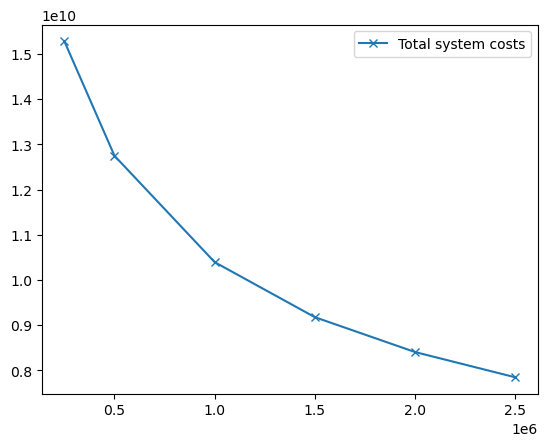

In [68]:
emission_costs.plot(marker="x")